In [1]:
# Data wrangling
import pandas as pd

# Scientific
import numpy as np

# Hyperparameters tuning

# get_ipython().system('pip install hpsklearn')
from hpsklearn import HyperoptEstimator, any_classifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# Machine learning

# get_ipython().system('pip install xgboost')
from xgboost import XGBRegressor
# import xgboost as xgb

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn import preprocessing


# get_ipython().system('pip install boruta')
from boruta import BorutaPy


# get_ipython().system('pip install boostaroota')
from boostaroota import BoostARoota

import pickle


# get_ipython().system('pip install shap')
import shap

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns  # for correlation heatmap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
#pip install numpy==1.23.5

In [3]:
#pip list

In [4]:
#conda list

In [5]:
#conda install -c creditx hpsklearn

In [6]:
#pip install git+https://github.com/hyperopt/hyperopt-sklearn

In [7]:
#conda info --all

In [8]:
#conda install -c conda-forge boruta_py

In [9]:
#pip install boostaroota

In [10]:
#pip install pickle

In [11]:
#pip install shap

In [12]:
#pip install matplotlib

In [13]:
#pip install seaborn

In [14]:
seed = 100

# Choose hyperparameter domain to search over
# 选择要搜索的超参数域
space = {
        'max_depth':hp.choice('max_depth', np.arange(4, 25, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(100, 10000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(250, 350, 10, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'eta':hp.quniform('eta', 0.01, 0.15, 0.01),
        'learning_rate':hp.quniform('learning_rate', 0.01, 0.05, 0.01),
        'objective':'reg:squarederror',
        'tree_method':'gpu_hist',
        'eval_metric': 'rmse',
    }

# score函数是一个用XGBoost模块构建模型并预测和评分的标准的机器学习的通用的流程代码
def score(params):
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10) # eval_set用来作为早期停止的验证集，一般我们放x_test和y_test；verbose:如果为真，并且使用了一个验证集，则写下验证过程；early_stopping_rounds:我们设置一个常数n，直到模型n次得分基本不变就停止
    y_pred = model.predict(X_test).clip(0, 20) # 这行代码的作用是把0-20区间之外的数值转换为0或者20（大于20的数值变为20，小于0的数值变为0。参考：https://www.w3cschool.cn/doc_pandas_0_20/pandas_0_20-generated-pandas-dataframe-clip.html）
    score = np.sqrt(mean_squared_error(y_test, y_pred)) # 机器学习评价指标之回归问题中的均方根误差RMSE（Root Mean Squard Error）
    print(score)
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000) # fmin函数是对不同的算法集及其超参数进行迭代，然后使目标函数最小化的优化函数。fmin为hyperopt核心，返回结果为最优参数集。参考：https://zhuanlan.zhihu.com/p/513174629
    return best

In [15]:
df = pd.read_csv('332_genes_pHpreference_soil_freshwater.csv')

ASV_list = df['ASV']
df = df.drop(['Unnamed: 0','ASV'], axis=1) # 删除'Unnamed: 0'和'ASV'这两列，默认是axis=0，表示删除行。参考：https://blog.csdn.net/qq_42774323/article/details/99737466

gene_list = list(df) # 获取dataframe的列名，输出结果为list结构
gene_list.pop(0) # 删除list中的第0个元素，即pH.preference这个字符串，剩下的元素都是基因type字符串


'pH.preference'

In [16]:
# 这是有监督学习还是无监督学习？最后我得去判定一下。作者说应该是无监督学习。

#Split data into training features and labels
#将数据拆分为训练特征和标签
X, y = df.loc[:, df.columns != 'pH.preference'], df['pH.preference'] # X就是没有pH.preference这列的dataframe（即训练特征）; y是pH.preference这列的dataframe（即标签）

test_size = 0.1 # 使用 "test_size "变量设置测试规模。在Josep的数据中，只有 723 个观测值，说实话并不多。为了让算法有最佳机会达到更高的性能。将测试规模设置为数据集的 10%。如果有成千上万的观测数据，你可能会想提高测试规模，以避免过度拟合并提高验证质量。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed) # 参考: https://blog.csdn.net/weixin_48964486/article/details/122866347

# Quick model
model = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5) # 参考：https://blog.csdn.net/Ling_Ze/article/details/126045472
model.fit(X_train, y_train)

# Predict the model
pred = model.predict(X_test)

# MAE Computation
scores_MAE = mean_absolute_error(y_test, pred)

# RMSE Computation
scores_RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f, MAE : % f" % (scores_RMSE, scores_MAE))


RMSE :  0.682520, MAE :  0.547628


In [17]:
# More complex model （跟上面的Quick model那段代码本质是重复代码，只是尝试了新的参数，使得最终得分更高）
# 作者建议稍微调整一下，看看能否提高分数。作者提供的代码中只是选取了一些效果还不错的数字，

model = XGBRegressor(
    max_depth=5,
    colsample_bytree=0.6,
    n_estimators=300,
    min_child_weight=10,
    subsample=0.9,
    eta=0.03,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.54,
    #tree_method='gpu_hist'
    )

# 作者提供的下面的fit函数中的eval_metric和early_stopping_rounds已经弃用了，虽然能运行成功，但是会警告。正式自己用的时是要修改的。
model.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False,
    early_stopping_rounds=10)

# Run the predictor and compare to the "quick and easy" model
#运行预测器并与“快速简便”模型进行比较

# Predict the model
pred = model.predict(X_test)

# MAE Computation
scores_MAE = mean_absolute_error(y_test, pred)

# RMSE Computation
scores_RMSE = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f, MAE : % f" % (scores_RMSE, scores_MAE))

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


RMSE :  0.673338, MAE :  0.533999


In [18]:
# ## Interpretation
# 说明
# ### Let's try graphing the predicted vs true values!
# 让我们试着绘制预测值与真实值的对比图！
#
# First, we join them into the same dataframe
# 首先，我们将它们连接到同一个数据帧中
predicted_vs_true = pd.DataFrame(y_test) # 将Series类型数据转换成dataframe
predicted_vs_true['Predicted pH (XGBoost)'] = pred # 这行代码的作用是将numpy.ndarray类型的一维数组数据存放到predicted_vs_true这个dataframe的新列Predicted pH (XGBoost)这一列中。也是在最后一列添加的哦。'
# predicted_vs_true
predicted_vs_true = predicted_vs_true.sort_index(ascending=True) # predicted_vs_true这个dataframe按索引由小到大排序

In [19]:
# ### SHAP analysis
# SHAP分析
#
# SHAP 分数可以让我们了解我们的模型。事实上，这可能是理解和解释机器学习模型的最佳方法，即使是像深度神经网络这样的超级黑箱模型也不例外。
# 它是一种基于博弈论的分析方法，可以显示每个特征对模型预测的重要性。
#
# Let's start by using SHAP scores to graph all test predictions vs all test true-values!
# 让我们从使用 SHAP 分数开始，绘制所有测试预测值与所有测试真值的对比图！
explainer = shap.TreeExplainer(model) # 创建 SHAP 的可解释性对象
shap_values_forFE = explainer.shap_values(X_test) # 传入特征矩阵X_test，计算SHAP值，即计算X_test每个特征的SHAP值
# pd.DataFrame(shap_values_forFE)
shap_values = explainer(X_test) # 输出shap.Explanation对象
shap_values

.values =
array([[ 2.8387285e-03,  2.0374954e-03,  7.0838034e-03, ...,
        -1.5273378e-02,  1.1364167e-02,  6.1263132e-04],
       [ 5.7021836e-03, -1.0915543e-03, -1.3748462e-02, ...,
         4.9156165e-03, -3.1654285e-03, -1.0467699e-04],
       [ 2.4573100e-03,  4.2522600e-04,  1.9741750e-03, ...,
        -5.7766063e-04,  8.4623508e-03,  3.4244952e-04],
       ...,
       [ 1.2796929e-03, -6.5430376e-04,  1.0399236e-03, ...,
         1.1651894e-02, -2.7240485e-02,  2.9015509e-04],
       [-3.3133044e-03, -2.7363359e-03,  7.1200873e-03, ...,
         5.0728517e-03, -2.0568281e-02, -5.6494353e-04],
       [-3.8574971e-03,  9.6647243e-04,  1.0809456e-03, ...,
         4.6124933e-03,  1.3320161e-02,  1.3784214e-05]], dtype=float32)

.base_values =
array([6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334,
       6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334,
       6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334,
       6.3445334, 6

In [20]:
# create a 2D numpy array
arr = shap_values.values # 其实就是取SHAP值，好像跟shap_values_forFE等价
type(arr)

numpy.ndarray

In [21]:
# sum of each row
row_totals = arr.sum(axis=1) # numpy数组沿着列进行每一行的求和。参考：https://blog.csdn.net/qq_33885122/article/details/129761488
row_totals # 可见是将二维数组降维为一维数组，每个元素分别对应原先二维数组的每一行的和

array([ 0.99499524, -1.9051578 , -0.13661444, -0.6547688 ,  0.5158986 ,
       -1.5431856 , -0.19910377,  0.8939507 ,  0.15366057, -1.7356105 ,
        0.45697254,  0.12110105,  0.887859  ,  0.5534953 ,  0.24283026,
        0.77601945,  0.34895134,  0.12243025,  0.7928654 ,  0.02359302,
        0.8324449 , -1.0153905 , -0.7558161 ,  0.96464986,  0.3911783 ,
       -1.7450944 ,  1.1541967 , -1.5456293 ,  0.04151911, -0.12651189,
        1.9681414 ,  0.13715565,  0.9497915 ,  0.5623736 ,  1.0871135 ,
        0.47334617,  0.4732655 , -0.7512708 , -1.6932946 , -0.43751425,
        0.3426135 ,  0.0227294 ,  0.55207586,  0.9426306 ,  0.00934245,
       -1.7356105 ,  0.5292655 ,  0.19520438,  0.28951597, -0.96049774,
        0.39213115, -0.7512708 ,  0.22571772,  0.93948084,  0.5284858 ,
       -0.16670841, -0.7021074 , -0.09755258,  0.7612575 ,  0.7857234 ,
       -1.3939271 , -0.10772377,  0.25511658, -0.39623344,  0.5020541 ,
        1.014591  ,  0.3643593 ,  0.65835196], dtype=float32)

In [22]:
# print(shap_values[0].base_values)
row_totals = row_totals + shap_values[0].base_values # row_totals加上那个都是同一个数值的.base_values这个一维数组的数值
# 经过我的测试，我写成shap_values.base_values[0]，依旧可以取出.base_values这个一维数组的这个数值。

In [23]:
shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction']) # 将一维数组row_totals转换为dataframe，且列名为Shap_pH_prediction
shap_value_sums

Shap_pH_prediction
0             7.339529
1             4.439376
2             6.207919
3             5.689764
4             6.860432
..                 ...
63            5.948300
64            6.846588
65            7.359124
66            6.708893
67            7.002885

[68 rows x 1 columns]

In [24]:
shap_value_sums = shap_value_sums.to_numpy() # 将dataframe转换为numpy array。跟pd.DataFrame相反。现在感觉上一行代码真他妈多余余
shap_value_sums

array([[7.3395286],
       [4.439376 ],
       [6.207919 ],
       [5.6897645],
       [6.860432 ],
       [4.8013477],
       [6.1454296],
       [7.2384844],
       [6.498194 ],
       [4.608923 ],
       [6.801506 ],
       [6.4656343],
       [7.2323923],
       [6.898029 ],
       [6.5873637],
       [7.120553 ],
       [6.693485 ],
       [6.466964 ],
       [7.1373987],
       [6.3681264],
       [7.176978 ],
       [5.329143 ],
       [5.5887175],
       [7.309183 ],
       [6.7357116],
       [4.599439 ],
       [7.49873  ],
       [4.7989044],
       [6.3860526],
       [6.2180214],
       [8.3126745],
       [6.481689 ],
       [7.294325 ],
       [6.906907 ],
       [7.431647 ],
       [6.8178797],
       [6.817799 ],
       [5.5932627],
       [4.651239 ],
       [5.907019 ],
       [6.687147 ],
       [6.367263 ],
       [6.8966093],
       [7.287164 ],
       [6.353876 ],
       [4.608923 ],
       [6.873799 ],
       [6.5397377],
       [6.6340494],
       [5.3840356],


In [25]:
y_df = pd.DataFrame(y_test) # 将Series类型数据转换成dataframe
shap_valuecomp = y_df # 他又将它赋值给shap_valuecomp这个变量，真他么傻逼。
# 现在感觉下面这行用Predicted ph这个列名不合适，应该用shap_value_sums这样的字符串来代替这个列名。
shap_valuecomp['Predicted pH'] = shap_value_sums # 将shap_value_sums这个值添加到shap_valuecomp这个dataframe的最后一列。
shap_valuecomp = shap_valuecomp.sort_index(ascending=True) # shap_valuecomp这个dataframe按索引由小到大排序。
shap_valuecomp

pH.preference  Predicted pH
24        4.469885      5.329143
48        5.149540      4.599439
54        5.238161      6.207919
56        5.414971      4.651239
69        5.738965      6.801506
..             ...           ...
588       5.900000      5.593263
594       6.020000      6.386053
633       6.480000      6.539738
665       7.910000      6.873799
669       7.940000      7.287164

[68 rows x 2 columns]

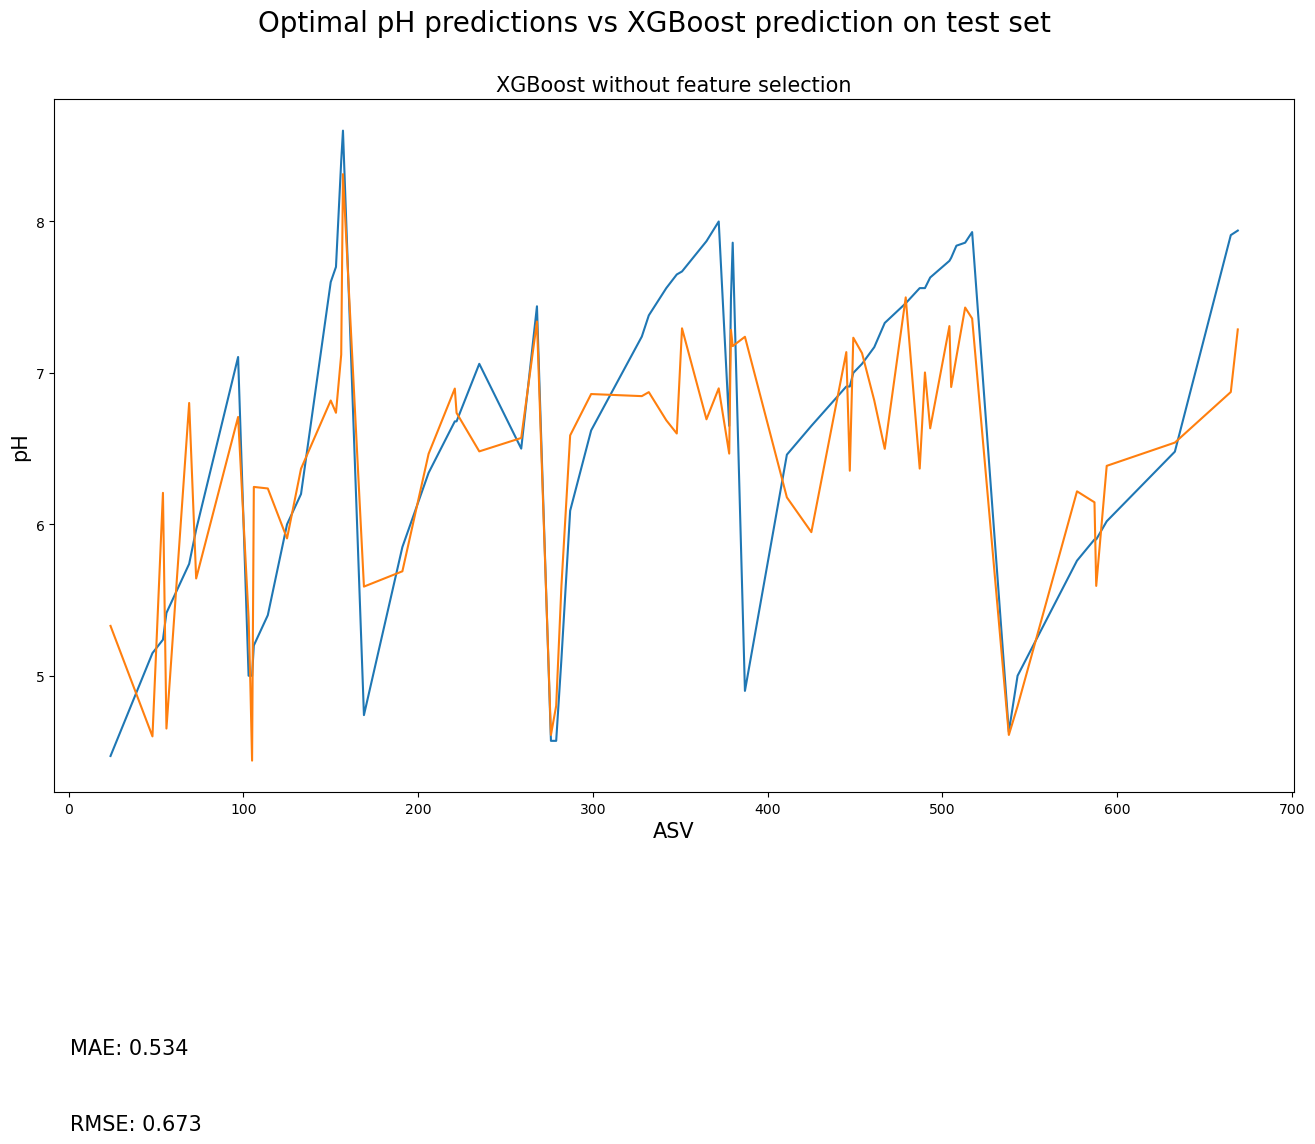

In [26]:
# 这块代码就是画图函数
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH'], label = "line 1")

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs XGBoost prediction on test set", fontsize=20)
plt.title("XGBoost without feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_MAE, fontsize=15)

plt.savefig('xgboost_testset.png')
plt.show()

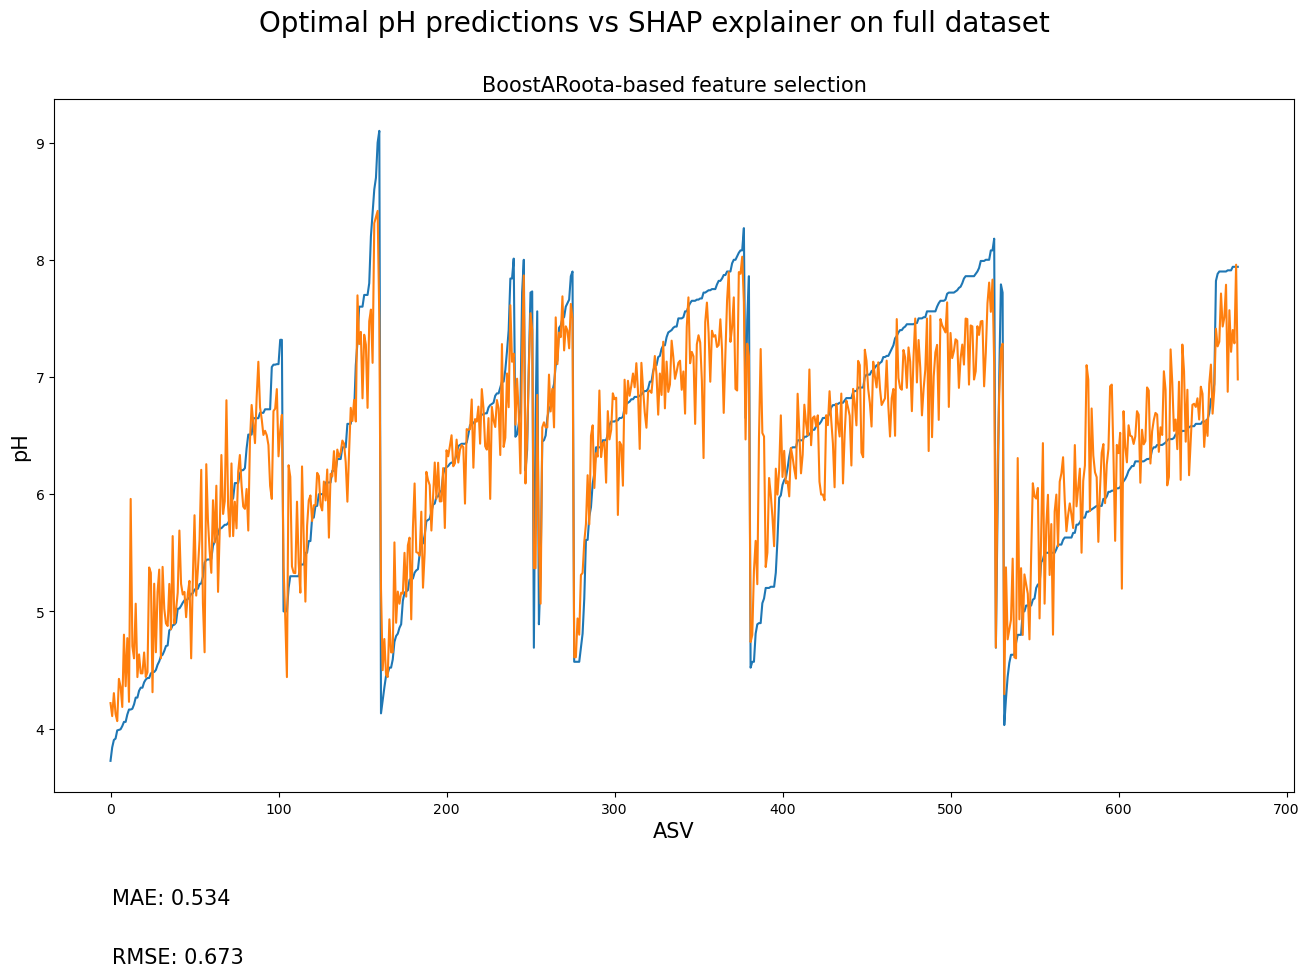

In [27]:
# SHAP values allow us to graph against all values, even though the predictor was only trained on 90% of the data. It looks pretty good!
# SHAP值允许我们根据所有值绘制图形，即使预测器只训练了90%的数据。看起来很不错!

explainer = shap.TreeExplainer(model)
shap_values_forFE = explainer.shap_values(X)
shap_values = explainer(X)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals + shap_values[0].base_values

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH (XGBoost)'], label = "line 1")


plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("BoostARoota-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_MAE, fontsize=15)
#
plt.savefig('xgboost_fullset.png')
plt.show()


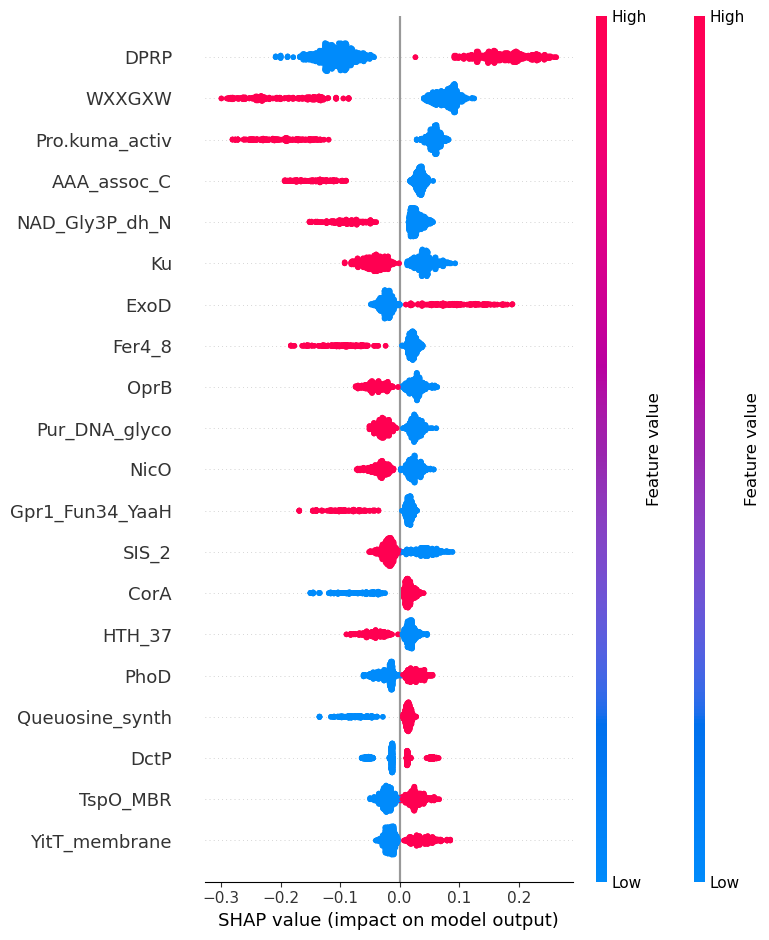

.values =
array([[-2.2148073e-02, -7.8302866e-04,  9.2026149e-04, ...,
        -4.8359386e-03, -3.2912474e-02,  1.7294384e-04],
       [-1.4317999e-02, -8.4471639e-04,  1.5080618e-03, ...,
        -9.1970786e-03, -3.4839693e-02, -1.7102450e-04],
       [ 1.9494562e-03,  9.4113935e-04,  5.1031937e-03, ...,
        -3.0931658e-03, -2.3348413e-03,  3.2809476e-05],
       ...,
       [-2.0502261e-03,  8.9107227e-04, -4.8283474e-03, ...,
         5.9635369e-03,  2.2251055e-02, -2.4754179e-04],
       [ 9.4940141e-04,  1.7103280e-03,  1.2333008e-03, ...,
         1.8896772e-02,  1.4033634e-02,  2.4680425e-03],
       [ 6.5733632e-03,  2.2432557e-03,  1.7958432e-03, ...,
         5.0957468e-03,  1.7058648e-02,  3.4244952e-04]], dtype=float32)

.base_values =
array([6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334,
       6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334,
       6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334, 6.3445334,
       6.3445334, 6

In [28]:
# ### SHAP summary plot
#
# So how do all of our features, genes in this case, impact the predicted pH of each ASV?
# 那么我们所有的特征，在这种情况下的基因，是如何影响每一种ASV的预测pH值的呢?
#
# In this graph,we are using one-hot encoded classes instead of continuous features, so "red" represents gene present (1) and "blue" represents gene absent (0). Because it is a regression, a gene's presence or absence with nearly zero impact will actually show as a small impact if the opposite situation (present for absent or absent for present) has a strong impact. For example, "endonuclease_5" in the plot below effectivly has zero impact on pH optimum if the gene is absent, but can have a fairly substantial impact (in the positice direction) if present. AAA_assoc_C has the opposite impact.
# 在这个图中，我们使用的是单热编码类，而不是连续特征，所以“红色”代表基因存在(1)，“蓝色”代表基因缺失(0)。
# 因为这是一个回归，如果相反的情况(以存在代替缺失或以缺失代替存在)有很强的影响，那么几乎没有影响的基因的存在或缺失实际上会显示出很小的影响。
# 例如，下图中的“endonuclease_5”在基因缺失的情况下对pH最佳值的影响实际上为零，但如果基因存在，则会产生相当大的影响(在正方向上)。AAA_assoc_C具有相反的影响。
fig = shap.summary_plot(shap_values, X, show=False) # 展示了每个特征的SHAP值随着特征值的变化。
plt.savefig('xgboost_summary.png')

shap.summary_plot(shap_values, X)
shap_values


In [29]:
# # Feature Selection
#
# I've noticed that in some papers, authors stop at citing the error of functions, R^2 values, etc, with maybe a PCA thrown on top. I firmly believe this is insufficent as it allows noise to enter into the model, reduced the clarity of the model, and ultimatly obfuscates what is actually happening in a natural process.
# 我注意到，在一些论文中，作者在引用函数误差、R^2值等时停下来，可能会在上面加一个PCA。我坚信这是不够的，
# 因为它允许噪音进入模型，降低了模型的清晰度，并最终混淆了在自然过程中实际发生的事情。
#
# #### What is feature selection?
# 什么是特征选择？
#
# Feature selection is when you select a subset of features (variables) from your data. This serves to reduce model complexity (going from hundreds of variables to a few tens in the case of Josep's data) and reduce the error introduced by noise (called generalization error). As you can imagine, a model with fewer variables and especially without irrelevant variables will be more efficent and more powerful.
# 特征选择是指从数据中选择特征(变量)的子集。这有助于降低模型的复杂性(在Josep的数据中，从数百个变量减少到几十个变量)，
# 并减少由噪声引入的误差(称为泛化误差)。正如您可以想象的那样，具有更少变量的模型，特别是没有无关变量的模型将更高效、更强大。
#


In [30]:
# ## Feature Selection Method One
# 特征选择方法一
# ### Ranking features based on gain
# 基于增益的排名功能
#
# XGBoost built in feature importance metric. MDI counts the times a feature is used to split a node, weighted by the number of samples it splits. Near as I can tell gain is basically MDI but Gini impurity is replaced by the objective function of the gradient boosting model.
# XGBoost内置功能重要性度量。MDI计算一个特征被用来分割节点的次数，并按它分割的样本数量加权。据我所知，增益基本上是MDI，但基尼杂质被梯度增强模型的目标函数所取代。
#
# We are going to run the .feature_importances_.argsort() on our model from above and rank them based on our training set.
# 我们将在上面的模型上运行.feature_importances_argsort()，并根据我们的训练集对它们进行排名。
sorted_idx = model.feature_importances_.argsort()

sorted_idx # 我查看刚刚好是332个，对应332个基因特征

array([ 14,  31, 103, 238, 323, 168,  24,  81,  21, 283, 220, 307,  55,
        56, 206, 122,  10,  23,  64, 319, 108, 177,  40,  63, 258, 257,
       186, 164,  37, 212, 223, 219, 158, 180,  83,  87,  73,  74,  34,
        45,   1, 166, 231, 221, 232,  41, 184, 160,  42,  90, 154, 139,
       280, 123, 104, 298, 137, 213,  77, 316, 109, 131, 135, 237, 152,
       268, 226,  97, 110,  67, 128, 175, 256,  43, 242, 102, 203, 138,
        62,  51,  12,  28, 142,   8,  65, 235,  71, 299,  46,  94, 188,
        89, 289,  91, 322,  78,  82,  44, 279,  99, 311, 113,  22, 288,
       326, 136, 165, 281, 134, 222, 182, 174, 327, 240, 179, 112, 143,
       305,  75, 331,  80, 141,  29, 274, 101, 170,  88, 211, 209, 317,
       153,  49,   3,  47, 194,  96, 125,  16, 195,  30, 249,   0, 254,
       312, 129,  60,  93, 285, 295, 243, 119, 106, 244, 330, 313, 126,
       296, 318, 239,  27, 292, 197,  25,  98,  68, 124, 114,  69,  17,
       193, 191, 196, 290,  15,  57, 181,  50, 172, 200, 294, 18

In [31]:
type(X_train)
type(y_train)
type(X_test)
type(y_test)

pandas.core.series.Series

In [32]:
X_train.columns[sorted_idx] # 这行代码应该只是作者想查看下索引并且它实则是下面绘图函数X坐标数组，初始的X_train并没有变化。即列的顺序还是那样。type(df.columns[sorted_idx])显示它只是pandas.core.indexes.base.Index
X_train

model.feature_importances_[sorted_idx]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.0246017e-05,
       3.3474344e-04, 4.3795319e-04, 6.7532336e-04, 9.3187357e-04,
       9.4429607e-04, 9.6860406e-04, 1.0081397e-03, 1.0305659e-03,
       1.0535935e-03, 1.0601548e-03, 1.0830276e-03, 1.1268459e-03,
       1.1549143e-03, 1.1798565e-03, 1.1944679e-03, 1.2225074e-03,
       1.2334539e-03, 1.2936960e-03, 1.3008538e-03, 1.3092270e-03,
       1.3278448e-03, 1.3368713e-03, 1.3431608e-03, 1.3707648e-03,
       1.3719355e-03, 1.3730027e-03, 1.4214512e-03, 1.4401342e-03,
       1.4478501e-03, 1.4503032e-03, 1.4506018e-03, 1.4533959e-03,
       1.4604437e-03, 1.4667453e-03, 1.4848923e-03, 1.4885000e-03,
       1.5061062e-03, 1.5109885e-03, 1.5409489e-03, 1.5413638e-03,
       1.5467065e-03, 1.5471383e-03, 1.5599144e-03, 1.5651505e

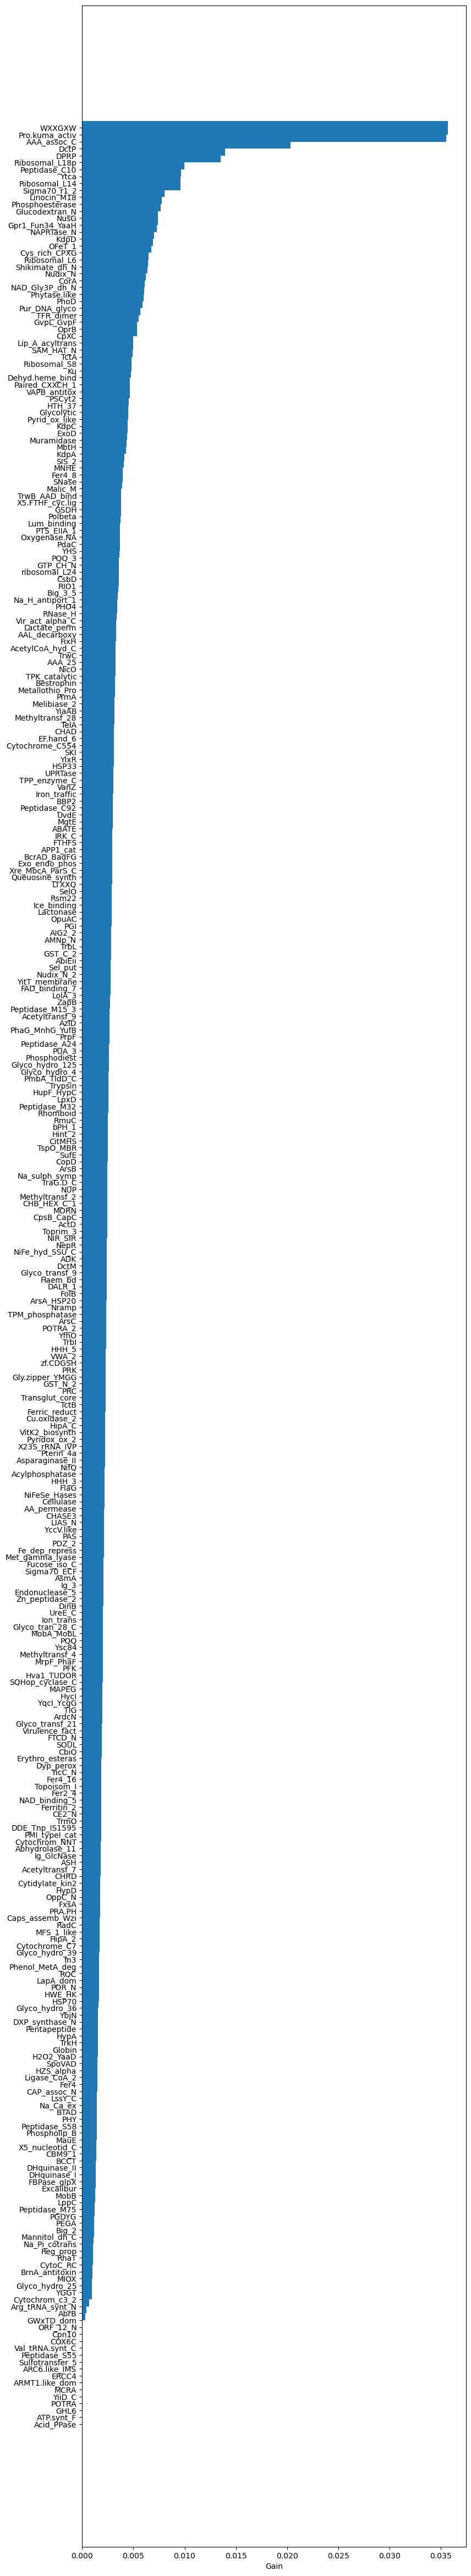

In [33]:
# ### Plot the gain
# 绘制增益
#
# You see some features (genes in this case) towards the top have relativly high importance, and some actually have pretty dand low importance. Lets get rid of some of these unimportant features!
# 你可以看到一些特征(在这种情况下是基因)在顶部具有相对较高的重要性，而一些实际上具有相当低的重要性。让我们去掉这些不重要的特征吧!
fig=plt.figure(figsize=(9, 60))
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx], height=2)
plt.xlabel("Gain")
fig.savefig('XGBoost_Gain_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()


In [34]:
# First, lets get a list of our importances in tabular format.
# 首先，让我们以表格的形式列出我们的重要性。
result=list(reversed(model.feature_importances_[sorted_idx]))
result

[0.035651658,
 0.035539825,
 0.020324431,
 0.01396212,
 0.013513559,
 0.009976638,
 0.009654856,
 0.009616348,
 0.00958079,
 0.008062925,
 0.007761708,
 0.0076463623,
 0.0073987045,
 0.0073971055,
 0.0073031504,
 0.0070225648,
 0.006911196,
 0.0067418446,
 0.0065084314,
 0.0064399433,
 0.006368506,
 0.0062042363,
 0.0061329925,
 0.006054844,
 0.005991168,
 0.0059061944,
 0.005695883,
 0.0054993844,
 0.005347882,
 0.0053318655,
 0.0049840217,
 0.0049636997,
 0.004940312,
 0.0048140176,
 0.004800347,
 0.0047579063,
 0.004671265,
 0.0046677743,
 0.0046656583,
 0.004557789,
 0.004509581,
 0.0044766255,
 0.004446659,
 0.004430101,
 0.004404483,
 0.0043267165,
 0.004299171,
 0.0041151955,
 0.004053114,
 0.0039744866,
 0.0039571775,
 0.0039185244,
 0.0038098919,
 0.0038053356,
 0.0038035186,
 0.0038001626,
 0.0037643332,
 0.003711021,
 0.0036909836,
 0.003676509,
 0.0036735686,
 0.0036273445,
 0.0035929515,
 0.0035879272,
 0.0035740344,
 0.0035688966,
 0.0035181027,
 0.0034935363,
 0.00342332

In [35]:
gainlist = pd.DataFrame()
gainlist['gene'] = list(reversed(X_train.columns[sorted_idx]))
gainlist['mdi'] = list(reversed(model.feature_importances_[sorted_idx]))
gainlist # gainlist为一个存有绘制增益条形图的X和Y数组的dataframe

gene       mdi
0            WXXGXW  0.035652
1    Pro.kuma_activ  0.035540
2       AAA_assoc_C  0.020324
3              DctP  0.013962
4              DPRP  0.013514
..              ...       ...
327          YiiD_C  0.000000
328           POTRA  0.000000
329            GHL6  0.000000
330      ATP.synt_F  0.000000
331      Acid_PPase  0.000000

[332 rows x 2 columns]

In [36]:
# ### Remove all the genes with a feature importance below the mean and create a new dataframe to train XGBoost on only including those genes with a high-enough importance
# 删除所有特征重要性低于平均值的基因，并创建一个新的数据框架来训练XGBoost，只包括那些具有足够高重要性的基因
#
# This is an arbitray cutoff; feel free to play around with it
# 这是一个任意的阈值;请随意摆弄它
mdi_mean = gainlist['mdi'].mean() # 获得总增益值（也许叫特征重要性值）的平均值，因为正如这块代码开头所述，要删除特征重要性低于平均值的基因
gainlist_subset = gainlist.loc[gainlist['mdi'] > mdi_mean] # 选取dataframe中mdi这列大于增益值平均值的所有行并存到gainlist_subset这个dataframe中

gainlist_subset_list = gainlist_subset['gene'].tolist() # 将gainlist_subset的gene列，即大于增益值平均值的基因名转成列表形式
gainlist_subset_list.append('pH.preference') # 在列表的后面增加一个名为pH.preference的元素

gainlist.loc[gainlist['gene'].isin(gainlist_subset_list)].to_csv('gain_selection.csv') # 将gainlist这个dataframe中大于增益值平均值的基因名所在的所有行都输出到gain_selection.csv文件中

In [37]:
gainlist_subset_df = df[gainlist_subset_list] # 把原始df中的这些大于增益值平均值的基因所对应的所有行都提出来。即gainlist_subset_df为只有大于增益值平均值的原始df数据
gainlist_subset_df

WXXGXW  Pro.kuma_activ  AAA_assoc_C  DctP  DPRP  Ribosomal_L18p  \
0         1               0            1     0     0               1   
1         1               1            1     1     0               1   
2         1               1            0     0     0               1   
3         1               1            1     0     0               1   
4         1               1            1     0     0               1   
..      ...             ...          ...   ...   ...             ...   
667       0               1            0     0     1               1   
668       0               0            0     0     1               1   
669       0               0            0     0     1               1   
670       0               0            0     1     1               1   
671       1               0            0     1     0               1   

     Peptidase_C10  Ytca  Ribosomal_L14  Sigma70_r1_2  ...  EF.hand_6  \
0                0     1              1             1  ...          0   
1                0     1              1             0  ...          0   
2                0     1              1             0  ...          0   
3                0     1              1             0  ...          0   
4                0     1              1             0  ...          0   
..             ...   ...            ...           ...  ...        ...   
667              0     0              1             0  ...          0   
668              0     0              1             0  ...          0   
669              0     0              1             0  ...          0   
670              0     0              1             0  ...          0   
671              0     0              1             0  ...          0   

     Cytochrome_C554  SKI  YlxR  HSP33  UPRTase  TPP_enzyme_C  VanZ  \
0                  0    0     1      1        1             1     0   
1                  0    1     0      1        1             1     0   
2                  0    1     0      1        1             0     0   
3                  0    1     0      0        0             0     1   
4                  1    1     0      0        0             1     1   
..               ...  ...   ...    ...      ...           ...   ...   
667                0    1     0      0        1             1     0   
668                0    1     0      0        0             0     0   
669                0    1     0      0        0             0     1   
670                0    1     1      1        1             1     0   
671                0    1     1      1        0             1     1   

     Iron_traffic  pH.preference  
0               0       3.724741  
1               1       3.839540  
2               1       3.902705  
3               1       3.914741  
4               1       3.984741  
..            ...            ...  
667             0       7.910000  
668             1       7.940000  
669             0       7.940000  
670             0       7.940000  
671             0       7.940000  

[672 rows x 98 columns]

In [38]:
# 这块代码跟一开始一样，就是标准的拆分训练集和特征集的代码。
#Split data into training features and labels
# 将数据拆分为训练特征和标签
X_gain, y_gain = gainlist_subset_df.loc[:, gainlist_subset_df.columns != 'pH.preference'], gainlist_subset_df['pH.preference']

test_size = 0.1
X_gain_train, X_gain_test, y_gain_train, y_gain_test = train_test_split(X_gain, y_gain, test_size=test_size, random_state=seed)

# Quick model
model_gain_subset = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_gain_subset.fit(X_gain_train, y_gain_train)

# Interestingly, that does not seem to have helped much.
# 有趣的是，这似乎并没有多大帮助。

# Predict the model
pred_gain_subset = model_gain_subset.predict(X_gain_test)

# MAE Computation
scores_gain_subset_MAE = mean_absolute_error(y_gain_test, pred_gain_subset)

# RMSE Computation
scores_gain_subset_RMSE = np.sqrt(mean_squared_error(y_gain_test, pred_gain_subset))
print("RMSE : % f, MAE : % f" % (scores_gain_subset_RMSE, scores_gain_subset_MAE))

RMSE :  0.731134, MAE :  0.576844


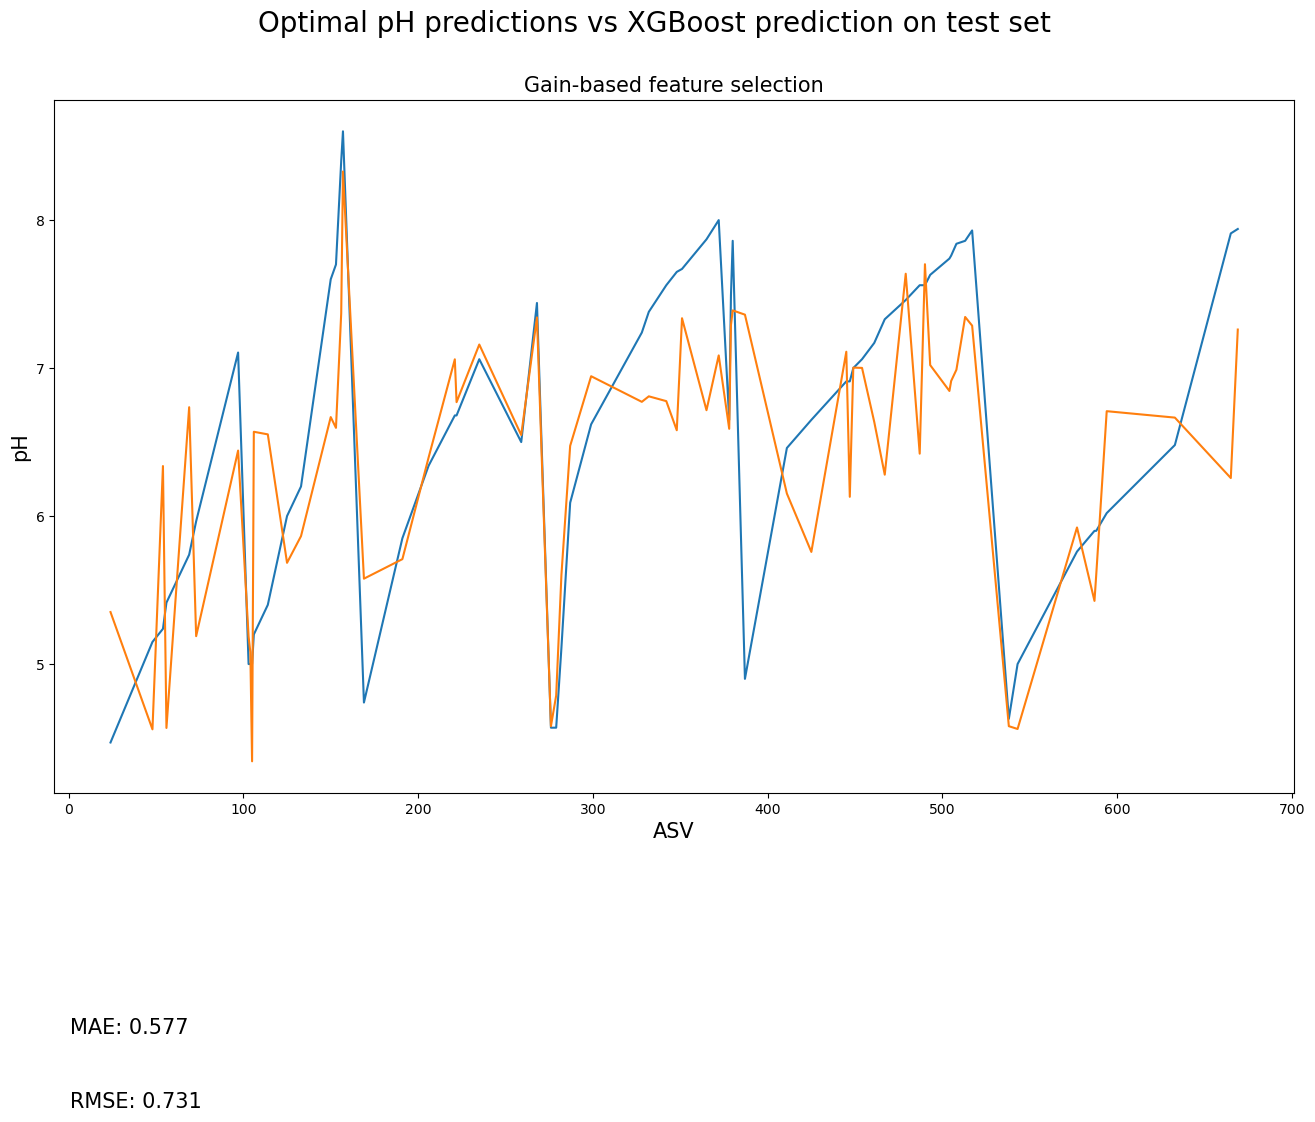

In [39]:
# ### Running the SHAP analysis as we did for the basic model
# 像我们对基本模型所做的那样运行SHAP分析
# See the XGBoost section at the top for a refresher
# 查看顶部的XGBoost部分以获得复习
gain_predicted_vs_true = pd.DataFrame(y_gain_test)
gain_predicted_vs_true['Predicted pH (XGBoost)'] = pred_gain_subset

#shap_valuecomp
gain_predicted_vs_true = gain_predicted_vs_true.sort_index(ascending=True)
# gain_predicted_vs_true

explainer = shap.TreeExplainer(model_gain_subset)
shap_values_forFE = explainer.shap_values(X_gain_test)
shap_values = explainer(X_gain_test)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals + shap_values[0].base_values

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y_gain_test)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH'], label = "line 1")

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs XGBoost prediction on test set", fontsize=20)
plt.title("Gain-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_gain_subset_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_gain_subset_MAE, fontsize=15)

plt.savefig('gain_testset.png')
plt.show()



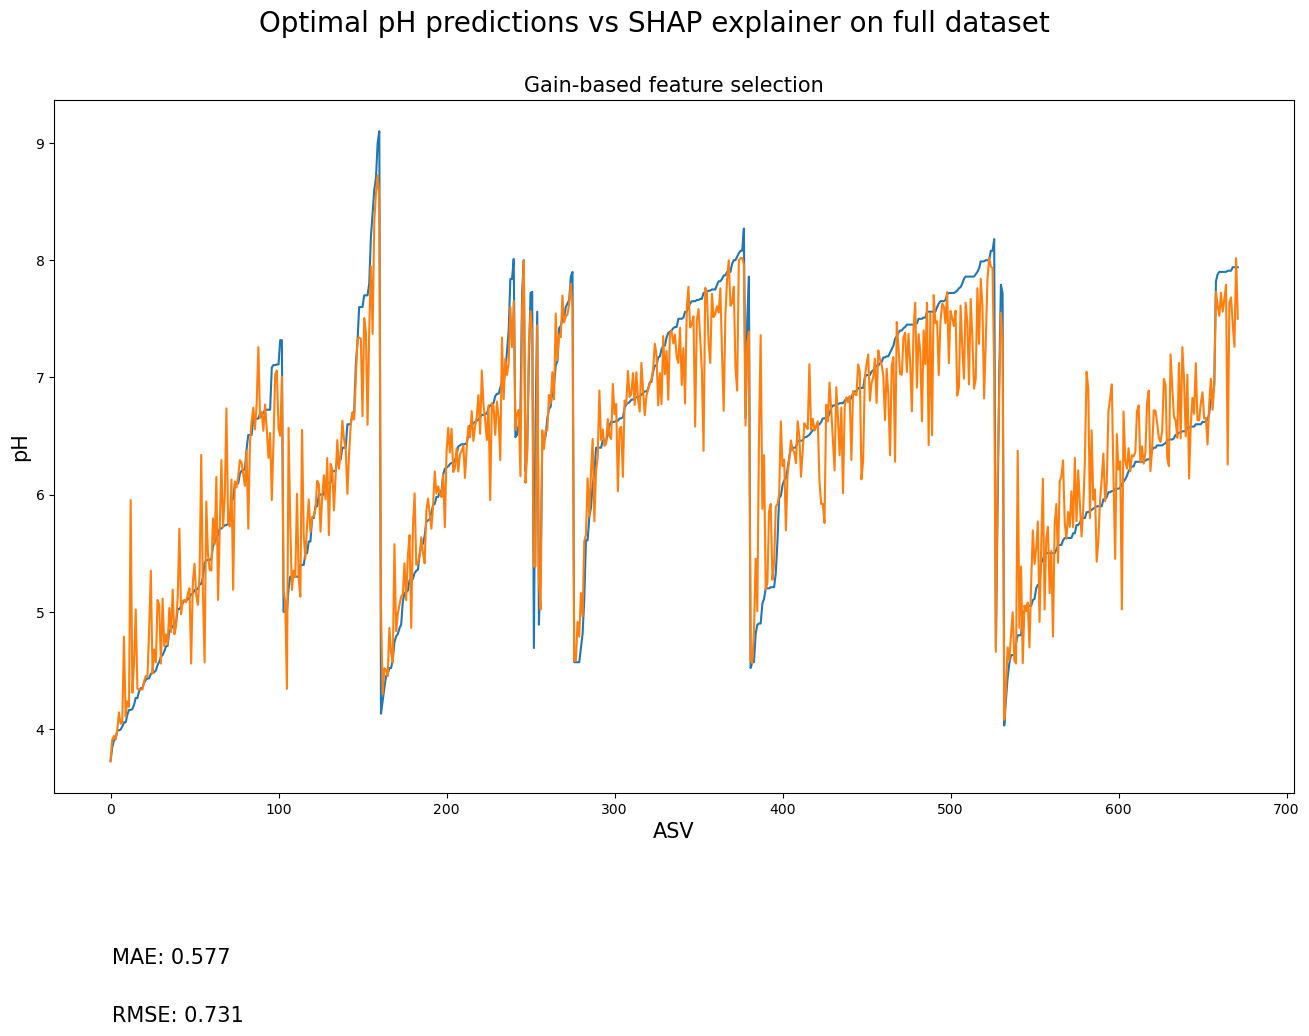

In [40]:
explainer = shap.TreeExplainer(model_gain_subset)
shap_values_forFE = explainer.shap_values(X_gain)
shap_values = explainer(X_gain)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals+shap_values[0].base_values

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)

plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH (XGBoost)'], label = "line 1") # 这一行代码作者提供的没有 (XGBoost)，因此，会报错找不到Predicted pH这个key类似字典那个错误。

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("Gain-based feature selection", fontsize = 15)

plt.text(1, 1.5, "RMSE: %.3f" % scores_gain_subset_RMSE, fontsize=15)
plt.text(1, 2.0, "MAE: %.3f" % scores_gain_subset_MAE, fontsize=15)

plt.savefig('gain_fullset.png')
plt.show()

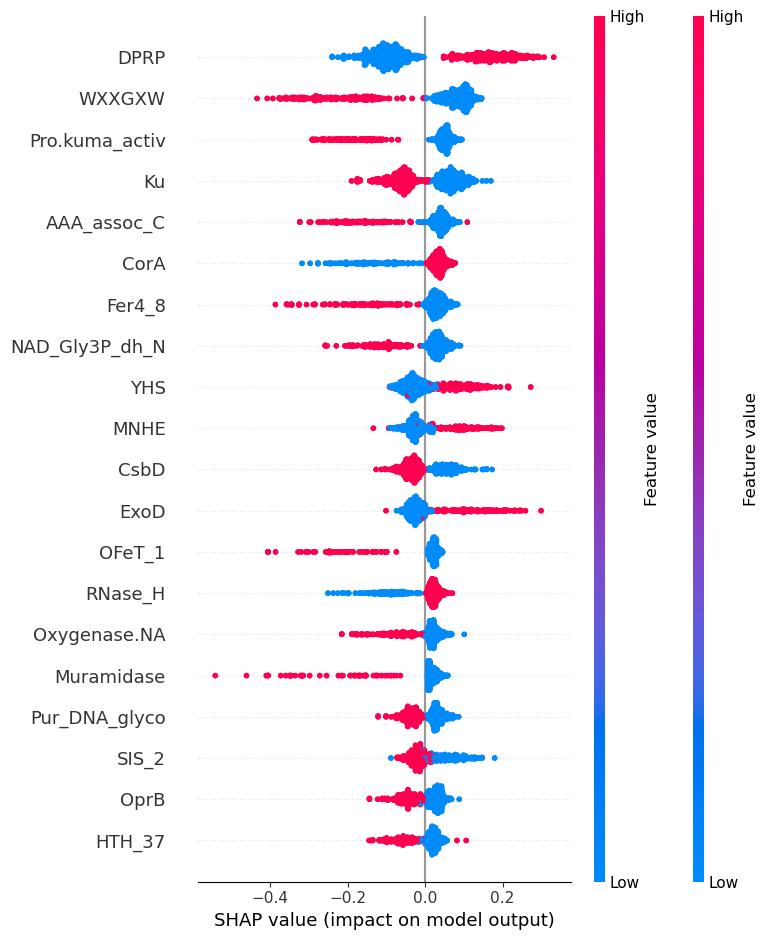

Mean MAE of original model: 0.534 Mean MAE of model based on gain subset: 0.577
Mean RMSE of model based on gain is -0.043 lower than RMSE of original model
Mean RMSE of original model: 0.673 Mean RMSE of model based on gain subset: 0.731
Mean RMSE of model based on gain is -0.058 lower than RMSE of original model


In [41]:
fig = shap.summary_plot(shap_values, X_gain, show=False)
plt.savefig('gain_summary.png')

shap.summary_plot(shap_values, X_gain)

print('Mean MAE of original model: %.3f Mean MAE of model based on gain subset: %.3f' % (scores_MAE, scores_gain_subset_MAE))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_MAE-scores_gain_subset_MAE))
print('Mean RMSE of original model: %.3f Mean RMSE of model based on gain subset: %.3f' % (scores_RMSE, scores_gain_subset_RMSE))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_RMSE-scores_gain_subset_RMSE))


In [42]:
# ## Feature Selection Method Two
# 特征选择方法二
# ### Ranking features based on permutation importance
# 基于排列重要性的排序功能
# Permutation importance tests assign random values to each feature and then rerun the model with the random feature. If the resulting model performs worse than the original model, then the feature is assigned a positive value. If, however, it performs better than the original model, the feature is assigned a negative value, indicating that the feature likely introduces spurrious relationships in the data (e.g. "worse than noise")
# 排列重要性测试为每个特征分配随机值，然后使用随机特征重新运行模型。如果最终模型的性能比原始模型差，那么该特征被赋予一个正值。
# 然而，如果它比原始模型表现得更好，则该特征被赋予负值，表明该特征可能在数据中引入了杂散关系(例如:“比噪音还糟糕”)
perm_importance = permutation_importance(model, X_test, y_test, random_state=seed) # 这行代码还挺耗时,结果为一个字典类型
print(perm_importance)



{'importances_mean': array([-2.28909030e-03, -2.18448483e-05, -2.08300893e-03, -4.69723419e-04,
       -1.08069605e-03,  7.41682958e-04, -1.90712808e-03, -5.40534672e-04,
        4.82250560e-04,  1.33388704e-03,  0.00000000e+00,  2.49159473e-04,
       -9.08270461e-04, -9.22616832e-04,  0.00000000e+00,  5.48717757e-05,
       -9.44059764e-04, -6.99463167e-05,  2.85191552e-05,  8.29854664e-04,
        5.88854999e-05,  0.00000000e+00, -5.03283405e-05, -2.90267181e-05,
        0.00000000e+00, -1.17700326e-04, -3.71808973e-04, -2.45669984e-03,
        9.31144327e-04,  2.20941817e-03, -4.03525275e-04,  0.00000000e+00,
        1.18295745e-03, -1.27970091e-03, -3.01609235e-04, -1.82150049e-03,
        2.00884426e-03, -4.35964436e-05,  3.11350188e-04, -1.21335406e-04,
        8.52027005e-05,  3.36057788e-04,  6.80293528e-04,  5.38497553e-05,
        1.56914504e-05, -2.52909126e-05, -6.53929645e-03,  1.43129078e-03,
        2.41381944e-04,  8.24591906e-04,  2.37592636e-04,  6.89748906e-04,
    

In [43]:
print(perm_importance['importances_mean'].shape)

(332,)


In [44]:
sorted_idx = perm_importance.importances_mean.argsort()
sorted_idx

array([140, 228, 267,  46, 243, 241, 117, 247, 324, 116,  82,  96, 190,
        91, 110, 210, 273, 221, 276, 162, 222,  27, 214, 187, 236, 300,
       282,   0, 254,  61, 268, 330, 286, 185,   2,  84,   6,  35, 252,
       204, 293, 150, 173, 212, 275,  71,  33, 124,  86, 295, 148,   4,
       270,  89,  77, 153,  52, 128, 101, 264,  16,  13,  12,  90, 113,
       302, 274, 291, 313, 253, 329,  93,  94, 316, 191, 166, 205, 193,
       284, 327, 249,   7, 256, 258, 145, 325, 108, 299, 244,   3,  73,
       301, 126,  30, 260, 123, 164, 248, 288,  26, 257, 239,  34, 226,
        53, 133, 296, 261, 174, 144, 262, 305, 179,  75, 277, 138,  87,
       131, 217, 102, 285, 237, 292, 184, 235, 290,  39,  25, 223,  88,
       281, 322,  17, 319, 242, 308,  22, 326, 231,  37, 175, 269, 318,
       139, 188, 263,  23,  45,   1, 158, 137,  63, 283, 238,  24, 168,
        56,  55, 307, 201,  31, 206,  81,  10, 323,  14, 220,  21, 103,
       161,  98,  44,  18,  57, 245,  43,  15,  20, 180, 309,  5

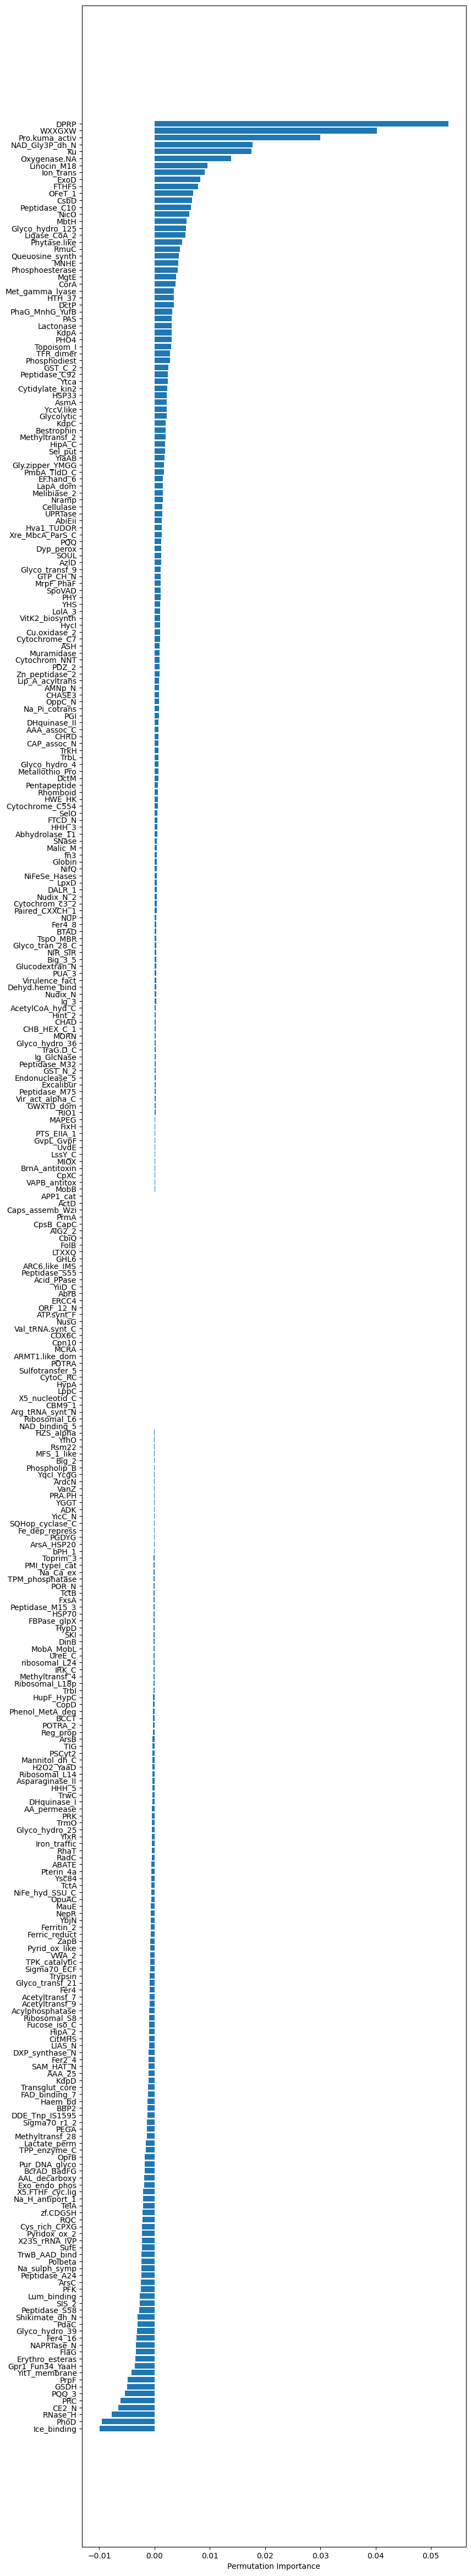

In [45]:
fig=plt.figure(figsize=(9, 60))
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig('Perm_Importance_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()

In [46]:
permlist = pd.DataFrame()
permlist['gene'] = list(reversed(X_train.columns[sorted_idx]))
permlist['permimpt'] = list(reversed(perm_importance.importances_mean[sorted_idx]))

permlist

gene  permimpt
0              DPRP  0.053177
1            WXXGXW  0.040229
2    Pro.kuma_activ  0.030012
3    NAD_Gly3P_dh_N  0.017684
4                Ku  0.017528
..              ...       ...
327             PRC -0.006123
328           CE2_N -0.006539
329         RNase_H -0.007802
330            PhoD -0.009542
331     Ice_binding -0.009951

[332 rows x 2 columns]

In [47]:
# ### Here we are removing all features below a set threshold
# 在这里，我们要删除所有低于设定阈值的特征
#
# This will be heavily dependant on what your permutation list looks like and is somewhat arbitrary. However, you could introduce a grid search that reruns the model with a range of different tresholds and selects the one with the best performance.
# 这在很大程度上取决于你的排列列表，而且有些随意。不过，您可以引入网格搜索，用一系列不同的阈值重新运行模型，然后选择性能最好的一个。

permlist_subset = permlist.loc[permlist['permimpt'] > 0.005]

permlist_subset = permlist_subset['gene'].tolist()
permlist_subset.append('pH.preference')

permlist.loc[permlist['gene'].isin(permlist_subset)].to_csv('perm_selection.csv')

permlist_subset_df = df[permlist_subset]


In [48]:
#Split data into training features and labels
# 将数据拆分为训练特征和标签
X_perm, y_perm = permlist_subset_df.loc[:, permlist_subset_df.columns != 'pH.preference'], permlist_subset_df['pH.preference']

test_size = 0.1
X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X_perm, y_perm, test_size=test_size, random_state=seed)

# Quick model
model_perm_subset = XGBRegressor(learning_rate=0.05, n_estimators=300, max_depth=5)
model_perm_subset.fit(X_perm_train, y_perm_train, early_stopping_rounds=10, eval_metric="rmse", verbose=False, eval_set=[(X_perm_train, y_perm_train), (X_perm_test, y_perm_test)])


# Predict the model
pred_perm_subset = model_perm_subset.predict(X_perm_test)

# MAE Computation
scores_perm_subset_MAE = mean_absolute_error(y_perm_test, pred_perm_subset)

# RMSE Computation
scores_perm_subset_RMSE = np.sqrt(mean_squared_error(y_perm_test, pred_perm_subset))
print("RMSE : % f, MAE : % f" % (scores_perm_subset_RMSE, scores_perm_subset_MAE))

# ### Compare this performance to the original model
# 将这一性能与原始模型进行比较
#
# In this case, it's better!!!! How 'bout them apples?

print('Mean MAE of original model: %.3f Mean MAE of model based on permutation subset: %.3f' % (scores_MAE, scores_perm_subset_MAE))
print('Mean RMSE of model based on permutation importance is %.3f lower than RMSE of original model' % (scores_MAE-scores_perm_subset_MAE))
print('Mean RMSE of original model: %.3f Mean RMSE of model based on permutation subset: %.3f' % (scores_RMSE, scores_perm_subset_RMSE))
print('Mean RMSE of model based on permutation importance is %.3f lower than RMSE of original model' % (scores_RMSE-scores_perm_subset_RMSE))


RMSE :  0.640895, MAE :  0.538613
Mean MAE of original model: 0.534 Mean MAE of model based on permutation subset: 0.539
Mean RMSE of model based on permutation importance is -0.005 lower than RMSE of original model
Mean RMSE of original model: 0.673 Mean RMSE of model based on permutation subset: 0.641
Mean RMSE of model based on permutation importance is 0.032 lower than RMSE of original model


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [49]:
# ###  Save that model!!!!
# 保存模型
# save the model to disk
# 将模型保存到磁盘
filename = 'pH_model_2022-09-12.sav'
pickle.dump(model_perm_subset, open(filename, 'wb'))

In [50]:
# 1.2.5  Verify that the loaded model works
# 验证加载的模型是否正常运行

# load the model from disk
filename = 'pH_model_2022-09-12.sav'
loaded_model = pickle.load(open(filename, 'rb'))

loaded_model.fit(X_perm_train, y_perm_train, early_stopping_rounds=10, eval_metric="rmse", verbose=False, eval_set=[(X_perm_train, y_perm_train), (X_perm_test, y_perm_test)])

# Predict the model
loaded_pred_perm_subset = loaded_model.predict(X_perm_test)

# MAE Computation
scores_loaded_perm_subset_MAE = mean_absolute_error(y_perm_test, loaded_pred_perm_subset)

# RMSE Computation
scores_loaded_perm_subset_RMSE = np.sqrt(mean_squared_error(y_perm_test, loaded_pred_perm_subset))
print("RMSE : % f, MAE : % f" % (scores_loaded_perm_subset_RMSE, scores_loaded_perm_subset_MAE))

RMSE :  0.640895, MAE :  0.538613


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [51]:
# 1.2.6  SHAP analysis of the permutation based model
# 基于置换模型的 SHAP 分析
perm_predicted_vs_true = pd.DataFrame(y_perm_test) 
#predictions = pd.DataFrame(pred_perm_subset)
perm_predicted_vs_true['Predicted pH (XGBoost, permutation)'] = pred_perm_subset

#pd.concat([pd.DataFrame(pred_perm_subset),pd.DataFrame(y_perm_test)], axis=1, ignore_index=True)

#shap_value_sums
#y_df = pd.DataFrame(y)
#shap_valuecomp=pd.merge(y_df,shap_value_sums,left_index=True, right_index=True)
#shap_valuecomp
perm_predicted_vs_true = perm_predicted_vs_true.sort_index(ascending=True)
perm_predicted_vs_true

pH.preference  Predicted pH (XGBoost, permutation)
24        4.469885                             5.317137
48        5.149540                             4.716771
54        5.238161                             6.300412
56        5.414971                             4.571418
69        5.738965                             6.698975
..             ...                                  ...
588       5.900000                             5.735041
594       6.020000                             6.289732
633       6.480000                             6.644631
665       7.910000                             6.545453
669       7.940000                             7.327577

[68 rows x 2 columns]

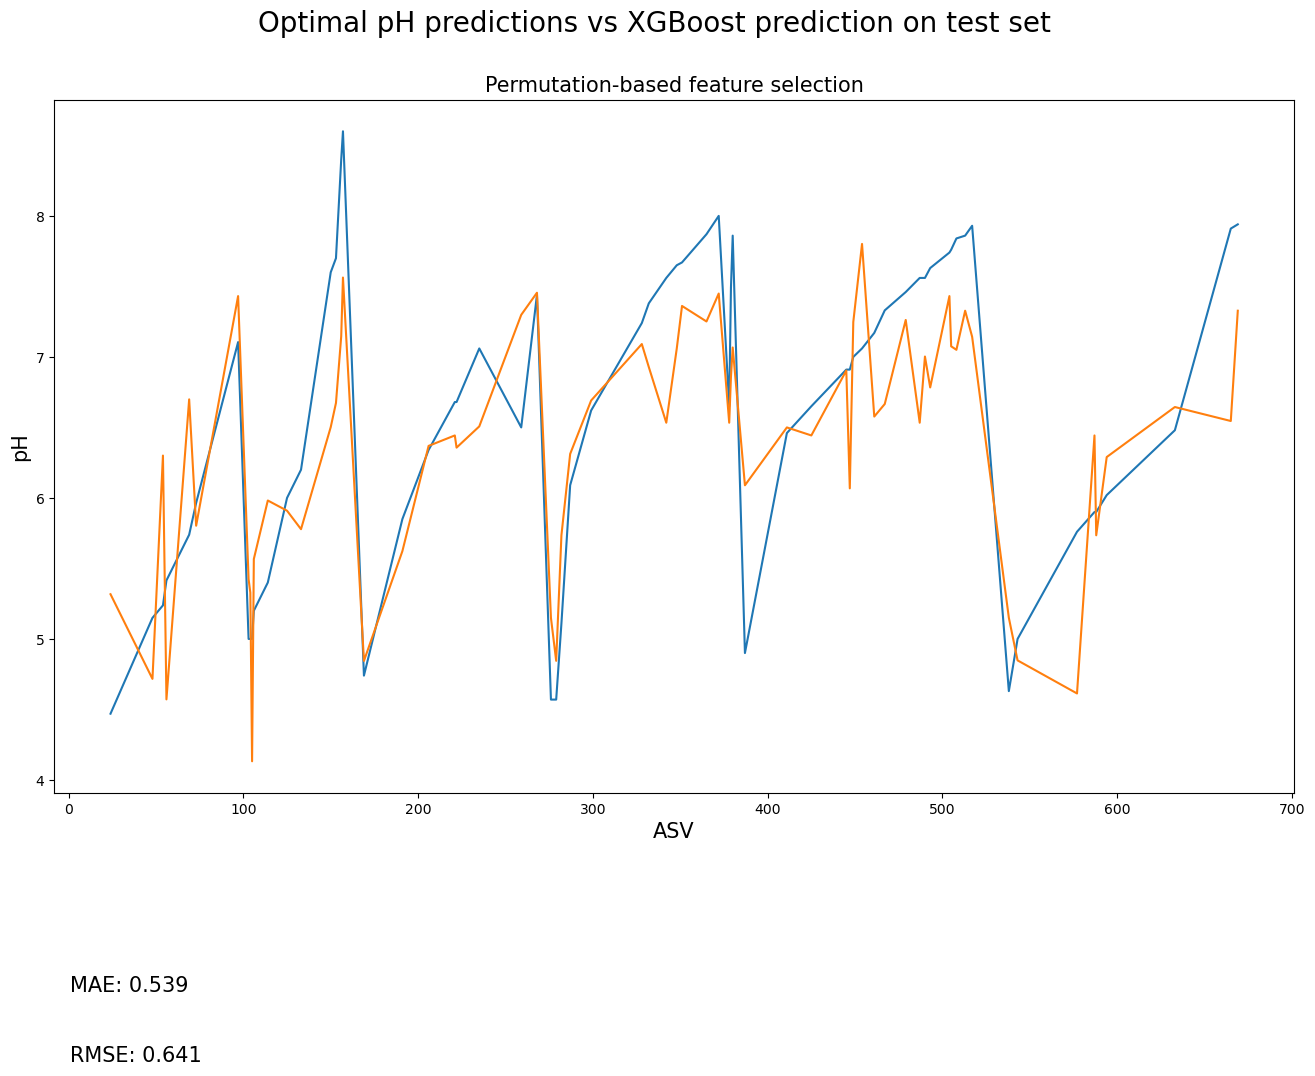

In [52]:
explainer = shap.TreeExplainer(model_perm_subset)
shap_values_forFE = explainer.shap_values(X_perm_test)
shap_values = explainer(X_perm_test)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals + shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y_perm_test)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost, permutation)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)
#shap_valuecomp = shap_valuecomp.sort_values(by='pH.preference', ascending=False).reset_index()

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH (XGBoost, permutation)'], label = "line 1")

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs XGBoost prediction on test set", fontsize=20)
plt.title("Permutation-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 2, "RMSE: %.3f" % scores_perm_subset_RMSE, fontsize=15)
plt.text(1, 2.5, "MAE: %.3f" % scores_perm_subset_MAE, fontsize=15)

plt.savefig('perm_testset.png')
plt.show()

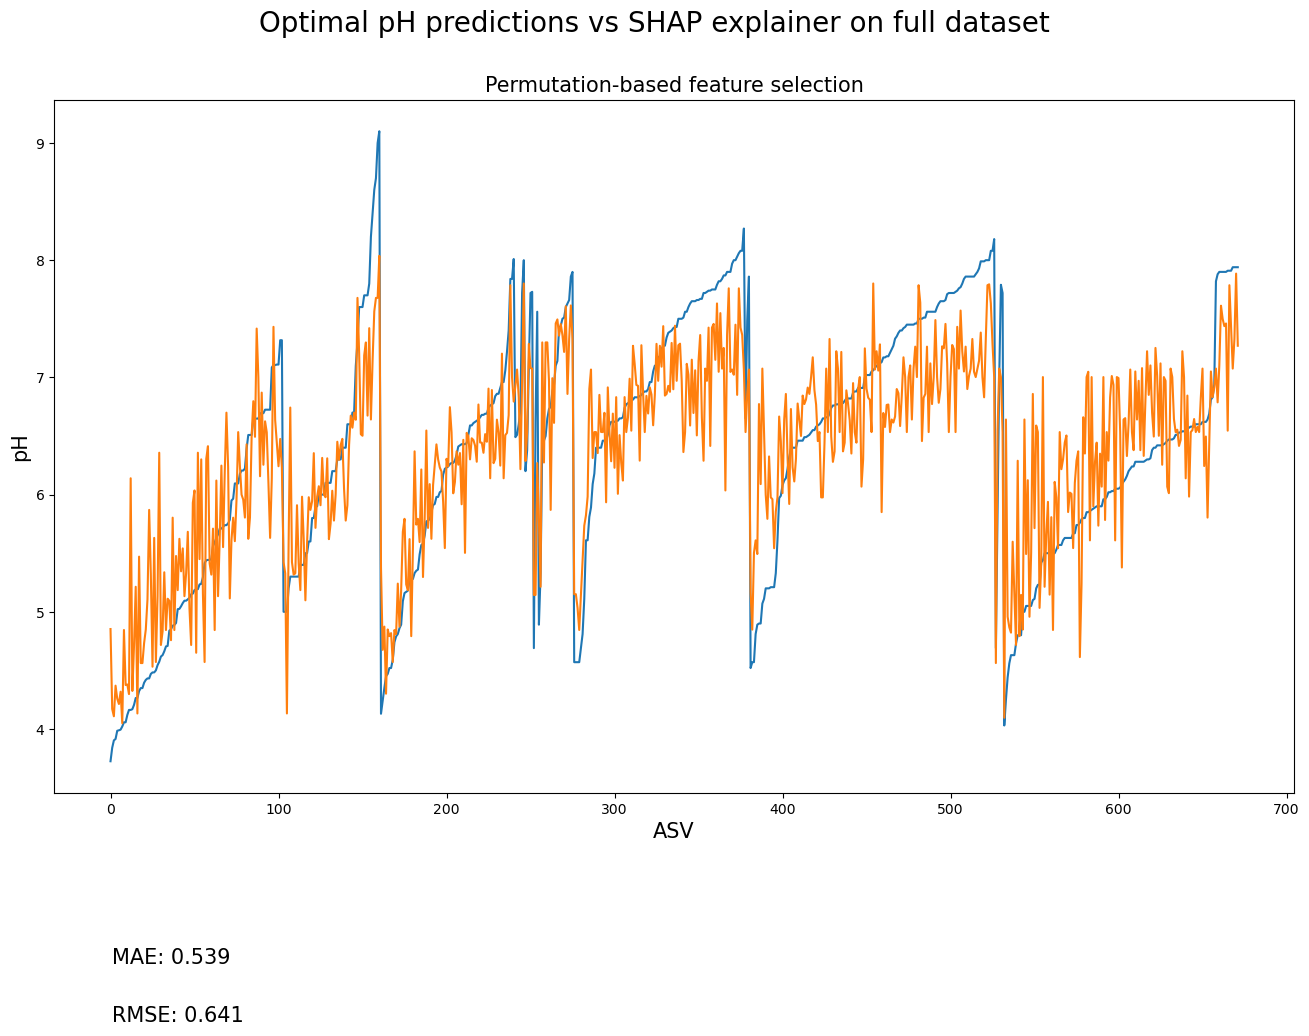

In [53]:
explainer = shap.TreeExplainer(model_perm_subset)
shap_values_forFE = explainer.shap_values(X_perm)
shap_values = explainer(X_perm)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals + shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums = shap_value_sums.to_numpy()
y_df = pd.DataFrame(y)
shap_valuecomp = y_df
shap_valuecomp['Predicted pH (XGBoost, permutation)'] = shap_value_sums

shap_valuecomp = shap_valuecomp.sort_index(ascending=True)
#shap_valuecomp = shap_valuecomp.sort_values(by='pH.preference', ascending=False).reset_index()

#shap_valuecomp.plot(use_index=True)
plt.figure(figsize=(16, 9))
plt.plot(shap_valuecomp['pH.preference'], label = "line 2")
plt.plot(shap_valuecomp['Predicted pH (XGBoost, permutation)'], label = "line 1")

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("Permutation-based feature selection", fontsize = 15)

#plt.text(1, 2, r'an equation: $E=mc^2$', fontsize=15)
plt.text(1, 1.5, "RMSE: %.3f" % scores_perm_subset_RMSE, fontsize=15)
plt.text(1, 2.0, "MAE: %.3f" % scores_perm_subset_MAE, fontsize=15)

plt.savefig('perm_fullset.png')
plt.show()

In [54]:
test_set_graph_perm = perm_predicted_vs_true
test_set_graph_perm

pH.preference  Predicted pH (XGBoost, permutation)
24        4.469885                             5.317137
48        5.149540                             4.716771
54        5.238161                             6.300412
56        5.414971                             4.571418
69        5.738965                             6.698975
..             ...                                  ...
588       5.900000                             5.735041
594       6.020000                             6.289732
633       6.480000                             6.644631
665       7.910000                             6.545453
669       7.940000                             7.327577

[68 rows x 2 columns]

In [55]:
test_set_graph_perm.index.rename('ASV', inplace=True)
test_set_graph_perm

pH.preference  Predicted pH (XGBoost, permutation)
ASV                                                    
24        4.469885                             5.317137
48        5.149540                             4.716771
54        5.238161                             6.300412
56        5.414971                             4.571418
69        5.738965                             6.698975
..             ...                                  ...
588       5.900000                             5.735041
594       6.020000                             6.289732
633       6.480000                             6.644631
665       7.910000                             6.545453
669       7.940000                             7.327577

[68 rows x 2 columns]

In [56]:
test_set_graph_perm.to_csv('perm_test_graph.csv')

In [57]:
full_set_graph_perm = shap_valuecomp
full_set_graph_perm.index.rename('ASV', inplace=True)
full_set_graph_perm.to_csv('perm_full_graph.csv')

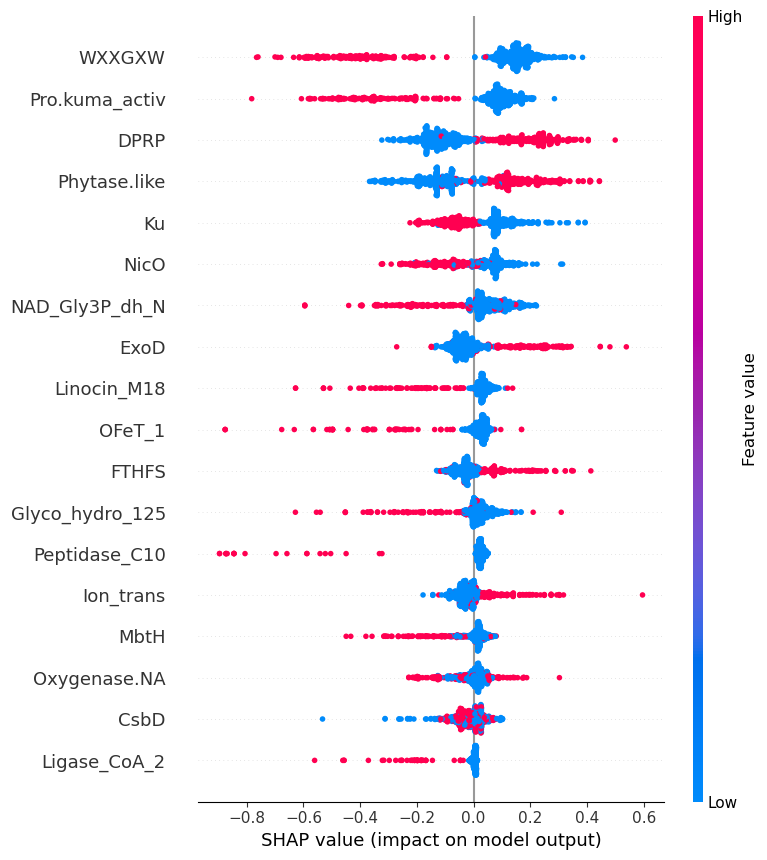

In [58]:
fig = shap.summary_plot(shap_values, X_perm, show=False, max_display=30)
plt.savefig('perm_summary.png')

In [59]:
print('Mean MAE of original model: %.3f Mean MAE of model based on perm subset: %.3f' % (scores_MAE, scores_perm_subset_MAE))
print('Mean RMSE of model based on perm is %.3f lower than RMSE of original model' % (scores_MAE-scores_perm_subset_MAE)) 
print('Mean RMSE of original model: %.3f Mean RMSE of model based on perm subset: %.3f' % (scores_RMSE, scores_perm_subset_RMSE))
print('Mean RMSE of model based on perm is %.3f lower than RMSE of original model' % (scores_RMSE-scores_perm_subset_RMSE)) 

Mean MAE of original model: 0.534 Mean MAE of model based on perm subset: 0.539
Mean RMSE of model based on perm is -0.005 lower than RMSE of original model
Mean RMSE of original model: 0.673 Mean RMSE of model based on perm subset: 0.641
Mean RMSE of model based on perm is 0.032 lower than RMSE of original model


In [60]:
# 1.2.6.1  Correlations to help with permutation feature selection
# 相关性有助于选择排列特征
# It's useful to look at correlations when selecting features from a permutation test. I would recommend removing features that have a low perm score and also a low correltaion with other features. I've not done that here yet; also, there are too many features to make a decent looking correlation table
# 从 permutation 检验中选择特征时，查看相关性非常有用。我建议删除 perm 分数低且与其他特征相关性低的特征。我在这里还没有这样做；此外，特征太多，无法制作出漂亮的相关表
'''
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[X_train.columns[sorted_idx]])
'''

'\ndef correlation_heatmap(train):\n    correlations = train.corr()\n\n    fig, ax = plt.subplots(figsize=(10,10))\n    sns.heatmap(correlations, vmax=1.0, center=0, fmt=\'.2f\', cmap="YlGnBu",\n                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}\n                )\n    plt.show();\n    \ncorrelation_heatmap(X_train[X_train.columns[sorted_idx]])\n'

In [61]:
# ## Feature Selection Method Three
# 特征选择方法三
# ### SHAP values
#
# By now, we've used SHAP values to "un-blackbox" our models, but you can actually use it as a feature selection method on its own! This section will also review a few other cool things you can do to examine ouputs on a prediction-by-prediction basis.
# 到目前为止，我们已经使用 SHAP 值来 "消除 "模型的 "黑箱"，但实际上您还可以将其作为一种特征选择方法单独使用！本节还将介绍其他一些很酷的方法，您可以在逐个预测的基础上检查输出结果。
#
# See https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30
#
# See https://towardsdatascience.com/black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d
#
# See https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
#
# See https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
explainer = shap.TreeExplainer(model_perm_subset)
shap_values_forFE = explainer.shap_values(X_perm)
shap_values = explainer(X_perm)

# create a 2D numpy array
arr = shap_values.values
# sum of each row
row_totals = arr.sum(axis=1)
row_totals = row_totals + shap_values[0].base_values
# display the array and the sum
#print(arr)
#print("Sum of each row:", row_totals)

In [62]:
shap_value_sums = pd.DataFrame(row_totals, columns = ['Shap_pH_prediction'])
shap_value_sums

Shap_pH_prediction
0              4.852830
1              4.170667
2              4.108522
3              4.369669
4              4.258852
..                  ...
667            7.441543
668            7.075058
669            7.327579
670            7.885403
671            7.269920

[672 rows x 1 columns]

In [63]:
y_df = pd.DataFrame(y)
shap_valuecomp=pd.merge(y_df,shap_value_sums,left_index=True, right_index=True)
shap_valuecomp

pH.preference  Shap_pH_prediction
0         3.724741            4.852830
1         3.839540            4.170667
2         3.902705            4.108522
3         3.914741            4.369669
4         3.984741            4.258852
..             ...                 ...
667       7.910000            7.441543
668       7.940000            7.075058
669       7.940000            7.327579
670       7.940000            7.885403
671       7.940000            7.269920

[672 rows x 2 columns]

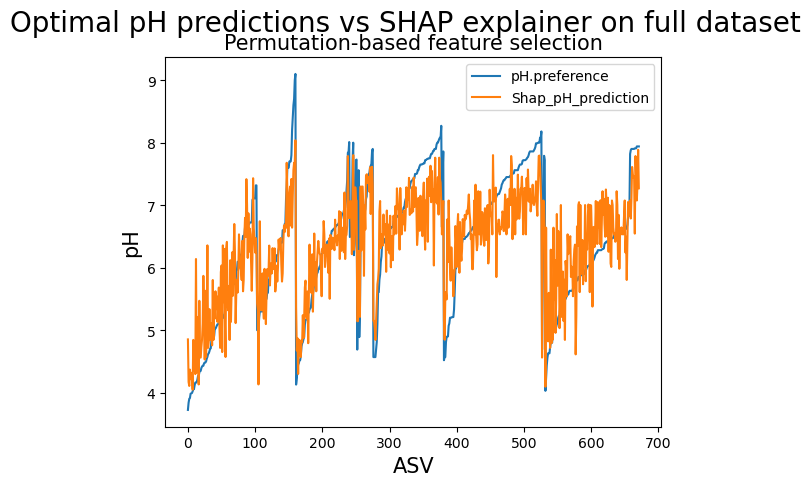

In [64]:
shap_valuecomp.plot(use_index=True) # 暂时没查到，但应该是跟matplotlib一样的绘图函数。

plt.xlabel("ASV", fontsize = 15)
plt.ylabel("pH", fontsize = 15)
plt.suptitle("Optimal pH predictions vs SHAP explainer on full dataset", fontsize=20)
plt.title("Permutation-based feature selection", fontsize = 15)

plt.show()

In [65]:
def shap_feature_ranking(data, shap_values, columns=[]):
    if not columns: columns = data.columns.tolist()     # If columns are not given, take all columns
    
    c_idxs = []
    for column in columns: c_idxs.append(data.columns.get_loc(column))  # Get column locations for desired columns in given dataframe
    if isinstance(shap_values, list):   # If shap values is a list of arrays (i.e., several classes)
        means = [np.abs(shap_values[class_][:, c_idxs]).mean(axis=0) for class_ in range(len(shap_values))]  # Compute mean shap values per class 
        shap_means = np.sum(np.column_stack(means), 1)  # Sum of shap values over all classes 
    else:                               # Else there is only one 2D array of shap values
        assert len(shap_values.shape) == 2, 'Expected two-dimensional shap values array.'
        shap_means = np.abs(shap_values).mean(axis=0)
    
    # Put into dataframe along with columns and sort by shap_means, reset index to get ranking
    df_ranking = pd.DataFrame({'feature': columns, 'mean_shap_value': shap_means}).sort_values(by='mean_shap_value', ascending=False).reset_index(drop=True)
    df_ranking.index += 1
    return df_ranking

In [66]:
feature_names_shap = X_perm_train.columns.tolist()
shap_feats = shap_feature_ranking(df, shap_values_forFE, columns=feature_names_shap) 
# df为输入的原始矩阵总表，shap_values_forFE为X_perm的结果（shap_values_forFE = explainer.shap_values(X_perm)）

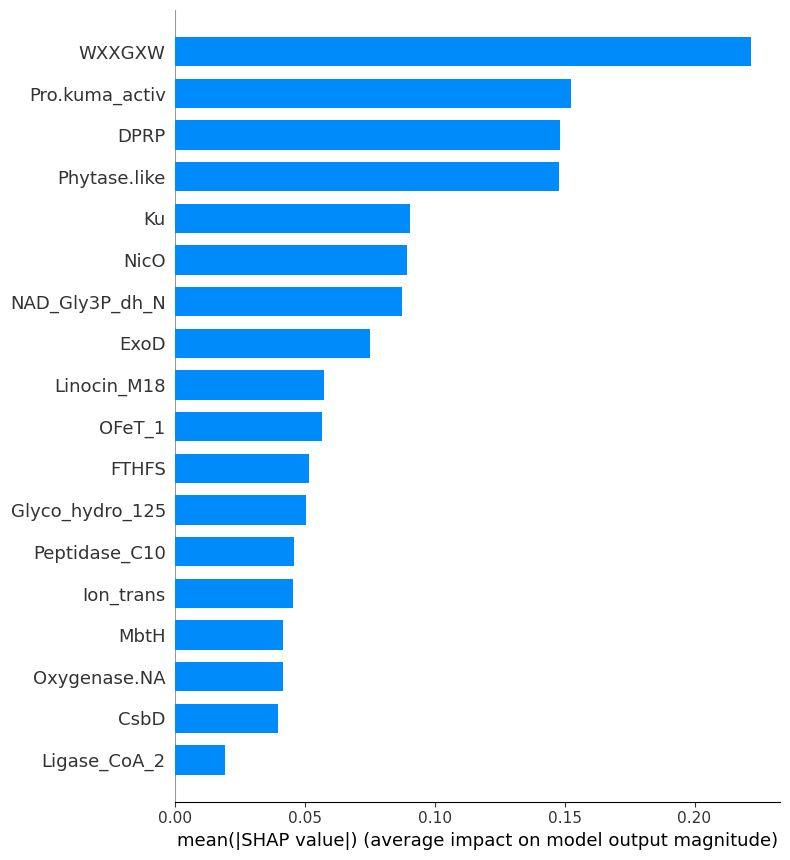

In [67]:
shap.summary_plot(shap_values,X_perm_test,plot_type="bar") # 哈哈，因为此时的shap_values为X_perm这块的，所以得用X_perm_test来，作者提供的用的X_test，所以报错。笑死。

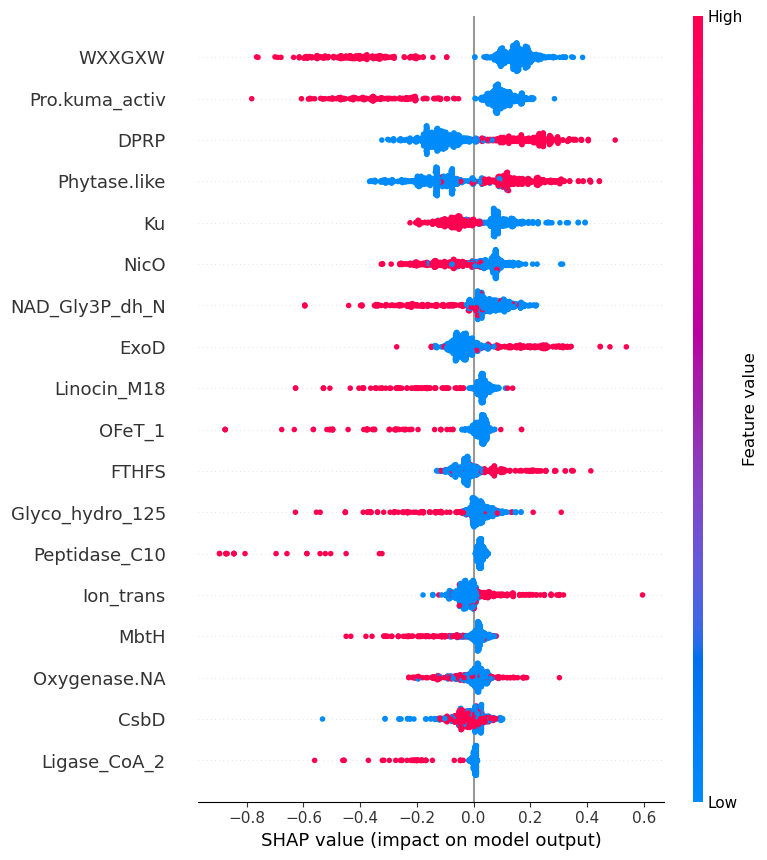

In [68]:
shap.summary_plot(shap_values, X_perm)

In [69]:
shap_values.base_values.shape # 我自己写的，想查看下shap_values里面的一维数组的元素个数。为672个。就是对应原始数据ASV的个数，即行数。

(672,)

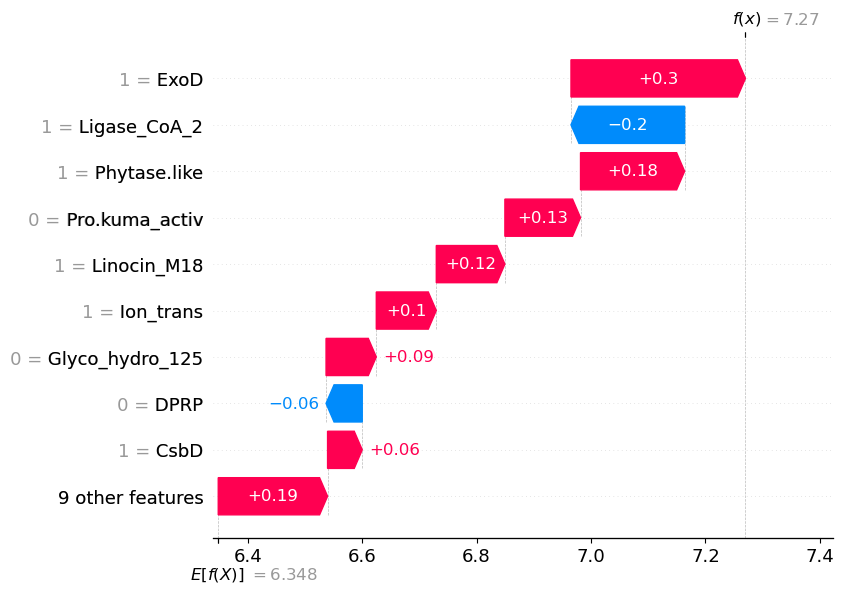

In [70]:
shap.plots.waterfall(shap_values[671]) # 查看最后一个特征对预测的贡献程度。
# 蓝色条显示某一特定特征在多大程度上降低了预测的值。
# 红条显示了一个特定的特征在多大程度上增加了预测值。

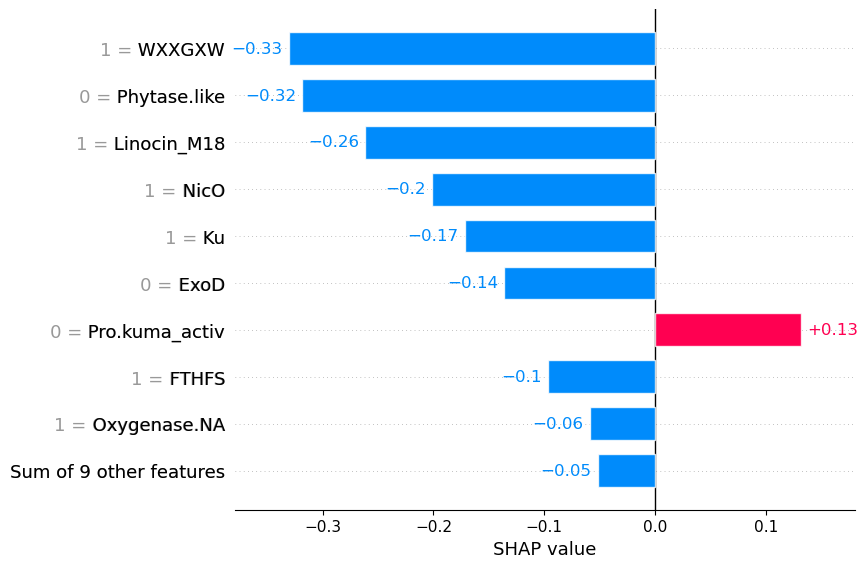

In [71]:
shap.plots.bar(shap_values[0], show_data=True)
# 将一行 SHAP 值传递给条形图函数会创建一个局部特征重要性图，
# 其中条形是每个特征的 SHAP 值。
# 其中特征值是否显示，是通过参数show_data控制，'Ture'表示特征值以灰色显示在特征名称的左侧。

In [72]:
expected_value = explainer.expected_value
print("The expected value is ", expected_value)

The expected value is  6.34835


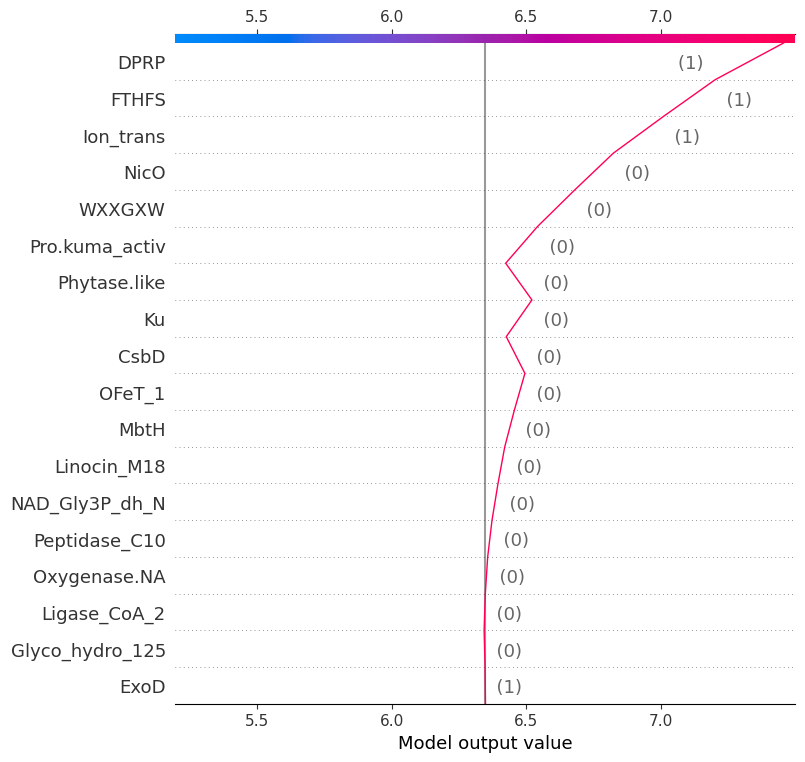

In [73]:
shap_values = explainer.shap_values(X_perm_test)[0] # 把X_test换成X_perm_test就不报错了
shap.decision_plot(expected_value, shap_values, X_perm_test) # 把X_test换成X_perm_test就不报错了
# SHAP 决策图显示复杂模型如何得出其预测（即模型如何做出决策）。决策图是 SHAP value 的文字表示，使其易于解读。
# 决策图显示的信息与力图基本相同，都可以有效地解释上述模型的预测。而且很容易识别出主要影响的大小和方向。
# 决策图中间灰色垂直直线标记了模型的基础值，彩色线是预测，表示每个特征是否将输出值移动到高于或低于平均预测的值。
# 特征值在预测线旁边以供参考。从图的底部开始，预测线显示 SHAP value 如何从基础值累积到图顶部的模型最终分数。

In [74]:
# 单个特征与目标变量之间的关系，以后再研究。
shap.force_plot(explainer.expected_value, shap_values[0:,], X_perm.iloc[0]) # 我将X替换为X_perm了

In [75]:
# shap.dependence_plot("AAL_decarboxy", shap_values, X_perm_test) # 我改为X_perm_test后，还是报错，
# 当然作者提供的代码也是报错。应该是索引不是基因名字符串而是0这样的index表示。shap.dependence_plot()函数不支持。
# 必须是str类型的。所以报错：TypeError: order must be str, not int
# 以后再说吧。

In [76]:
shap_feats # 这个是上面那个还没有去理解的函数的结果，
# 作者的代码显示剩332个基因名，而我这个只剩18个。因此，这个函数不适合我的数据应该。自己用的时候应该要去重写或者修改。

feature  mean_shap_value
1            WXXGXW         0.221843
2    Pro.kuma_activ         0.152456
3              DPRP         0.148084
4      Phytase.like         0.147636
5                Ku         0.090533
6              NicO         0.089309
7    NAD_Gly3P_dh_N         0.087380
8              ExoD         0.075015
9       Linocin_M18         0.057282
10           OFeT_1         0.056398
11            FTHFS         0.051359
12  Glyco_hydro_125         0.050350
13    Peptidase_C10         0.045586
14        Ion_trans         0.045450
15             MbtH         0.041353
16     Oxygenase.NA         0.041317
17             CsbD         0.039685
18     Ligase_CoA_2         0.019246

In [77]:
shap_mean = np.absolute(shap_values).mean()
shaplist_subset = shap_feats.loc[shap_feats['mean_shap_value'] > shap_mean]
shaplist_subset

feature  mean_shap_value
1          WXXGXW         0.221843
2  Pro.kuma_activ         0.152456
3            DPRP         0.148084
4    Phytase.like         0.147636
5              Ku         0.090533
6            NicO         0.089309
7  NAD_Gly3P_dh_N         0.087380

In [78]:
type(shaplist_subset)

shaplist_subset = shaplist_subset['feature'].tolist()

In [79]:
shaplist_subset.append('pH.preference')

In [80]:
shaplist_subset

['WXXGXW',
 'Pro.kuma_activ',
 'DPRP',
 'Phytase.like',
 'Ku',
 'NicO',
 'NAD_Gly3P_dh_N',
 'pH.preference']

In [81]:
shaplist_subset_df = df[shaplist_subset]
shaplist_subset_df

WXXGXW  Pro.kuma_activ  DPRP  Phytase.like  Ku  NicO  NAD_Gly3P_dh_N  \
0         1               0     0             0   1     1               0   
1         1               1     0             1   1     1               0   
2         1               1     0             0   0     0               1   
3         1               1     0             1   1     1               0   
4         1               1     0             0   1     1               0   
..      ...             ...   ...           ...  ..   ...             ...   
667       0               1     1             0   1     1               1   
668       0               0     1             0   0     0               0   
669       0               0     1             0   0     0               0   
670       0               0     1             1   0     1               0   
671       1               0     0             1   1     1               1   

     pH.preference  
0         3.724741  
1         3.839540  
2         3.902705  
3         3.914741  
4         3.984741  
..             ...  
667       7.910000  
668       7.940000  
669       7.940000  
670       7.940000  
671       7.940000  

[672 rows x 8 columns]

In [82]:
#Split data into training features and labels
X_shap, y_shap = shaplist_subset_df.loc[:, shaplist_subset_df.columns != 'pH.preference'], shaplist_subset_df['pH.preference']

In [83]:
test_size = 0.1
X_shap_train, X_shap_test, y_shap_train, y_shap_test = train_test_split(X_shap, y_shap, test_size=test_size, random_state=seed)

In [84]:
# Quick model
model_shap_subset = XGBRegressor(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_shap_subset.fit(X_shap_train, y_shap_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_shap_train, y_shap_train), (X_shap_test, y_shap_test)])

[0]	validation_0-rmse:5.65698	validation_1-rmse:5.90118
[1]	validation_0-rmse:5.38359	validation_1-rmse:5.62527
[2]	validation_0-rmse:5.12416	validation_1-rmse:5.36433
[3]	validation_0-rmse:4.87807	validation_1-rmse:5.11584
[4]	validation_0-rmse:4.64457	validation_1-rmse:4.88085
[5]	validation_0-rmse:4.42317	validation_1-rmse:4.65638
[6]	validation_0-rmse:4.21316	validation_1-rmse:4.44447
[7]	validation_0-rmse:4.01401	validation_1-rmse:4.24306
[8]	validation_0-rmse:3.82520	validation_1-rmse:4.05194
[9]	validation_0-rmse:3.64625	validation_1-rmse:3.86971
[10]	validation_0-rmse:3.47660	validation_1-rmse:3.69845
[11]	validation_0-rmse:3.31578	validation_1-rmse:3.53549
[12]	validation_0-rmse:3.16348	validation_1-rmse:3.38079
[13]	validation_0-rmse:3.01920	validation_1-rmse:3.23425
[14]	validation_0-rmse:2.88275	validation_1-rmse:3.09526
[15]	validation_0-rmse:2.75346	validation_1-rmse:2.96403
[16]	validation_0-rmse:2.63117	validation_1-rmse:2.83912
[17]	validation_0-rmse:2.51555	validation

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[111]	validation_0-rmse:0.80096	validation_1-rmse:0.74373
[112]	validation_0-rmse:0.80048	validation_1-rmse:0.74311
[113]	validation_0-rmse:0.80003	validation_1-rmse:0.74269
[114]	validation_0-rmse:0.79961	validation_1-rmse:0.74245
[115]	validation_0-rmse:0.79922	validation_1-rmse:0.74210
[116]	validation_0-rmse:0.79886	validation_1-rmse:0.74203
[117]	validation_0-rmse:0.79859	validation_1-rmse:0.74191
[118]	validation_0-rmse:0.79827	validation_1-rmse:0.74174
[119]	validation_0-rmse:0.79803	validation_1-rmse:0.74164
[120]	validation_0-rmse:0.79782	validation_1-rmse:0.74139
[121]	validation_0-rmse:0.79763	validation_1-rmse:0.74115
[122]	validation_0-rmse:0.79745	validation_1-rmse:0.74100
[123]	validation_0-rmse:0.79729	validation_1-rmse:0.74078
[124]	validation_0-rmse:0.79713	validation_1-rmse:0.74072
[125]	validation_0-rmse:0.79688	validation_1-rmse:0.74067
[126]	validation_0-rmse:0.79665	validation_1-rmse:0.74060
[127]	validation_0-rmse:0.79651	validation_1-rmse:0.74047
[128]	validati

[253]	validation_0-rmse:0.78757	validation_1-rmse:0.72409
[254]	validation_0-rmse:0.78754	validation_1-rmse:0.72388
[255]	validation_0-rmse:0.78750	validation_1-rmse:0.72372
[256]	validation_0-rmse:0.78747	validation_1-rmse:0.72358
[257]	validation_0-rmse:0.78744	validation_1-rmse:0.72341
[258]	validation_0-rmse:0.78742	validation_1-rmse:0.72331
[259]	validation_0-rmse:0.78739	validation_1-rmse:0.72315
[260]	validation_0-rmse:0.78737	validation_1-rmse:0.72304
[261]	validation_0-rmse:0.78735	validation_1-rmse:0.72298
[262]	validation_0-rmse:0.78733	validation_1-rmse:0.72282
[263]	validation_0-rmse:0.78730	validation_1-rmse:0.72267
[264]	validation_0-rmse:0.78728	validation_1-rmse:0.72258
[265]	validation_0-rmse:0.78725	validation_1-rmse:0.72243
[266]	validation_0-rmse:0.78724	validation_1-rmse:0.72230
[267]	validation_0-rmse:0.78722	validation_1-rmse:0.72227
[268]	validation_0-rmse:0.78720	validation_1-rmse:0.72218
[269]	validation_0-rmse:0.78719	validation_1-rmse:0.72219
[270]	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [85]:
# Predict the model
pred_shap_subset = model_shap_subset.predict(X_shap_test)
 
# MAE Computation
scores_shap_subset_MAE = mean_absolute_error(y_shap_test, pred_shap_subset)

# RMSE Computation
scores_shap_subset_RMSE = np.sqrt(mean_squared_error(y_shap_test, pred_shap_subset))
print("RMSE : % f, MAE : % f" % (scores_shap_subset_RMSE, scores_shap_subset_MAE))

RMSE :  0.721795, MAE :  0.571810


In [86]:
'''
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_shap_subset_MAE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores_shap_subset_MAE = np.absolute(scores_shap_subset_MAE)

#scores_shap_subset_RMSE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
#scores_shap_subset_RMSE = np.absolute(scores_shap_subset_RMSE)

print('Mean MAE: %.3f (%.3f)' % (scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))

#print('Mean RMSE: %.3f (%.3f)' % (scores_shap_subset_RMSE.mean(), scores_shap_subset_RMSE.std()))

print('Mean MAE of original model: %.3f (%.3f) Mean MAE of model based on gain subset: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std(), scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_MAE.mean()-scores_shap_subset_MAE.mean())) 
print('Mean RMSE of original model: %.3f (%.3f) Mean RMSE of model based on gain subset: %.3f' % (scores_RMSE.mean(), scores_RMSE.std(), scores_shap_subset_RMSE))
print('Mean RMSE of model based on gain is %.3f lower than RMSE of original model' % (scores_RMSE.mean()-scores_shap_subset_RMSE)) 
'''

"\n# define model evaluation method\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# evaluate model\nscores_shap_subset_MAE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)\n# force scores to be positive\nscores_shap_subset_MAE = np.absolute(scores_shap_subset_MAE)\n\n#scores_shap_subset_RMSE = cross_val_score(model_shap_subset, X_shap, y_shap, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)\n# force scores to be positive\n#scores_shap_subset_RMSE = np.absolute(scores_shap_subset_RMSE)\n\nprint('Mean MAE: %.3f (%.3f)' % (scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))\n\n#print('Mean RMSE: %.3f (%.3f)' % (scores_shap_subset_RMSE.mean(), scores_shap_subset_RMSE.std()))\n\nprint('Mean MAE of original model: %.3f (%.3f) Mean MAE of model based on gain subset: %.3f (%.3f)' % (scores_MAE.mean(), scores_MAE.std(), scores_shap_subset_MAE.mean(), scores_shap_subset_MAE.std()))\nprint('Mean RMSE of m

In [87]:
print('Mean MAE of original model: %.3f Mean MAE of model based on shap subset: %.3f' % (scores_MAE, scores_shap_subset_MAE))
print('Mean RMSE of model based on shap is %.3f lower than RMSE of original model' % (scores_MAE-scores_shap_subset_MAE)) 
print('Mean RMSE of original model: %.3f Mean RMSE of model based on shap subset: %.3f' % (scores_RMSE, scores_shap_subset_RMSE))
print('Mean RMSE of model based on shap is %.3f lower than RMSE of original model' % (scores_RMSE-scores_shap_subset_RMSE)) 

Mean MAE of original model: 0.534 Mean MAE of model based on shap subset: 0.572
Mean RMSE of model based on shap is -0.038 lower than RMSE of original model
Mean RMSE of original model: 0.673 Mean RMSE of model based on shap subset: 0.722
Mean RMSE of model based on shap is -0.048 lower than RMSE of original model


In [88]:
# 1.4  Feature Selection Method Four
# 1.4 特征选择方法四
# 1.4.1  Boruta algorithm
# 1.4.1 Boruta 算法
# Note, however, Boruta works well on random forests but poorly on boosted models (such as the XGBoost we have been using here) and neural networks. Its methodology is fairly similar to the permutation-based model.
# 然而，需要注意的是，Boruta 算法在随机森林上效果很好，但在提升模型（如我们在此使用的 XGBoost）和神经网络上效果不佳。其方法与基于置换的模型相当类似。
# 1.4.2  If you are using a neural network or boosted model, ship forward to the BoostARoota section
# 1l.4.2 如果您使用的是神经网络或提升模型，请转到 BoostARoota 部分
# see https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a
# see https://www.kaggle.com/code/ajaysamp/boruta-beats-em-all-new-look-at-feature-selection/notebook
from boruta import BorutaPy

# define Boruta feature selection method
# 确定 Boruta 特征选择方法
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

In [89]:
type(feat_selector)

boruta.boruta_py.BorutaPy

In [90]:
# find all relevant features
# 找到所有相关功能
feat_selector.fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	332
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	332
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	332
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	332
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	332
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	332
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	332
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	269
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	58
Rejected: 	269
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	58
Rejected: 	269
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	58
Rejected: 	269
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	39
Rejected: 	284
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	39
Rejected: 	284
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	39
Rejected: 	284
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	39
Rejected: 	284
Iteration: 	16 / 100
Confirmed: 	11
Tenta

BorutaPy(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                callbacks=None, colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=0.6,
                                early_stopping_rounds=None,
                                enable_categorical=False, eta=0.03,
                                eval_metric=None, gamma=0, gpu_id=-1,
                                grow_policy='depthwise', importance_type=None,
                                interaction_constraints='',
                                learning_rate=0.0299999993, max_bin=256,
                                max_cat_to_onehot=4, max_delta_step=0,
                                max_depth=5, max_leaves=0, min_child_weight=10,
                                missing=nan, monotone_constraints='()',
                                n_estimators=167, n_jobs=0, num_parallel_tree=1,
                                predictor='auto', random_state=513433081,
   

In [91]:
# check selected features
# 检查选择的特征
feat_selector.support_
accept = X.columns[feat_selector.support_].to_list()

# check ranking of features
# 检查特征排序
feat_selector.ranking_

# call transform() on X to filter it down to selected features
# 在 X 上调用 transform() 以筛选出所选特征
X_filtered = feat_selector.transform(X_train.values)

In [92]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(list(X_train.columns), 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: X23S_rRNA_IVP             Rank: 205,  Keep: False
Feature: X5_nucleotid_C            Rank: 98,  Keep: False
Feature: X5.FTHF_cyc.lig           Rank: 56,  Keep: False
Feature: AA_permease               Rank: 182,  Keep: False
Feature: AAA_25                    Rank: 29,  Keep: False
Feature: AAA_assoc_C               Rank: 1,  Keep: True
Feature: AAL_decarboxy             Rank: 23,  Keep: False
Feature: ABATE                     Rank: 103,  Keep: False
Feature: Abhydrolase_11            Rank: 255,  Keep: False
Feature: AbiEii                    Rank: 113,  Keep: False
Feature: AbrB                      Rank: 213,  Keep: False
Feature: AcetylCoA_hyd_C           Rank: 193,  Keep: False
Feature: Acetyltransf_7            Rank: 258,  Keep: False
Feature: Acetyltransf_9            Rank: 257,  Keep: False
Feature: Acid_PPase                Rank: 297,  Keep: False
Feature: ActD                      Rank: 229,  Keep: False
Feature: Acylphosphatase           Rank: 202,  Keep: False
Feat

In [93]:
accept = X.columns[feat_selector.support_].to_list()
accept.insert(0, "pH.preference")
accept

['pH.preference',
 'AAA_assoc_C',
 'CorA',
 'Cys_rich_CPXG',
 'DctP',
 'DPRP',
 'Glucodextran_N',
 'Gpr1_Fun34_YaaH',
 'Linocin_M18',
 'NusG',
 'OFeT_1',
 'Peptidase_C10',
 'Phosphoesterase',
 'Pro.kuma_activ',
 'TFR_dimer',
 'WXXGXW',
 'Ytca']

In [94]:
new_x = df[accept]

In [95]:
X_new, y_new = new_x.loc[:, new_x.columns != 'pH.preference'], df['pH.preference']

In [96]:
X_t, X_val, y_t, y_val = train_test_split(X_new, y_new, random_state=42)

In [97]:
model = XGBRegressor(
    max_depth=17,
    n_estimators=2110,
    colsample_bytree=0.5,
    min_child_weight=330,
    subsample=0.8,    
    eta=0.2,
    objective='reg:squarederror',
    tree_method='gpu_hist')


model.fit(
    X_t, 
    y_t, 
    eval_metric="rmse", 
    eval_set=[(X_t, y_t), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds=10)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-rmse:4.84643	validation_1-rmse:4.70783
[1]	validation_0-rmse:3.93506	validation_1-rmse:3.79514
[2]	validation_0-rmse:3.21302	validation_1-rmse:3.07202
[3]	validation_0-rmse:2.64500	validation_1-rmse:2.50353
[4]	validation_0-rmse:2.21836	validation_1-rmse:2.07745
[5]	validation_0-rmse:1.89495	validation_1-rmse:1.75607
[6]	validation_0-rmse:1.64988	validation_1-rmse:1.51497
[7]	validation_0-rmse:1.46877	validation_1-rmse:1.33998
[8]	validation_0-rmse:1.34548	validation_1-rmse:1.22420
[9]	validation_0-rmse:1.25667	validation_1-rmse:1.14422
[10]	validation_0-rmse:1.19782	validation_1-rmse:1.09428
[11]	validation_0-rmse:1.15809	validation_1-rmse:1.06315
[12]	validation_0-rmse:1.12887	validation_1-rmse:1.04286
[13]	validation_0-rmse:1.11220	validation_1-rmse:1.03322
[14]	validation_0-rmse:1.10373	validation_1-rmse:1.02939
[15]	validation_0-rmse:1.09640	validation_1-rmse:1.02719
[16]	validation_0-rmse:1.09253	validation_1-rmse:1.02682
[17]	validation_0-rmse:1.08980	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=330,
             missing=nan, monotone_constraints='()', n_estimators=2110,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [98]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [99]:
# 这块代码如果报错，可以再试几次，可能就不报错了。这块代码很吃CPU。能飙到100%利用率。
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)


In [100]:
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.877 (0.070)


In [101]:
#1.5  Feature Selection Method Five¶
#1.5 特征选择方法 5
#1.5.1  BoostARoota
#This is basically Boruta algo for boosted Models
#这基本上就是 Boruta algo for boosted Models
#see https://morioh.com/p/9ec0e787a417
X_br = pd.get_dummies(X)
X_br

X23S_rRNA_IVP  X5_nucleotid_C  X5.FTHF_cyc.lig  AA_permease  AAA_25  \
0                1               0                1            0       1   
1                1               0                1            1       1   
2                0               1                1            1       0   
3                1               0                0            1       1   
4                1               0                0            1       0   
..             ...             ...              ...          ...     ...   
667              0               0                1            1       1   
668              0               0                1            0       1   
669              1               1                0            0       1   
670              0               1                1            0       1   
671              0               1                1            0       1   

     AAA_assoc_C  AAL_decarboxy  ABATE  Abhydrolase_11  AbiEii  ...  YicC_N  \
0              1              0      0               1       0  ...       1   
1              1              0      0               0       1  ...       1   
2              0              0      0               1       0  ...       1   
3              1              1      1               1       1  ...       0   
4              1              1      1               1       1  ...       1   
..           ...            ...    ...             ...     ...  ...     ...   
667            0              0      1               1       0  ...       0   
668            0              0      0               0       0  ...       0   
669            0              0      0               0       1  ...       1   
670            0              0      0               0       0  ...       1   
671            0              0      1               1       1  ...       1   

     YiiD_C  YitT_membrane  YlxR  YqcI_YcgG  Ysc84  Ytca  ZapB  zf.CDGSH  \
0         0              0     1          0      0     1     0         1   
1         0              0     0          0      1     1     0         1   
2         1              0     0          0      1     1     1         0   
3         0              0     0          1      1     1     1         1   
4         0              0     0          1      1     1     0         0   
..      ...            ...   ...        ...    ...   ...   ...       ...   
667       0              1     0          0      0     0     0         1   
668       0              0     0          0      1     0     1         0   
669       0              0     0          0      0     0     0         0   
670       0              0     1          0      1     0     0         0   
671       0              0     1          1      0     0     0         0   

     Zn_peptidase_2  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
667               0  
668               0  
669               1  
670               0  
671               0  

[672 rows x 332 columns]

In [102]:
#OHE the variables - BoostARoota may break if not done
# X_br = pd.get_dummies(X)
# type(X_br)

[14:50:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  1
[14:50:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  2
[14:50:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sil

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Round:  2  iteration:  3
[14:50:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  4
[14:50:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  5
[14:50:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


[14:50:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  3  iteration:  5
[14:50:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  3  iteration:  6
[14:50:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sil

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


[14:50:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  6
[14:50:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  7
[14:50:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sil

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[59]	validation_0-rmse:0.65226	validation_1-rmse:0.82876
[60]	validation_0-rmse:0.64297	validation_1-rmse:0.81985
[61]	validation_0-rmse:0.63379	validation_1-rmse:0.81048
[62]	validation_0-rmse:0.62546	validation_1-rmse:0.80412
[63]	validation_0-rmse:0.61790	validation_1-rmse:0.79564
[64]	validation_0-rmse:0.61127	validation_1-rmse:0.78820
[65]	validation_0-rmse:0.60454	validation_1-rmse:0.78206
[66]	validation_0-rmse:0.59800	validation_1-rmse:0.77663
[67]	validation_0-rmse:0.59185	validation_1-rmse:0.76826
[68]	validation_0-rmse:0.58638	validation_1-rmse:0.76329
[69]	validation_0-rmse:0.58104	validation_1-rmse:0.75550
[70]	validation_0-rmse:0.57606	validation_1-rmse:0.75046
[71]	validation_0-rmse:0.57100	validation_1-rmse:0.74680
[72]	validation_0-rmse:0.56587	validation_1-rmse:0.74452
[73]	validation_0-rmse:0.56158	validation_1-rmse:0.73959
[74]	validation_0-rmse:0.55771	validation_1-rmse:0.73477
[75]	validation_0-rmse:0.55377	validation_1-rmse:0.73296
[76]	validation_0-rmse:0.55033	

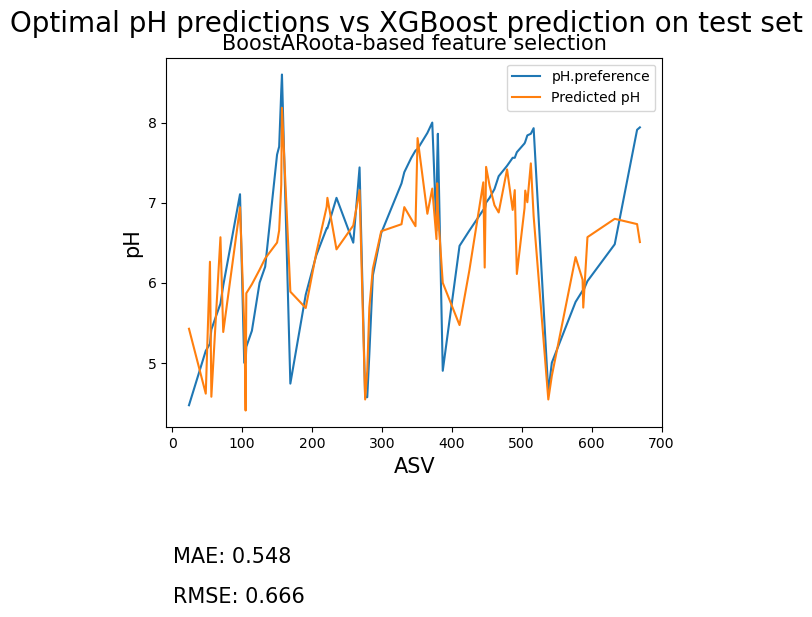

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580.

In [ ]:
#pip install tensorflow


In [ ]:
#pip install pydot

In [ ]:
#pip install graphviz

In [104]:
# 2  Feature Extraction
# see https://towardsdatascience.com/feature-extraction-techniques-d619b56e31be

# see https://machinelearningmastery.com/autoencoder-for-regression/

# https://github.com/tejasnp163/Dimensionality-Reduction-on-Wine-Dataset/blob/main/Wine%20Dataset%20Dimensionality%20Reduction.ipynb

# 2.1  Method One
# 2.1.1  Autoencoders
# train autoencoder for regression with no compression in the bottleneck layer
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

import pydot
import graphviz


In [105]:
X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(X, y, test_size=0.33, random_state=1)

In [106]:
# number of input columns
n_inputs = X.shape[1]
n_inputs

332

In [107]:
# scale data
t = MinMaxScaler()
t.fit(X_train_ae)
X_train_ae = t.transform(X_train_ae)
X_test_ae = t.transform(X_test_ae)

In [108]:
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)

In [109]:
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [110]:
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)

In [111]:
# output layer
output = Dense(n_inputs, activation='linear')(d)

In [112]:
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [113]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [114]:
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [115]:
#fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/400
38/38 - 1s - loss: 0.3271 - val_loss: 0.2347 - 1s/epoch - 38ms/step
Epoch 2/400
38/38 - 0s - loss: 0.1329 - val_loss: 0.1604 - 246ms/epoch - 6ms/step
Epoch 3/400
38/38 - 0s - loss: 0.1119 - val_loss: 0.1241 - 244ms/epoch - 6ms/step
Epoch 4/400
38/38 - 0s - loss: 0.1014 - val_loss: 0.1137 - 245ms/epoch - 6ms/step
Epoch 5/400
38/38 - 0s - loss: 0.0916 - val_loss: 0.1124 - 241ms/epoch - 6ms/step
Epoch 6/400
38/38 - 0s - loss: 0.0879 - val_loss: 0.1041 - 241ms/epoch - 6ms/step
Epoch 7/400
38/38 - 0s - loss: 0.0817 - val_loss: 0.0951 - 239ms/epoch - 6ms/step
Epoch 8/400
38/38 - 0s - loss: 0.0758 - val_loss: 0.0913 - 244ms/epoch - 6ms/step
Epoch 9/400
38/38 - 0s - loss: 0.0719 - val_loss: 0.0868 - 257ms/epoch - 7ms/step
Epoch 10/400
38/38 - 0s - loss: 0.0682 - val_loss: 0.0820 - 250ms/epoch - 7ms/step
Epoch 11/400
38/38 - 0s - loss: 0.0628 - val_loss: 0.0794 - 264ms/epoch - 7ms/step
Epoch 12/400
38/38 - 0s - loss: 0.0643 - val_loss: 0.0780 - 243ms/epoch - 6ms/step
Epoch 13/400
38

Epoch 100/400
38/38 - 0s - loss: 0.0209 - val_loss: 0.0390 - 260ms/epoch - 7ms/step
Epoch 101/400
38/38 - 0s - loss: 0.0216 - val_loss: 0.0403 - 252ms/epoch - 7ms/step
Epoch 102/400
38/38 - 0s - loss: 0.0204 - val_loss: 0.0402 - 247ms/epoch - 6ms/step
Epoch 103/400
38/38 - 0s - loss: 0.0210 - val_loss: 0.0410 - 256ms/epoch - 7ms/step
Epoch 104/400
38/38 - 0s - loss: 0.0216 - val_loss: 0.0390 - 257ms/epoch - 7ms/step
Epoch 105/400
38/38 - 0s - loss: 0.0207 - val_loss: 0.0399 - 264ms/epoch - 7ms/step
Epoch 106/400
38/38 - 0s - loss: 0.0204 - val_loss: 0.0389 - 246ms/epoch - 6ms/step
Epoch 107/400
38/38 - 0s - loss: 0.0209 - val_loss: 0.0398 - 252ms/epoch - 7ms/step
Epoch 108/400
38/38 - 0s - loss: 0.0206 - val_loss: 0.0404 - 257ms/epoch - 7ms/step
Epoch 109/400
38/38 - 0s - loss: 0.0210 - val_loss: 0.0408 - 240ms/epoch - 6ms/step
Epoch 110/400
38/38 - 0s - loss: 0.0205 - val_loss: 0.0402 - 266ms/epoch - 7ms/step
Epoch 111/400
38/38 - 0s - loss: 0.0215 - val_loss: 0.0437 - 237ms/epoch - 6

Epoch 198/400
38/38 - 0s - loss: 0.0172 - val_loss: 0.0366 - 243ms/epoch - 6ms/step
Epoch 199/400
38/38 - 0s - loss: 0.0168 - val_loss: 0.0356 - 240ms/epoch - 6ms/step
Epoch 200/400
38/38 - 0s - loss: 0.0157 - val_loss: 0.0347 - 243ms/epoch - 6ms/step
Epoch 201/400
38/38 - 0s - loss: 0.0153 - val_loss: 0.0338 - 241ms/epoch - 6ms/step
Epoch 202/400
38/38 - 0s - loss: 0.0161 - val_loss: 0.0355 - 246ms/epoch - 6ms/step
Epoch 203/400
38/38 - 0s - loss: 0.0157 - val_loss: 0.0350 - 247ms/epoch - 6ms/step
Epoch 204/400
38/38 - 0s - loss: 0.0163 - val_loss: 0.0357 - 255ms/epoch - 7ms/step
Epoch 205/400
38/38 - 0s - loss: 0.0165 - val_loss: 0.0352 - 251ms/epoch - 7ms/step
Epoch 206/400
38/38 - 0s - loss: 0.0155 - val_loss: 0.0342 - 252ms/epoch - 7ms/step
Epoch 207/400
38/38 - 0s - loss: 0.0160 - val_loss: 0.0359 - 246ms/epoch - 6ms/step
Epoch 208/400
38/38 - 0s - loss: 0.0159 - val_loss: 0.0345 - 251ms/epoch - 7ms/step
Epoch 209/400
38/38 - 0s - loss: 0.0159 - val_loss: 0.0348 - 254ms/epoch - 7

Epoch 296/400
38/38 - 0s - loss: 0.0133 - val_loss: 0.0326 - 239ms/epoch - 6ms/step
Epoch 297/400
38/38 - 0s - loss: 0.0145 - val_loss: 0.0339 - 254ms/epoch - 7ms/step
Epoch 298/400
38/38 - 0s - loss: 0.0139 - val_loss: 0.0331 - 267ms/epoch - 7ms/step
Epoch 299/400
38/38 - 0s - loss: 0.0138 - val_loss: 0.0338 - 273ms/epoch - 7ms/step
Epoch 300/400
38/38 - 0s - loss: 0.0132 - val_loss: 0.0335 - 244ms/epoch - 6ms/step
Epoch 301/400
38/38 - 0s - loss: 0.0133 - val_loss: 0.0326 - 252ms/epoch - 7ms/step
Epoch 302/400
38/38 - 0s - loss: 0.0129 - val_loss: 0.0326 - 287ms/epoch - 8ms/step
Epoch 303/400
38/38 - 0s - loss: 0.0128 - val_loss: 0.0330 - 252ms/epoch - 7ms/step
Epoch 304/400
38/38 - 0s - loss: 0.0130 - val_loss: 0.0320 - 252ms/epoch - 7ms/step
Epoch 305/400
38/38 - 0s - loss: 0.0126 - val_loss: 0.0322 - 252ms/epoch - 7ms/step
Epoch 306/400
38/38 - 0s - loss: 0.0125 - val_loss: 0.0322 - 251ms/epoch - 7ms/step
Epoch 307/400
38/38 - 0s - loss: 0.0128 - val_loss: 0.0324 - 253ms/epoch - 7

Epoch 394/400
38/38 - 0s - loss: 0.0115 - val_loss: 0.0316 - 283ms/epoch - 7ms/step
Epoch 395/400
38/38 - 0s - loss: 0.0122 - val_loss: 0.0327 - 272ms/epoch - 7ms/step
Epoch 396/400
38/38 - 0s - loss: 0.0121 - val_loss: 0.0328 - 264ms/epoch - 7ms/step
Epoch 397/400
38/38 - 0s - loss: 0.0123 - val_loss: 0.0325 - 265ms/epoch - 7ms/step
Epoch 398/400
38/38 - 0s - loss: 0.0127 - val_loss: 0.0330 - 289ms/epoch - 8ms/step
Epoch 399/400
38/38 - 0s - loss: 0.0112 - val_loss: 0.0322 - 267ms/epoch - 7ms/step
Epoch 400/400
38/38 - 0s - loss: 0.0114 - val_loss: 0.0318 - 277ms/epoch - 7ms/step


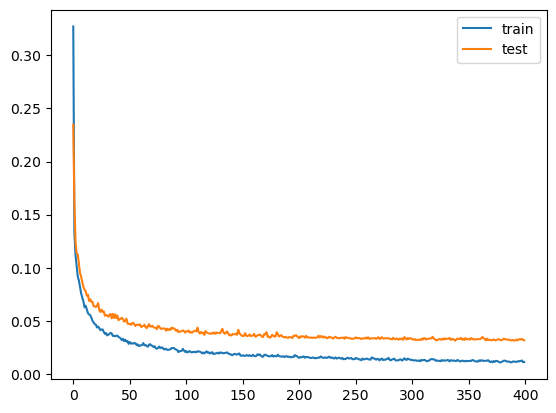

In [116]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [117]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [118]:
# save the encoder to file
encoder.save('encoder.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [119]:
# 2.2  Method Two
# 2.2.1  Locally Linear Embedding (LLE)
# Locally Linear Embedding (LLE)

# https://www.analyticsvidhya.com/blog/2021/02/a-quick-introduction-to-manifold-learning/

# https://towardsdatascience.com/lle-locally-linear-embedding-a-nifty-way-to-reduce-dimensionality-in-python-ab5c38336107
from sklearn.manifold import LocallyLinearEmbedding
import plotly.express as px # for data visualization

#lle= LocallyLinearEmbedding(n_neighbors=48, n_components=24, eigen_solver='dense')
lle= LocallyLinearEmbedding(n_neighbors=48, n_components=24, eigen_solver='dense')

X_transformed=lle.fit_transform(X)  #X_perm


In [120]:
X_train_lle, X_test_lle, y_train_lle, y_test_lle = train_test_split(X_transformed, y, test_size=0.10, random_state=seed)

In [121]:
clftre = XGBRegressor(learning_rate = 0.05, 
                      n_estimators=250, 
                      #max_depth=6, 
                      #method='gpu_hist', #sampling_method='uniform',
                      random_state=seed)
clftre.fit(X_train_lle,y_train_lle)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, ...)

In [122]:
# Predict the model
pred_X_trans = clftre.predict(X_test_lle)
 
# MAE Computation
pred_X_trans_MAE = mean_absolute_error(y_test_lle, pred_X_trans)

# RMSE Computation
pred_X_trans_RMSE = np.sqrt(mean_squared_error(y_test_lle, pred_X_trans))
print("RMSE : % f, MAE : % f" % (pred_X_trans_RMSE, pred_X_trans_MAE))

RMSE :  0.792944, MAE :  0.633958


In [123]:
# Create a 3D scatter plot
def Plot3D(X, y, plot_name):
    fig = px.scatter_3d(None, 
                        x=X[:,0], y=X[:,1], z=X[:,2],
                        color=y,
                        height=800, width=800
                       )
    # Update chart looks
    fig.update_layout(title_text=plot_name,
                      showlegend=False,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=1.75, z=1)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, 
                                  line=dict(color='black', width=0.1)))
    fig.update(layout_coloraxis_showscale=False)
    return fig

In [124]:
# Create a 2D scatter plot
def Plot2D(X, y, plot_name):
    # Create a scatter plot
    fig = px.scatter(None, x=X[:,0], y=X[:,1], 
                     labels={
                         "x": "Dimension 1",
                         "y": "Dimension 2",
                     },
                     
                     opacity=1, color=y, color_continuous_scale='sunset')

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    # Set figure title
    fig.update_layout(title_text=plot_name)

    # Update marker size
    fig.update_traces(marker=dict(size=5,
                                 line=dict(color='black', width=0.3)))
    return fig

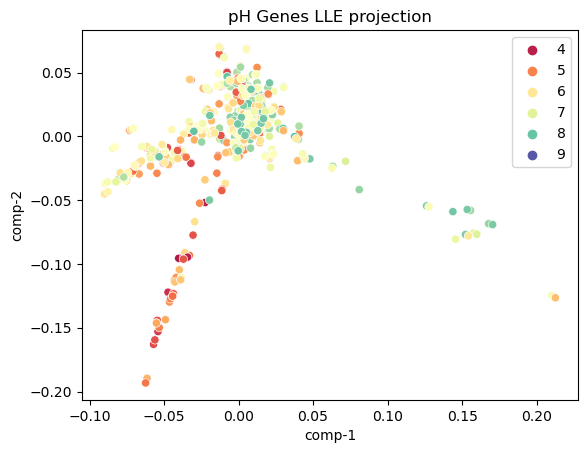

In [125]:
df_lle = pd.DataFrame()
df_lle["y"] = y
df_lle["comp-1"] = X_transformed[:,2]
df_lle["comp-2"] = X_transformed[:,3]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_lle.y.tolist(),
                palette=sns.color_palette("Spectral", 20,as_cmap=True),
                data=df_lle).set(title="pH Genes LLE projection")

plt.show()

In [126]:
Plot3D(X_transformed, y, 'Top 3 LLE')

In [127]:
# 2.2.2  Feature selection time
X_train_lle = pd.DataFrame(X_train_lle)
X_transformed = pd.DataFrame(X_transformed)
X_test_lle = pd.DataFrame(X_test_lle)

In [128]:
lle_perm_importance = permutation_importance(clftre, X_test_lle, y_test_lle, random_state=seed)

In [129]:
sorted_idx = lle_perm_importance.importances_mean.argsort()

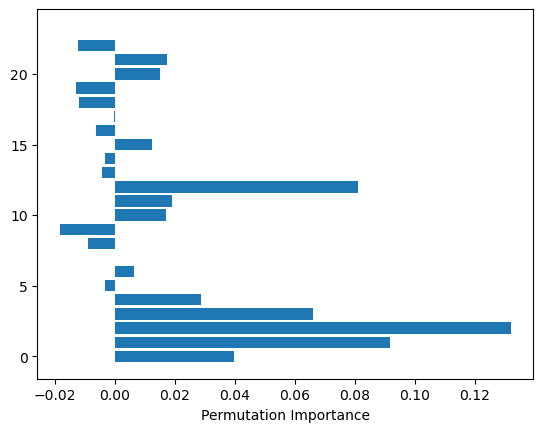

In [130]:
fig=plt.figure()
plt.barh(X_train_lle.columns[sorted_idx], lle_perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig('Perm_Importance_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()

In [131]:
lle_permlist = pd.DataFrame()
lle_permlist['PC'] = list(reversed(X_train_lle.columns[sorted_idx]))
lle_permlist['permimpt'] = list(reversed(lle_perm_importance.importances_mean[sorted_idx]))

In [132]:
# 2.2.3  Here we are removing all features below a set threshold
# 2.2.3 在这里，我们要删除所有低于设定阈值的特征。
# This will be heavily dependant on what your permutation list looks like and is somewhat arbitrary. However, you could introduce a grid search that reruns the model with a range of different tresholds and selects the one with the best performance.
# 这在很大程度上取决于您的排列列表，而且有些随意。不过，您可以引入网格搜索，用一系列不同的阈值重新运行模型，然后选择性能最好的阈值。
lle_perm_mean = lle_permlist['permimpt'].mean()
lle_permlist_subset = lle_permlist.loc[lle_permlist['permimpt'] > 0.005]

In [133]:
lle_permlist_subset_list = lle_permlist_subset['PC'].tolist()

In [134]:
lle_permlist.loc[lle_permlist['PC'].isin(lle_perm_importance)].to_csv('lle_selection.csv')

In [135]:
lle_df_all = pd.concat([y.reset_index(drop=True),X_transformed[lle_permlist_subset_list].reset_index(drop=True)], axis=1)

In [136]:
lle_df_train = pd.concat([y_train.reset_index(drop=True),X_train_lle[lle_permlist_subset_list].reset_index(drop=True)], axis=1)

In [137]:
lle_df_test = pd.concat([y_test.reset_index(drop=True),X_test_lle[lle_permlist_subset_list].reset_index(drop=True)], axis=1)

In [138]:
#Split data into training features and labels
X_lle_perm, y_lle_perm = lle_df_all.loc[:, lle_df_all.columns != 'pH.preference'], lle_df_all['pH.preference']

In [139]:
test_size = 0.1
X_lle_perm_train, X_lle_perm_test, y_lle_perm_train, y_lle_perm_test = train_test_split(X_lle_perm, y_lle_perm, test_size=test_size, random_state=seed)

In [140]:
# Quick model
model_lle_perm_subset = XGBRegressor(learning_rate = 0.04, n_estimators=100, max_depth=5, random_state=seed)

In [141]:
model_lle_perm_subset = XGBRegressor(
    max_depth=5,
    colsample_bytree=0.8,
    n_estimators=240,
    min_child_weight=10,
    subsample=0.9,    
    eta=.03,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.5,
    tree_method='gpu_hist'
    )

In [142]:
# Quick model
#model_pca_subset = XGBRegressor(learning_rate = 0.01, n_estimators=325, max_depth=5)
model_lle_perm_subset.fit(X_lle_perm_train, y_lle_perm_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.03,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0299999993, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=240, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [143]:
# Predict the model
pred_lle_subset = model_lle_perm_subset.predict(X_lle_perm_test)
 
# MAE Computation
scores_lle_subset_MAE = mean_absolute_error(y_lle_perm_test, pred_lle_subset)

# RMSE Computation
scores_lle_subset_RMSE = np.sqrt(mean_squared_error(y_lle_perm_test, pred_lle_subset))
print("RMSE : % f, MAE : % f" % (scores_lle_subset_RMSE, scores_lle_subset_MAE))

RMSE :  0.738166, MAE :  0.588112


In [144]:
# 2.3  Method Three
# 2.3.1  t-SNE
# https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

# https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0

# https://medium.com/jungle-book/automatic-feature-extraction-with-t-sne-62826ce09268
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  

In [145]:
tsne = TSNE(n_components=3, verbose=1, perplexity=4, n_iter=1500, learning_rate=100, random_state=seed)
z = tsne.fit_transform(X_perm) 

[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 672 samples in 0.000s...
[t-SNE] Computed neighbors for 672 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 672 / 672
[t-SNE] Mean sigma: 0.000000


D:\software\annoconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.758850
[t-SNE] KL divergence after 1500 iterations: 0.543735


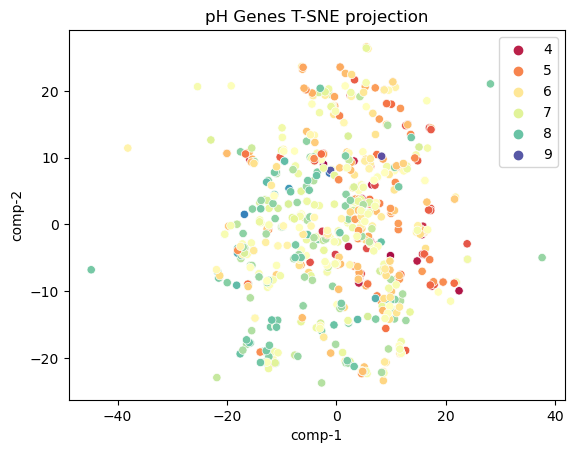

In [146]:
df_tsne = pd.DataFrame()
df_tsne["y"] = y
df_tsne["comp-1"] = z[:,0]
df_tsne["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne.y.tolist(),
                palette=sns.color_palette("Spectral", 20,as_cmap=True),
                data=df_tsne).set(title="pH Genes T-SNE projection")

plt.show()

In [147]:
Plot3D(z, y, 'Top 3 T-Sne')

In [148]:
# 3  Method Four
# 3.1  PCA
# https://medium.com/analytics-vidhya/feature-extraction-techniques-pca-lda-and-t-sne-df0459c723aa
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

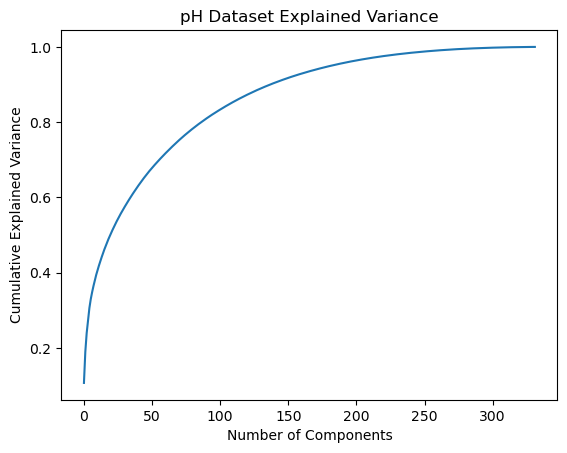

In [149]:
# Fitting the PCA algorithm with our Data
pca = PCA()
pca.fit(X)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('pH Dataset Explained Variance')
plt.show(block=True)

In [150]:
# pca = PCA(n_components=12)
#    pca.fit(Xtrain)
#    trainX_pca = pca.transform(trainX)
#    testX_pca = pca.transform(testX)
#    applyrandomforest(trainX_pca, testX_pca, trainY, testY)
     
pca = PCA(n_components=5)
Xpca = pca.fit_transform(X)

In [151]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=gene_list)
loadings

PC1       PC2       PC3       PC4       PC5
X23S_rRNA_IVP   -0.062938  0.082192 -0.076901  0.022200  0.117510
X5_nucleotid_C   0.049684 -0.037242 -0.022556 -0.076469  0.150924
X5.FTHF_cyc.lig  0.073950 -0.102676 -0.001404 -0.023419  0.044900
AA_permease      0.070480  0.048579  0.094037 -0.101780 -0.009139
AAA_25           0.044882 -0.054991  0.011605 -0.034471  0.073477
...                   ...       ...       ...       ...       ...
Ysc84            0.019966  0.097899 -0.079777 -0.048245 -0.086466
Ytca             0.007849  0.036028 -0.018187 -0.004384 -0.040618
ZapB             0.041503  0.027315 -0.104773 -0.145735 -0.053624
zf.CDGSH        -0.007841  0.072225  0.025960  0.019025  0.000383
Zn_peptidase_2  -0.042645  0.027554 -0.021624  0.013328  0.162299

[332 rows x 5 columns]

In [152]:
loadings.sort_values(by=['PC2'])

PC1       PC2       PC3       PC4       PC5
YGGT             0.090063 -0.111213  0.085087  0.001081 -0.093694
X5.FTHF_cyc.lig  0.073950 -0.102676 -0.001404 -0.023419  0.044900
FAD_binding_7    0.011896 -0.096021 -0.015714 -0.062438  0.050576
HSP33            0.126145 -0.095706 -0.114181  0.013256 -0.051507
PRA.PH           0.094347 -0.094234  0.007261 -0.036627  0.047839
...                   ...       ...       ...       ...       ...
SQHop_cyclase_C  0.056510  0.113845  0.027855  0.058294 -0.050520
Phosphoesterase  0.065157  0.116753  0.020608 -0.007254  0.010756
BBP2            -0.035520  0.127093 -0.093449  0.028988  0.103420
ActD            -0.045979  0.129175 -0.091053  0.037713  0.123625
VitK2_biosynth  -0.036947  0.131872  0.021700 -0.002356  0.048638

[332 rows x 5 columns]

In [153]:
pca = PCA(n_components=175, random_state=seed)
pca.fit(X)
X_pca_all = pca.transform(X)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

In [154]:
X_pca_all = pd.DataFrame(X_pca_all)
X_pca_train = pd.DataFrame(X_pca_train)
X_pca_test = pd.DataFrame(X_pca_test)

In [155]:
pca_model = XGBRegressor(learning_rate = 0.03, n_estimators=250, max_depth=5)
pca_model.fit(X_pca_train, 
              y_train, 
              early_stopping_rounds=10, 
              eval_metric="rmse", 
              verbose=False, 
              eval_set=[(X_pca_train, y_train), (X_pca_test, y_test)]
             )

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [156]:
# Predict the model
pred_pca = pca_model.predict(X_pca_test)
 
# MAE Computation
scores_pca_MAE = mean_absolute_error(y_test, pred_pca)

# RMSE Computation
scores_pca_RMSE = np.sqrt(mean_squared_error(y_test, pred_pca))
print("RMSE : % f, MAE : % f" % (scores_pca_RMSE, scores_pca_MAE))

RMSE :  0.785751, MAE :  0.660302


In [157]:
# 3.1.1  Okay lets do feature selection on the engineered features
# 3.1.1 好了，让我们对工程特征进行特征选择吧
X_pca_train

0         1         2         3         4         5         6    \
0   -2.381919 -0.740453  2.064223  0.407911 -0.824706  0.101665 -0.496584   
1    1.086025 -0.515607  1.940546 -0.692878  2.188096 -1.156111  4.025311   
2    0.187128 -2.503874 -1.544998 -1.526545 -1.255974  0.866165  0.408322   
3   -1.883760  2.233820 -0.814458  0.361629  0.083251 -1.908445 -0.401663   
4    3.809847 -1.163623 -0.314628  1.079888  0.621011 -0.346032  1.763455   
..        ...       ...       ...       ...       ...       ...       ...   
599  1.534081  0.528853  3.856647  0.432472  0.663340  0.748820 -2.317241   
600  1.163152  0.844827  4.608071 -0.491519  0.688563 -0.380345 -0.677983   
601  0.889528  0.854694 -0.402709 -1.184092 -1.945845 -1.345715  0.364673   
602  3.234303 -0.211878 -0.965039 -1.955673 -1.583117  1.182320  0.183935   
603 -0.158962 -2.555686 -2.085392 -2.041988 -0.750959 -0.389568 -0.382515   

          7         8         9    ...       165       166       167  \
0   -0.456893 -0.424489  0.557402  ...  0.128907  0.392054 -0.193168   
1    0.262113 -0.613461 -1.028797  ...  0.076686 -0.030990  0.032228   
2    0.848541  0.401696 -0.627524  ... -0.152514 -0.319632  0.382754   
3    1.992998  0.376643 -0.653480  ... -0.111412  0.121259 -0.295817   
4   -0.251549 -0.829700  0.164983  ...  0.125316  0.084499  0.091962   
..        ...       ...       ...  ...       ...       ...       ...   
599  1.181206  1.156694 -0.527966  ... -0.028969  0.060600  0.188453   
600  0.302896 -1.149656 -0.211185  ...  0.414733  0.495634 -0.068845   
601  1.470799 -0.018505  0.853178  ... -0.388751 -0.144305  0.075410   
602 -1.231520 -0.714811 -1.529077  ...  0.332169 -0.076890  0.213274   
603  0.737227 -0.058432  1.177047  ...  0.221898 -0.301993  0.137003   

          168       169       170       171       172       173       174  
0    0.175789 -0.115121 -0.136013  0.229996  0.396887 -0.129637  0.054032  
1    0.010095 -0.317467 -0.006859 -0.165067  0.011666 -0.192502  0.371553  
2   -0.337352 -0.559948 -0.205755 -0.079458 -0.448183 -0.283003 -0.153731  
3   -0.306944 -0.251727  0.430019 -0.065567  0.142082 -0.106606 -0.129209  
4    0.135543 -0.110462  0.248782 -0.012934 -0.000689 -0.126465 -0.308077  
..        ...       ...       ...       ...       ...       ...       ...  
599  0.166629  0.121548  0.093870 -0.239799 -0.316479  0.325222  0.036251  
600 -0.296857  0.094209 -0.600440 -0.109874 -0.233766 -0.055552 -0.234006  
601  0.284424 -0.283042  0.006002  0.199474 -0.181911  0.417073  0.049190  
602  0.078088  0.200640  0.163170  0.016269  0.056485  0.066750 -0.014998  
603 -0.103630  0.092933 -0.173983 -0.037838 -0.190450  0.034303 -0.134926  

[604 rows x 175 columns]

In [158]:
pca_perm_importance = permutation_importance(pca_model, X_pca_test, y_test, random_state=seed)

In [159]:
sorted_idx = pca_perm_importance.importances_mean.argsort()

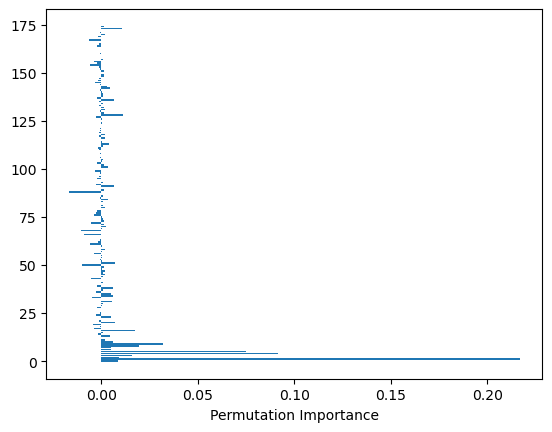

In [160]:
fig=plt.figure()
plt.barh(X_pca_train.columns[sorted_idx], pca_perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.savefig('Perm_Importance_2.png', bbox_inches='tight', pad_inches = 0, dpi=200)
plt.show()

In [161]:
pca_permlist = pd.DataFrame()
pca_permlist['PC'] = list(reversed(X_pca_train.columns[sorted_idx]))
pca_permlist['permimpt'] = list(reversed(pca_perm_importance.importances_mean[sorted_idx]))

In [162]:
# 3.1.2  Here we are removing all features below a set threshold
# 3.1.2 在这里，我们要删除所有低于设定阈值的特征。
# This will be heavily dependant on what your permutation list looks like and is somewhat arbitrary. However, you could introduce a grid search that reruns the model with a range of different tresholds and selects the one with the best performance.
# 这在很大程度上取决于您的排列列表，而且有些随意。不过，您可以引入网格搜索，使用一系列不同的阈值重新运行模型，然后选择性能最佳的阈值。
pca_perm_mean = pca_permlist['permimpt'].mean()
pca_permlist_subset = pca_permlist.loc[pca_permlist['permimpt'] > .0010]

In [163]:
pca_permlist_subset_list = pca_permlist_subset['PC'].tolist()

In [164]:
pca_permlist.loc[pca_permlist['PC'].isin(pca_permlist_subset_list)].to_csv('pca_selection.csv')

In [165]:
pca_df_all = pd.concat([y.reset_index(drop=True),X_pca_all[pca_permlist_subset_list].reset_index(drop=True)], axis=1)

In [166]:
pca_df_train = pd.concat([y_train.reset_index(drop=True),X_pca_train[pca_permlist_subset_list].reset_index(drop=True)], axis=1)

In [167]:
pca_df_test = pd.concat([y_test.reset_index(drop=True),X_pca_test[pca_permlist_subset_list].reset_index(drop=True)], axis=1)

In [168]:
#Split data into training features and labels
X_pca_perm, y_pca_perm = pca_df_all.loc[:, pca_df_all.columns != 'pH.preference'], pca_df_all['pH.preference']

In [169]:
test_size = 0.1
X_pca_perm_train, X_pca_perm_test, y_pca_perm_train, y_pca_perm_test = train_test_split(X_pca_perm, y_pca_perm, test_size=test_size, random_state=seed)

In [170]:
# Quick model
model_pca_perm_subset = XGBRegressor(learning_rate = 0.03, n_estimators=300, max_depth=4, random_state=seed)

In [171]:
model_pca_subset = XGBRegressor(
    max_depth=5,
    colsample_bytree=0.8,
    n_estimators=225,
    min_child_weight=10,
    subsample=0.9,    
    eta=0.02,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.54,
    #tree_method='gpu_hist'
    )

In [172]:
# Quick model
#model_pca_subset = XGBRegressor(learning_rate = 0.01, n_estimators=325, max_depth=5)
model_pca_perm_subset.fit(X_pca_perm_train, y_pca_perm_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, ...)

In [173]:
# Predict the model
pred_pca_subset = model_pca_perm_subset.predict(X_pca_perm_test)
 
# MAE Computation
scores_pca_subset_MAE = mean_absolute_error(y_pca_perm_test, pred_pca_subset)

# RMSE Computation
scores_pca_subset_RMSE = np.sqrt(mean_squared_error(y_pca_perm_test, pred_pca_subset))
print("RMSE : % f, MAE : % f" % (scores_pca_subset_RMSE, scores_pca_subset_MAE))

RMSE :  0.692218, MAE :  0.562568


In [174]:
# 下面这段代码耗时4h 46m 14s
trials = Trials()
best_params = optimize(trials, space)

  0%|                                                                         | 0/1000 [00:00<?, ?trial/s, best loss=?]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1496124987432033                                                                                                     
  0%|                                             | 1/1000 [00:03<1:00:49,  3.65s/trial, best loss: 1.1496124987432033]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
  0%|                                               | 2/1000 [00:04<37:38,  2.26s/trial, best loss: 1.1473171055981637]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
  0%|▏                                              | 3/1000 [00:06<32:05,  1.93s/trial, best loss: 1.1473171055981637]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
  0%|▏                                               | 4/1000 [00:07<27:28,  1.66s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1510644142294864                                                                                                     
  0%|▏                                               | 5/1000 [00:09<28:52,  1.74s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
  1%|▎                                               | 6/1000 [00:10<26:33,  1.60s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
  1%|▎                                             | 7/1000 [00:29<2:00:35,  7.29s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1510644142294864                                                                                                     
  1%|▎                                             | 8/1000 [00:31<1:31:38,  5.54s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
  1%|▍                                             | 9/1000 [00:35<1:24:53,  5.14s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.150792599378291                                                                                                      
  1%|▍                                            | 10/1000 [00:52<2:21:07,  8.55s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
  1%|▍                                            | 11/1000 [00:56<1:59:01,  7.22s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1510644142294864                                                                                                     
  1%|▌                                            | 12/1000 [00:57<1:30:15,  5.48s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
  1%|▌                                            | 13/1000 [00:59<1:12:49,  4.43s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
  1%|▋                                            | 14/1000 [01:37<3:57:12, 14.44s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1496124987432033                                                                                                     
  2%|▋                                            | 15/1000 [01:40<3:01:19, 11.05s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
  2%|▋                                            | 16/1000 [01:42<2:14:46,  8.22s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.150792599378291                                                                                                      
  2%|▊                                            | 17/1000 [01:48<2:06:14,  7.71s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1496124987432033                                                                                                     
  2%|▊                                            | 18/1000 [01:52<1:46:40,  6.52s/trial, best loss: 1.147039510480205]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0055679128135513                                                                                                     
  2%|▊                                           | 19/1000 [01:55<1:26:39,  5.30s/trial, best loss: 1.0055679128135513]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
  2%|▉                                           | 20/1000 [01:56<1:09:21,  4.25s/trial, best loss: 1.0055679128135513]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003997587443537                                                                                                      
  2%|▉                                              | 21/1000 [01:58<56:34,  3.47s/trial, best loss: 1.003997587443537]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  2%|█                                              | 22/1000 [01:59<44:52,  2.75s/trial, best loss: 1.003997587443537]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9122422790291543                                                                                                     
  2%|█                                             | 23/1000 [02:02<46:10,  2.84s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9122422790291543                                                                                                     
  2%|█                                             | 24/1000 [02:05<48:44,  3.00s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.926184208558987                                                                                                      
  2%|█▏                                            | 25/1000 [02:08<45:02,  2.77s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9122422790291543                                                                                                     
  3%|█▏                                            | 26/1000 [02:11<47:18,  2.91s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.926184208558987                                                                                                      
  3%|█▏                                            | 27/1000 [02:13<44:13,  2.73s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9122422790291543                                                                                                     
  3%|█▎                                            | 28/1000 [02:17<48:20,  2.98s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.924662325158654                                                                                                      
  3%|█▎                                            | 29/1000 [02:22<59:19,  3.67s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9420308541334074                                                                                                     
  3%|█▍                                            | 30/1000 [02:25<57:33,  3.56s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1449510903997924                                                                                                     
  3%|█▍                                            | 31/1000 [02:29<57:04,  3.53s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
  3%|█▍                                          | 32/1000 [02:33<1:00:21,  3.74s/trial, best loss: 0.9122422790291543]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
  3%|█▍                                          | 33/1000 [02:38<1:05:27,  4.06s/trial, best loss: 0.8331339428901586]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8665096503810593                                                                                                     
  3%|█▌                                            | 34/1000 [02:40<56:18,  3.50s/trial, best loss: 0.8331339428901586]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8665096503810593                                                                                                     
  4%|█▌                                            | 35/1000 [02:42<50:19,  3.13s/trial, best loss: 0.8331339428901586]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  4%|█▋                                             | 36/1000 [02:46<52:07,  3.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  4%|█▋                                             | 37/1000 [02:49<52:07,  3.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  4%|█▊                                             | 38/1000 [02:52<50:15,  3.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
  4%|█▊                                             | 39/1000 [02:53<41:53,  2.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
  4%|█▊                                           | 40/1000 [03:06<1:30:15,  5.64s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
  4%|█▊                                           | 41/1000 [03:07<1:09:05,  4.32s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  4%|█▉                                             | 42/1000 [03:08<52:30,  3.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
  4%|█▉                                           | 43/1000 [03:26<2:01:28,  7.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
  4%|█▉                                           | 44/1000 [03:27<1:29:47,  5.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
  4%|██                                           | 45/1000 [03:30<1:18:29,  4.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  5%|██                                           | 46/1000 [03:59<3:11:20, 12.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
  5%|██                                           | 47/1000 [04:00<2:18:34,  8.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
  5%|██▏                                          | 48/1000 [04:01<1:42:34,  6.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1627049123883184                                                                                                     
  5%|██▏                                          | 49/1000 [04:04<1:26:16,  5.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  5%|██▎                                          | 50/1000 [04:05<1:04:44,  4.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
  5%|██▍                                            | 51/1000 [04:06<50:28,  3.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
  5%|██▍                                            | 52/1000 [04:07<39:13,  2.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
  5%|██▍                                            | 53/1000 [04:08<33:14,  2.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
  5%|██▌                                            | 54/1000 [04:12<41:28,  2.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
  6%|██▌                                            | 55/1000 [04:14<36:55,  2.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  6%|██▋                                            | 56/1000 [04:15<29:54,  1.90s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
  6%|██▌                                          | 57/1000 [04:25<1:10:47,  4.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
  6%|██▋                                            | 58/1000 [04:26<54:15,  3.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  6%|██▊                                            | 59/1000 [04:27<41:51,  2.67s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
  6%|██▊                                            | 60/1000 [04:28<35:33,  2.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
  6%|██▊                                            | 61/1000 [04:31<38:40,  2.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  6%|██▉                                            | 62/1000 [04:32<32:25,  2.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
  6%|██▊                                          | 63/1000 [04:57<2:19:20,  8.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
  6%|██▉                                          | 64/1000 [04:58<1:41:07,  6.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
  6%|██▉                                          | 65/1000 [04:59<1:15:03,  4.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  7%|██▉                                          | 66/1000 [05:02<1:08:11,  4.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
  7%|███                                          | 67/1000 [05:06<1:06:04,  4.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  7%|███                                          | 68/1000 [06:29<7:13:38, 27.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
  7%|███                                          | 69/1000 [06:35<5:28:28, 21.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
  7%|███▏                                         | 70/1000 [06:36<3:56:14, 15.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
  7%|███                                         | 71/1000 [08:24<11:06:35, 43.05s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  7%|███▏                                         | 72/1000 [08:27<7:59:20, 30.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0023648334015838                                                                                                     
  7%|███▎                                         | 73/1000 [09:14<9:11:48, 35.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  7%|███▎                                         | 74/1000 [09:15<6:29:35, 25.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
  8%|███▍                                         | 75/1000 [09:22<5:04:02, 19.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  8%|███▍                                         | 76/1000 [09:24<3:43:24, 14.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  8%|███▍                                         | 77/1000 [09:52<4:45:42, 18.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
  8%|███▌                                         | 78/1000 [09:53<3:24:00, 13.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
  8%|███▌                                         | 79/1000 [09:54<2:28:05,  9.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
  8%|███▌                                         | 80/1000 [09:57<1:58:32,  7.73s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  8%|███▋                                         | 81/1000 [09:58<1:27:06,  5.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
  8%|███▋                                         | 82/1000 [09:59<1:05:35,  4.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8421590065733543                                                                                                     
  8%|███▋                                         | 83/1000 [10:03<1:01:12,  4.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
  8%|███▉                                           | 84/1000 [10:05<55:29,  3.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
  8%|███▉                                           | 85/1000 [10:06<43:27,  2.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
  9%|████                                           | 86/1000 [10:08<35:55,  2.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
  9%|████                                           | 87/1000 [10:11<38:59,  2.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0143226583914515                                                                                                     
  9%|████▏                                          | 88/1000 [10:12<34:19,  2.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
  9%|████▏                                          | 89/1000 [10:13<28:55,  1.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
  9%|████▏                                          | 90/1000 [10:16<32:01,  2.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
  9%|████                                         | 91/1000 [11:04<4:01:08, 15.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
  9%|████▏                                        | 92/1000 [11:06<2:57:15, 11.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
  9%|████▏                                        | 93/1000 [11:14<2:39:17, 10.54s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
  9%|████▏                                        | 94/1000 [11:15<1:55:34,  7.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8505322962687313                                                                                                     
 10%|████▎                                        | 95/1000 [11:25<2:06:01,  8.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 10%|████▎                                        | 96/1000 [11:26<1:34:52,  6.30s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 10%|████▎                                        | 97/1000 [11:41<2:12:47,  8.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 10%|████▍                                        | 98/1000 [11:42<1:40:14,  6.67s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 10%|████▍                                        | 99/1000 [11:44<1:17:13,  5.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1309278080787897                                                                                                     
 10%|████▍                                       | 100/1000 [11:45<1:00:01,  4.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.010990334849015                                                                                                      
 10%|████▋                                         | 101/1000 [11:47<50:48,  3.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 10%|████▋                                         | 102/1000 [11:48<39:46,  2.66s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 10%|████▌                                       | 103/1000 [12:22<2:59:16, 11.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 10%|████▌                                       | 104/1000 [12:28<2:33:08, 10.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 10%|████▌                                       | 105/1000 [12:29<1:52:38,  7.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8582048818899103                                                                                                     
 11%|████▋                                       | 106/1000 [12:31<1:26:30,  5.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1509361400817582                                                                                                     
 11%|████▋                                       | 107/1000 [12:33<1:08:53,  4.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 11%|████▉                                         | 108/1000 [12:34<53:04,  3.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 11%|█████                                         | 109/1000 [12:38<52:10,  3.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8432199903971468                                                                                                     
 11%|█████                                         | 110/1000 [12:41<49:41,  3.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 11%|█████                                         | 111/1000 [12:42<39:39,  2.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0023648334015838                                                                                                     
 11%|█████▏                                        | 112/1000 [12:44<36:30,  2.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 11%|█████▏                                        | 113/1000 [12:45<29:48,  2.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1286280480078055                                                                                                     
 11%|█████▏                                        | 114/1000 [12:46<27:45,  1.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 12%|█████▎                                        | 115/1000 [12:47<23:08,  1.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 12%|█████▎                                        | 116/1000 [12:49<24:25,  1.66s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
 12%|█████▍                                        | 117/1000 [12:53<37:21,  2.54s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 12%|█████▍                                        | 118/1000 [12:55<31:33,  2.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
 12%|█████▍                                        | 119/1000 [13:00<47:01,  3.20s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1484575421653085                                                                                                     
 12%|█████▌                                        | 120/1000 [13:03<42:53,  2.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 12%|█████▎                                      | 121/1000 [13:37<3:01:45, 12.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 12%|█████▎                                      | 122/1000 [13:50<3:03:16, 12.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
 12%|█████▍                                      | 123/1000 [13:52<2:19:14,  9.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 12%|█████▍                                      | 124/1000 [13:54<1:44:51,  7.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 12%|█████▌                                      | 125/1000 [14:06<2:05:27,  8.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 13%|█████▌                                      | 126/1000 [14:08<1:37:59,  6.73s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 13%|█████▌                                      | 127/1000 [14:10<1:14:32,  5.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 13%|█████▉                                        | 128/1000 [14:11<56:56,  3.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
 13%|█████▉                                        | 129/1000 [14:13<49:30,  3.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 13%|█████▉                                        | 130/1000 [14:15<40:50,  2.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 13%|██████                                        | 131/1000 [14:16<35:11,  2.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 13%|██████                                        | 132/1000 [14:21<43:46,  3.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 13%|██████                                        | 133/1000 [14:21<34:42,  2.40s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 13%|██████▏                                       | 134/1000 [14:25<39:10,  2.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 14%|██████▏                                       | 135/1000 [14:26<32:34,  2.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 14%|█████▉                                      | 136/1000 [15:51<6:27:51, 26.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8505322962687313                                                                                                     
 14%|██████                                      | 137/1000 [15:54<4:46:05, 19.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9219315070365806                                                                                                     
 14%|██████                                      | 138/1000 [15:56<3:27:55, 14.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 14%|██████                                      | 139/1000 [15:57<2:30:51, 10.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9965878872822478                                                                                                     
 14%|██████▏                                     | 140/1000 [16:44<5:07:26, 21.45s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 14%|██████▏                                     | 141/1000 [16:46<3:44:00, 15.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 14%|██████▏                                     | 142/1000 [16:47<2:40:38, 11.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8468046143512064                                                                                                     
 14%|██████▎                                     | 143/1000 [16:55<2:26:53, 10.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
 14%|██████▎                                     | 144/1000 [16:59<1:56:34,  8.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 14%|██████▍                                     | 145/1000 [17:00<1:28:02,  6.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 15%|██████▍                                     | 146/1000 [17:03<1:15:50,  5.33s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 15%|██████▍                                     | 147/1000 [17:07<1:10:17,  4.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 15%|██████▌                                     | 148/1000 [17:11<1:02:33,  4.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 15%|██████▊                                       | 149/1000 [17:14<57:38,  4.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 15%|██████▉                                       | 150/1000 [17:17<53:25,  3.77s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 15%|██████▉                                       | 151/1000 [17:20<51:13,  3.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 15%|██████▉                                       | 152/1000 [17:24<49:46,  3.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 15%|███████                                       | 153/1000 [17:25<39:42,  2.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 15%|███████                                       | 154/1000 [17:26<32:12,  2.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 16%|██████▊                                     | 155/1000 [18:28<4:46:19, 20.33s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 16%|██████▊                                     | 156/1000 [18:29<3:24:37, 14.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 16%|██████▉                                     | 157/1000 [19:31<6:41:39, 28.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9056408880837533                                                                                                     
 16%|██████▉                                     | 158/1000 [19:32<4:46:18, 20.40s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 16%|██████▉                                     | 159/1000 [19:55<4:56:24, 21.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 16%|███████                                     | 160/1000 [20:02<3:58:56, 17.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0121518132807894                                                                                                     
 16%|███████                                     | 161/1000 [20:04<2:52:33, 12.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 16%|███████▏                                    | 162/1000 [20:07<2:13:07,  9.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 16%|███████▏                                    | 163/1000 [20:08<1:37:03,  6.96s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 16%|███████▏                                    | 164/1000 [20:09<1:13:10,  5.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 16%|███████▌                                      | 165/1000 [20:11<58:27,  4.20s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 17%|███████▎                                    | 166/1000 [20:53<3:38:13, 15.70s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 17%|███████▎                                    | 167/1000 [21:07<3:31:48, 15.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 17%|███████▍                                    | 168/1000 [21:09<2:33:08, 11.04s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 17%|███████▍                                    | 169/1000 [21:11<1:58:31,  8.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 17%|███████▍                                    | 170/1000 [21:13<1:31:15,  6.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 17%|███████▌                                    | 171/1000 [21:17<1:17:31,  5.61s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 17%|███████▌                                    | 172/1000 [21:26<1:32:03,  6.67s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 17%|███████▌                                    | 173/1000 [21:27<1:09:53,  5.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 17%|████████                                      | 174/1000 [21:28<52:40,  3.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8989541312294028                                                                                                     
 18%|████████                                      | 175/1000 [21:29<41:04,  2.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 18%|████████                                      | 176/1000 [21:33<46:21,  3.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0143226583914515                                                                                                     
 18%|████████▏                                     | 177/1000 [21:38<49:48,  3.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 18%|████████▏                                     | 178/1000 [21:39<39:32,  2.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 18%|███████▉                                    | 179/1000 [22:02<2:04:30,  9.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 18%|███████▉                                    | 180/1000 [22:21<2:45:05, 12.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 18%|███████▉                                    | 181/1000 [22:25<2:09:13,  9.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 18%|████████                                    | 182/1000 [22:39<2:29:18, 10.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 18%|████████                                    | 183/1000 [23:07<3:38:13, 16.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 18%|████████                                    | 184/1000 [23:08<2:37:02, 11.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8344134235600729                                                                                                     
 18%|████████▏                                   | 185/1000 [23:11<2:02:27,  9.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 19%|████████▏                                   | 186/1000 [23:12<1:29:33,  6.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 19%|████████▏                                   | 187/1000 [23:13<1:07:24,  4.98s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9253800989206361                                                                                                     
 19%|████████▋                                     | 188/1000 [23:15<55:03,  4.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 19%|████████▋                                     | 189/1000 [23:19<52:33,  3.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003997587443537                                                                                                      
 19%|████████▋                                     | 190/1000 [23:20<42:03,  3.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 19%|████████▊                                     | 191/1000 [23:22<36:09,  2.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 19%|████████▊                                     | 192/1000 [23:24<32:29,  2.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 19%|████████▉                                     | 193/1000 [23:27<35:29,  2.64s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 19%|████████▉                                     | 194/1000 [23:29<32:33,  2.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 20%|████████▉                                     | 195/1000 [23:29<26:21,  1.96s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8582048818899103                                                                                                     
 20%|████████▌                                   | 196/1000 [23:55<1:59:23,  8.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1286280480078055                                                                                                     
 20%|████████▋                                   | 197/1000 [23:56<1:28:58,  6.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 20%|████████▋                                   | 198/1000 [23:57<1:06:15,  4.96s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1484575421653085                                                                                                     
 20%|████████▊                                   | 199/1000 [24:16<2:04:18,  9.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9219315070365806                                                                                                     
 20%|████████▊                                   | 200/1000 [24:29<2:17:25, 10.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 20%|████████▊                                   | 201/1000 [24:30<1:39:56,  7.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 20%|████████▉                                   | 202/1000 [24:53<2:40:17, 12.05s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 20%|████████▉                                   | 203/1000 [24:55<2:02:06,  9.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 20%|████████▉                                   | 204/1000 [24:59<1:38:53,  7.45s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0119874817325845                                                                                                     
 20%|█████████                                   | 205/1000 [25:01<1:19:47,  6.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 21%|█████████                                   | 206/1000 [25:03<1:02:04,  4.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 21%|█████████▌                                    | 207/1000 [25:04<48:14,  3.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 21%|█████████▌                                    | 208/1000 [25:07<45:15,  3.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 21%|█████████▌                                    | 209/1000 [25:08<36:02,  2.73s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8442206355972225                                                                                                     
 21%|█████████▋                                    | 210/1000 [25:11<36:00,  2.74s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 21%|█████████▋                                    | 211/1000 [25:12<29:18,  2.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 21%|█████████▊                                    | 212/1000 [25:13<24:37,  1.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
 21%|█████████▊                                    | 213/1000 [25:16<28:57,  2.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 21%|█████████▊                                    | 214/1000 [25:17<24:44,  1.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8468046143512064                                                                                                     
 22%|█████████▉                                    | 215/1000 [25:26<51:08,  3.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 22%|█████████▉                                    | 216/1000 [25:29<46:40,  3.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 22%|█████████▉                                    | 217/1000 [25:31<43:37,  3.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 22%|██████████                                    | 218/1000 [25:33<36:30,  2.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 22%|██████████                                    | 219/1000 [25:34<30:28,  2.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9965878872822478                                                                                                     
 22%|██████████                                    | 220/1000 [25:36<28:19,  2.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 22%|█████████▋                                  | 221/1000 [26:09<2:28:32, 11.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 22%|█████████▊                                  | 222/1000 [26:10<1:48:46,  8.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 22%|█████████▊                                  | 223/1000 [26:11<1:19:29,  6.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8468307223501615                                                                                                     
 22%|█████████▊                                  | 224/1000 [26:13<1:03:10,  4.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 22%|██████████▎                                   | 225/1000 [26:14<49:14,  3.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 23%|█████████▉                                  | 226/1000 [26:28<1:25:16,  6.61s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8606513514168281                                                                                                     
 23%|█████████▉                                  | 227/1000 [26:38<1:39:49,  7.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 23%|██████████                                  | 228/1000 [26:46<1:39:41,  7.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.134782973451433                                                                                                      
 23%|██████████                                  | 229/1000 [26:47<1:12:54,  5.67s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 23%|██████████▌                                   | 230/1000 [26:47<54:32,  4.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.91627144749912                                                                                                       
 23%|██████████▋                                   | 231/1000 [26:50<46:43,  3.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0104489444805105                                                                                                     
 23%|██████████▋                                   | 232/1000 [26:51<38:29,  3.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 23%|██████████▋                                   | 233/1000 [26:53<33:31,  2.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 23%|██████████▊                                   | 234/1000 [26:54<29:22,  2.30s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 24%|██████████▊                                   | 235/1000 [26:56<26:48,  2.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8823539812722015                                                                                                     
 24%|██████████▊                                   | 236/1000 [26:57<23:52,  1.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 24%|██████████▉                                   | 237/1000 [26:59<23:25,  1.84s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 24%|██████████▉                                   | 238/1000 [27:00<19:52,  1.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8886528786859358                                                                                                     
 24%|██████████▌                                 | 239/1000 [27:34<2:24:32, 11.40s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 24%|██████████▌                                 | 240/1000 [27:36<1:45:59,  8.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1484575421653085                                                                                                     
 24%|██████████▌                                 | 241/1000 [27:38<1:22:02,  6.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8582048818899103                                                                                                     
 24%|██████████▋                                 | 242/1000 [27:40<1:03:59,  5.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 24%|███████████▏                                  | 243/1000 [27:42<54:52,  4.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 24%|██████████▋                                 | 244/1000 [27:50<1:07:39,  5.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 24%|███████████▎                                  | 245/1000 [27:53<57:12,  4.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
 25%|███████████▎                                  | 246/1000 [27:57<55:22,  4.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0121518132807894                                                                                                     
 25%|███████████▎                                  | 247/1000 [27:59<45:26,  3.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 25%|███████████▍                                  | 248/1000 [28:00<36:48,  2.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 25%|███████████▍                                  | 249/1000 [28:02<31:48,  2.54s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 25%|███████████                                 | 250/1000 [28:12<1:00:24,  4.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 25%|███████████▌                                  | 251/1000 [28:15<53:00,  4.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8413659517475681                                                                                                     
 25%|███████████                                 | 252/1000 [28:27<1:24:07,  6.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 25%|███████████▏                                | 253/1000 [28:28<1:03:26,  5.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 25%|███████████▋                                  | 254/1000 [28:29<48:00,  3.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 26%|███████████▋                                  | 255/1000 [28:34<49:28,  3.98s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
 26%|███████████▎                                | 256/1000 [28:54<1:49:28,  8.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 26%|███████████▎                                | 257/1000 [29:16<2:38:20, 12.79s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▎                                | 258/1000 [29:18<2:00:10,  9.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▍                                | 259/1000 [30:02<4:04:25, 19.79s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▍                                | 260/1000 [30:04<3:00:24, 14.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▍                                | 261/1000 [30:07<2:17:02, 11.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▌                                | 262/1000 [30:10<1:45:30,  8.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▌                                | 263/1000 [30:13<1:25:22,  6.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▌                                | 264/1000 [31:37<6:07:54, 29.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 26%|███████████▋                                | 265/1000 [33:00<9:21:28, 45.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 27%|███████████▋                                | 266/1000 [33:02<6:41:29, 32.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 27%|███████████▋                                | 267/1000 [33:05<4:52:35, 23.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 27%|███████████▊                                | 268/1000 [33:09<3:36:32, 17.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 27%|███████████▊                                | 269/1000 [33:12<2:42:27, 13.33s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 27%|███████████▉                                | 270/1000 [33:14<2:01:27,  9.98s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 27%|███████████▉                                | 271/1000 [33:23<1:58:35,  9.76s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 27%|███████████▉                                | 272/1000 [33:24<1:26:17,  7.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 27%|████████████                                | 273/1000 [33:25<1:03:52,  5.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 27%|████████████▌                                 | 274/1000 [33:28<55:33,  4.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 28%|████████████▋                                 | 275/1000 [33:29<43:01,  3.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 28%|████████████▋                                 | 276/1000 [33:31<37:57,  3.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 28%|████████████▋                                 | 277/1000 [33:32<30:26,  2.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 28%|████████████▊                                 | 278/1000 [33:34<26:34,  2.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 28%|████████████▎                               | 279/1000 [33:58<1:44:57,  8.73s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 28%|████████████▎                               | 280/1000 [34:00<1:21:14,  6.77s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.91627144749912                                                                                                       
 28%|████████████▎                               | 281/1000 [34:02<1:03:14,  5.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 28%|████████████▉                                 | 282/1000 [34:03<48:11,  4.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 28%|█████████████                                 | 283/1000 [34:04<38:56,  3.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 28%|█████████████                                 | 284/1000 [34:08<39:49,  3.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 28%|█████████████                                 | 285/1000 [34:10<34:34,  2.90s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 29%|█████████████▏                                | 286/1000 [34:14<38:24,  3.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.025987740427835                                                                                                      
 29%|█████████████▏                                | 287/1000 [34:15<30:40,  2.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 29%|█████████████▏                                | 288/1000 [34:16<26:14,  2.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 29%|█████████████▎                                | 289/1000 [34:18<24:02,  2.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 29%|█████████████▎                                | 290/1000 [34:19<21:55,  1.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 29%|█████████████▍                                | 291/1000 [34:23<27:55,  2.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 29%|█████████████▍                                | 292/1000 [34:32<51:50,  4.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 29%|████████████▉                               | 293/1000 [34:46<1:27:32,  7.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 29%|████████████▉                               | 294/1000 [34:48<1:05:38,  5.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 30%|█████████████▌                                | 295/1000 [34:49<50:05,  4.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 30%|█████████████▌                                | 296/1000 [34:52<44:38,  3.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 30%|█████████████▋                                | 297/1000 [34:56<46:42,  3.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.91627144749912                                                                                                       
 30%|█████████████▋                                | 298/1000 [34:58<38:07,  3.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 30%|█████████████▊                                | 299/1000 [35:03<44:12,  3.78s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 30%|█████████████▊                                | 300/1000 [35:04<34:59,  3.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 30%|█████████████▊                                | 301/1000 [35:07<34:49,  2.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 30%|█████████████▉                                | 302/1000 [35:07<26:59,  2.32s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.144182471582103                                                                                                      
 30%|█████████████▉                                | 303/1000 [35:10<26:33,  2.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 30%|█████████████▉                                | 304/1000 [35:11<24:06,  2.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 30%|█████████████▍                              | 305/1000 [35:45<2:12:45, 11.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
 31%|█████████████▍                              | 306/1000 [35:46<1:36:31,  8.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 31%|█████████████▌                              | 307/1000 [35:47<1:11:13,  6.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 31%|█████████████▌                              | 308/1000 [36:10<2:09:01, 11.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 31%|█████████████▌                              | 309/1000 [36:11<1:34:52,  8.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 31%|█████████████▋                              | 310/1000 [36:44<3:00:00, 15.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 31%|█████████████▋                              | 311/1000 [36:46<2:12:36, 11.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 31%|█████████████▋                              | 312/1000 [36:48<1:41:16,  8.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 31%|█████████████▊                              | 313/1000 [36:52<1:22:15,  7.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0143226583914515                                                                                                     
 31%|█████████████▊                              | 314/1000 [36:54<1:04:23,  5.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 32%|██████████████▍                               | 315/1000 [36:55<49:34,  4.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 32%|██████████████▌                               | 316/1000 [36:56<39:07,  3.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 32%|██████████████▌                               | 317/1000 [36:58<32:25,  2.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 32%|██████████████▋                               | 318/1000 [37:00<31:27,  2.77s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 32%|██████████████▋                               | 319/1000 [37:03<29:09,  2.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 32%|██████████████▋                               | 320/1000 [37:06<31:53,  2.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 32%|██████████████                              | 321/1000 [37:49<2:48:21, 14.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1509361400817582                                                                                                     
 32%|██████████████▏                             | 322/1000 [37:50<2:02:41, 10.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 32%|██████████████▏                             | 323/1000 [37:52<1:31:08,  8.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 32%|██████████████▎                             | 324/1000 [37:53<1:07:10,  5.96s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 32%|██████████████▉                               | 325/1000 [37:56<55:21,  4.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 33%|██████████████▉                               | 326/1000 [37:59<50:05,  4.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
 33%|███████████████                               | 327/1000 [38:02<46:56,  4.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9056408880837533                                                                                                     
 33%|███████████████                               | 328/1000 [38:04<37:56,  3.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 33%|███████████████▏                              | 329/1000 [38:05<29:03,  2.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 33%|███████████████▏                              | 330/1000 [38:06<24:17,  2.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 33%|███████████████▏                              | 331/1000 [38:08<23:34,  2.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 33%|███████████████▎                              | 332/1000 [38:11<28:07,  2.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 33%|███████████████▎                              | 333/1000 [38:13<25:22,  2.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 33%|███████████████▎                              | 334/1000 [38:14<21:36,  1.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 34%|███████████████▍                              | 335/1000 [38:16<20:37,  1.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 34%|███████████████▍                              | 336/1000 [38:18<21:49,  1.97s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 34%|███████████████▌                              | 337/1000 [38:19<18:41,  1.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 34%|███████████████▌                              | 338/1000 [38:30<47:22,  4.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8442682185388789                                                                                                     
 34%|███████████████▌                              | 339/1000 [38:37<58:18,  5.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 34%|███████████████▋                              | 340/1000 [38:42<57:24,  5.22s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 34%|███████████████▋                              | 341/1000 [38:44<44:31,  4.05s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 34%|███████████████                             | 342/1000 [39:01<1:26:57,  7.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 34%|███████████████                             | 343/1000 [39:04<1:12:14,  6.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 34%|███████████████▏                            | 344/1000 [39:08<1:04:41,  5.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 34%|███████████████▊                              | 345/1000 [39:09<48:09,  4.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 35%|███████████████▉                              | 346/1000 [39:13<44:48,  4.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 35%|███████████████▉                              | 347/1000 [39:14<36:56,  3.40s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 35%|███████████████▎                            | 348/1000 [39:37<1:39:19,  9.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 35%|███████████████▎                            | 349/1000 [39:38<1:13:51,  6.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
 35%|███████████████▍                            | 350/1000 [40:26<3:26:53, 19.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 35%|███████████████▍                            | 351/1000 [40:30<2:38:40, 14.67s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 35%|███████████████▍                            | 352/1000 [40:53<3:04:27, 17.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 35%|███████████████▌                            | 353/1000 [41:16<3:21:42, 18.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 35%|███████████████▌                            | 354/1000 [41:22<2:43:01, 15.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 36%|███████████████▌                            | 355/1000 [41:23<1:57:00, 10.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 36%|███████████████▋                            | 356/1000 [41:24<1:25:11,  7.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.126757177928783                                                                                                      
 36%|███████████████▋                            | 357/1000 [41:26<1:04:19,  6.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 36%|███████████████▊                            | 358/1000 [42:09<3:02:52, 17.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.901294618632149                                                                                                      
 36%|███████████████▊                            | 359/1000 [42:10<2:12:12, 12.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 36%|███████████████▊                            | 360/1000 [42:13<1:42:14,  9.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 36%|███████████████▉                            | 361/1000 [42:18<1:25:04,  7.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 36%|███████████████▉                            | 362/1000 [42:21<1:11:23,  6.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0119874817325845                                                                                                     
 36%|████████████████▋                             | 363/1000 [42:23<56:23,  5.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 36%|████████████████▋                             | 364/1000 [42:27<50:23,  4.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 36%|████████████████▊                             | 365/1000 [42:28<40:13,  3.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 37%|████████████████▊                             | 366/1000 [42:30<32:38,  3.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 37%|████████████████▏                           | 367/1000 [43:52<4:44:09, 26.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 37%|████████████████▏                           | 368/1000 [43:54<3:22:06, 19.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 37%|████████████████▏                           | 369/1000 [43:56<2:29:33, 14.22s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 37%|████████████████▎                           | 370/1000 [43:57<1:47:13, 10.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 37%|████████████████▎                           | 371/1000 [43:58<1:18:36,  7.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 37%|████████████████▎                           | 372/1000 [44:02<1:05:30,  6.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 37%|█████████████████▏                            | 373/1000 [44:05<56:21,  5.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8495846191559401                                                                                                     
 37%|█████████████████▏                            | 374/1000 [44:07<45:46,  4.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 38%|█████████████████▎                            | 375/1000 [44:09<36:45,  3.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 38%|█████████████████▎                            | 376/1000 [44:10<29:30,  2.84s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 38%|█████████████████▎                            | 377/1000 [44:13<31:40,  3.05s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 38%|█████████████████▍                            | 378/1000 [44:18<35:28,  3.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 38%|█████████████████▍                            | 379/1000 [44:19<27:47,  2.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1277168481062498                                                                                                     
 38%|████████████████▋                           | 380/1000 [44:42<1:33:14,  9.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 38%|████████████████▊                           | 381/1000 [44:43<1:07:45,  6.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 38%|████████████████▊                           | 382/1000 [45:14<2:22:52, 13.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 38%|████████████████▊                           | 383/1000 [45:15<1:42:44,  9.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 38%|████████████████▉                           | 384/1000 [45:16<1:14:29,  7.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 38%|████████████████▉                           | 385/1000 [45:19<1:01:47,  6.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 39%|█████████████████▊                            | 386/1000 [45:22<53:07,  5.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 39%|█████████████████▊                            | 387/1000 [45:24<41:31,  4.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8442206355972225                                                                                                     
 39%|█████████████████▊                            | 388/1000 [45:26<36:14,  3.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 39%|█████████████████▉                            | 389/1000 [45:27<29:28,  2.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 39%|█████████████████▉                            | 390/1000 [45:31<30:41,  3.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 39%|█████████████████▉                            | 391/1000 [45:33<27:18,  2.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 39%|██████████████████                            | 392/1000 [45:34<23:29,  2.32s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0143226583914515                                                                                                     
 39%|██████████████████                            | 393/1000 [45:47<54:59,  5.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 39%|██████████████████                            | 394/1000 [45:52<53:37,  5.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 40%|██████████████████▏                           | 395/1000 [45:53<41:19,  4.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 40%|██████████████████▏                           | 396/1000 [45:54<31:55,  3.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
 40%|█████████████████▍                          | 397/1000 [47:58<6:35:33, 39.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8538050471412135                                                                                                     
 40%|█████████████████▌                          | 398/1000 [48:02<4:47:07, 28.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 40%|█████████████████▌                          | 399/1000 [48:05<3:30:33, 21.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 40%|█████████████████▌                          | 400/1000 [48:07<2:32:50, 15.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 40%|█████████████████▋                          | 401/1000 [48:14<2:10:00, 13.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 40%|█████████████████▋                          | 402/1000 [48:17<1:37:56,  9.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 40%|█████████████████▋                          | 403/1000 [48:20<1:18:10,  7.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 40%|█████████████████▊                          | 404/1000 [48:24<1:05:21,  6.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 40%|██████████████████▋                           | 405/1000 [48:26<53:50,  5.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|██████████████████▋                           | 406/1000 [48:30<47:51,  4.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|█████████████████▉                          | 407/1000 [49:13<2:39:54, 16.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|█████████████████▉                          | 408/1000 [49:17<2:06:20, 12.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|█████████████████▉                          | 409/1000 [49:20<1:36:30,  9.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|██████████████████                          | 410/1000 [49:24<1:18:30,  7.98s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|██████████████████                          | 411/1000 [49:27<1:04:48,  6.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|██████████████████▉                           | 412/1000 [49:30<54:19,  5.54s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|██████████████████▏                         | 413/1000 [49:53<1:44:44, 10.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 41%|██████████████████▏                         | 414/1000 [50:16<2:19:58, 14.33s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 42%|██████████████████▎                         | 415/1000 [50:39<2:43:50, 16.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 42%|██████████████████▎                         | 416/1000 [50:41<2:02:15, 12.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 42%|██████████████████▎                         | 417/1000 [50:42<1:28:44,  9.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 42%|██████████████████▍                         | 418/1000 [50:45<1:08:27,  7.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 42%|██████████████████▍                         | 419/1000 [50:57<1:24:25,  8.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 42%|██████████████████▍                         | 420/1000 [51:10<1:35:09,  9.84s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 42%|██████████████████▌                         | 421/1000 [51:15<1:20:44,  8.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 42%|██████████████████▌                         | 422/1000 [52:37<4:54:52, 30.61s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 42%|██████████████████▌                         | 423/1000 [52:38<3:29:49, 21.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 42%|██████████████████▋                         | 424/1000 [52:41<2:35:34, 16.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 42%|██████████████████▋                         | 425/1000 [52:43<1:52:02, 11.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 43%|██████████████████▋                         | 426/1000 [52:44<1:21:50,  8.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 43%|██████████████████▊                         | 427/1000 [53:17<2:31:47, 15.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 43%|██████████████████▊                         | 428/1000 [53:19<1:51:29, 11.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 43%|██████████████████▉                         | 429/1000 [53:21<1:23:23,  8.76s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 43%|██████████████████▉                         | 430/1000 [53:22<1:01:35,  6.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 43%|███████████████████▊                          | 431/1000 [53:25<52:43,  5.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 43%|███████████████████▊                          | 432/1000 [53:26<40:15,  4.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 43%|███████████████████▉                          | 433/1000 [53:28<33:47,  3.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 43%|███████████████████▉                          | 434/1000 [53:31<29:21,  3.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 44%|████████████████████                          | 435/1000 [53:34<30:13,  3.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.901294618632149                                                                                                      
 44%|████████████████████                          | 436/1000 [53:38<33:35,  3.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 44%|███████████████████▏                        | 437/1000 [54:01<1:26:48,  9.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 44%|███████████████████▎                        | 438/1000 [54:02<1:04:31,  6.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 44%|████████████████████▏                         | 439/1000 [54:04<50:49,  5.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 44%|████████████████████▏                         | 440/1000 [54:07<41:52,  4.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 44%|████████████████████▎                         | 441/1000 [54:08<33:41,  3.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 44%|████████████████████▎                         | 442/1000 [54:10<28:50,  3.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 44%|████████████████████▍                         | 443/1000 [54:11<24:04,  2.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 44%|████████████████████▍                         | 444/1000 [54:15<26:08,  2.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 44%|████████████████████▍                         | 445/1000 [54:17<23:03,  2.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 45%|███████████████████▌                        | 446/1000 [54:34<1:03:47,  6.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 45%|████████████████████▌                         | 447/1000 [54:35<46:53,  5.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 45%|████████████████████▌                         | 448/1000 [54:37<38:19,  4.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 45%|████████████████████▋                         | 449/1000 [54:39<34:06,  3.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 45%|████████████████████▋                         | 450/1000 [54:42<30:51,  3.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9056408880837533                                                                                                     
 45%|███████████████████▊                        | 451/1000 [55:04<1:21:49,  8.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 45%|███████████████████▉                        | 452/1000 [55:07<1:06:53,  7.32s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 45%|████████████████████▊                         | 453/1000 [55:08<49:56,  5.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 45%|████████████████████▉                         | 454/1000 [55:12<44:02,  4.84s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9965878872822478                                                                                                     
 46%|████████████████████▉                         | 455/1000 [55:14<35:37,  3.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 46%|████████████████████▉                         | 456/1000 [55:17<33:21,  3.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 46%|█████████████████████                         | 457/1000 [55:18<26:05,  2.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 46%|█████████████████████                         | 458/1000 [55:19<21:32,  2.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 46%|█████████████████████                         | 459/1000 [55:21<20:09,  2.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 46%|█████████████████████▏                        | 460/1000 [55:34<48:20,  5.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 46%|████████████████████▎                       | 461/1000 [55:46<1:07:08,  7.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.151600320810611                                                                                                      
 46%|█████████████████████▎                        | 462/1000 [55:47<49:01,  5.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 46%|█████████████████████▎                        | 463/1000 [55:48<36:32,  4.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 46%|█████████████████████▎                        | 464/1000 [55:49<28:50,  3.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 46%|█████████████████████▍                        | 465/1000 [55:51<25:09,  2.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 47%|█████████████████████▍                        | 466/1000 [55:54<26:47,  3.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
 47%|█████████████████████▍                        | 467/1000 [55:55<21:53,  2.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9096522863586124                                                                                                     
 47%|█████████████████████▌                        | 468/1000 [56:00<27:06,  3.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8469698166819054                                                                                                     
 47%|█████████████████████▌                        | 469/1000 [56:04<28:59,  3.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 47%|█████████████████████▌                        | 470/1000 [56:05<24:34,  2.78s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 47%|█████████████████████▋                        | 471/1000 [56:12<36:11,  4.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0023648334015838                                                                                                     
 47%|█████████████████████▋                        | 472/1000 [56:14<28:45,  3.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 47%|█████████████████████▊                        | 473/1000 [56:15<22:58,  2.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 47%|█████████████████████▊                        | 474/1000 [56:18<25:21,  2.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 48%|█████████████████████▊                        | 475/1000 [56:19<20:24,  2.33s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 48%|█████████████████████▉                        | 476/1000 [56:23<23:24,  2.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 48%|█████████████████████▉                        | 477/1000 [56:24<20:06,  2.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
 48%|█████████████████████▉                        | 478/1000 [56:29<25:17,  2.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 48%|██████████████████████                        | 479/1000 [56:30<21:12,  2.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 48%|██████████████████████                        | 480/1000 [56:32<19:44,  2.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 48%|██████████████████████▏                       | 481/1000 [56:35<22:03,  2.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 48%|██████████████████████▏                       | 482/1000 [56:36<19:04,  2.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 48%|██████████████████████▏                       | 483/1000 [56:40<22:23,  2.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.926184208558987                                                                                                      
 48%|██████████████████████▎                       | 484/1000 [56:42<21:35,  2.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 48%|██████████████████████▎                       | 485/1000 [56:44<19:11,  2.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 49%|█████████████████████▍                      | 486/1000 [57:07<1:12:27,  8.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 49%|█████████████████████▍                      | 487/1000 [58:29<4:22:03, 30.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8451698178639533                                                                                                     
 49%|█████████████████████▍                      | 488/1000 [58:31<3:07:07, 21.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 49%|█████████████████████▌                      | 489/1000 [58:32<2:13:07, 15.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 49%|█████████████████████▌                      | 490/1000 [58:33<1:36:58, 11.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 49%|█████████████████████▌                      | 491/1000 [58:39<1:20:59,  9.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 49%|█████████████████████▋                      | 492/1000 [58:40<1:01:01,  7.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 49%|█████████████████████▋                      | 493/1000 [59:13<2:06:24, 14.96s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 49%|█████████████████████▋                      | 494/1000 [59:16<1:35:14, 11.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 50%|█████████████████████▊                      | 495/1000 [59:19<1:15:01,  8.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 50%|█████████████████████▊                      | 496/1000 [59:34<1:28:51, 10.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 50%|█████████████████████▊                      | 497/1000 [59:43<1:24:34, 10.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 50%|█████████████████████▉                      | 498/1000 [59:44<1:02:18,  7.45s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 50%|██████████████████████▉                       | 499/1000 [59:46<48:32,  5.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 50%|███████████████████████                       | 500/1000 [59:47<37:11,  4.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 50%|███████████████████████                       | 501/1000 [59:55<45:35,  5.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 50%|███████████████████████                       | 502/1000 [59:57<34:59,  4.22s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8444213588686617                                                                                                     
 50%|███████████████████████▏                      | 503/1000 [59:58<28:13,  3.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9920467463207543                                                                                                     
 50%|██████████████████████▏                     | 504/1000 [1:00:00<23:36,  2.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 50%|██████████████████████▏                     | 505/1000 [1:00:02<22:48,  2.77s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 51%|██████████████████████▎                     | 506/1000 [1:00:04<19:21,  2.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 51%|██████████████████████▎                     | 507/1000 [1:00:05<17:10,  2.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 51%|██████████████████████▎                     | 508/1000 [1:00:06<15:13,  1.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 51%|██████████████████████▍                     | 509/1000 [1:00:08<15:08,  1.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 51%|█████████████████████▍                    | 510/1000 [1:00:31<1:06:47,  8.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 51%|█████████████████████▍                    | 511/1000 [1:00:54<1:42:41, 12.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 51%|█████████████████████▌                    | 512/1000 [1:01:40<3:04:30, 22.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 51%|█████████████████████▌                    | 513/1000 [1:01:41<2:11:13, 16.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 51%|█████████████████████▌                    | 514/1000 [1:01:42<1:33:51, 11.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.91627144749912                                                                                                       
 52%|█████████████████████▋                    | 515/1000 [1:01:45<1:12:47,  9.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 52%|██████████████████████▋                     | 516/1000 [1:01:48<58:48,  7.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 52%|██████████████████████▋                     | 517/1000 [1:01:51<48:01,  5.97s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 52%|█████████████████████▊                    | 518/1000 [1:02:19<1:41:26, 12.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 52%|█████████████████████▊                    | 519/1000 [1:02:42<2:05:48, 15.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 52%|█████████████████████▊                    | 520/1000 [1:03:28<3:17:11, 24.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 52%|█████████████████████▉                    | 521/1000 [1:03:31<2:25:39, 18.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 52%|█████████████████████▉                    | 522/1000 [1:03:32<1:44:50, 13.16s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 52%|█████████████████████▉                    | 523/1000 [1:04:18<3:02:52, 23.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 52%|██████████████████████                    | 524/1000 [1:04:20<2:10:27, 16.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 52%|██████████████████████                    | 525/1000 [1:04:42<2:23:30, 18.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 53%|██████████████████████                    | 526/1000 [1:04:43<1:43:15, 13.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 53%|██████████████████████▏                   | 527/1000 [1:04:44<1:14:42,  9.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8505322962687313                                                                                                     
 53%|██████████████████████▏                   | 528/1000 [1:04:49<1:03:47,  8.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 53%|██████████████████████▏                   | 529/1000 [1:05:06<1:24:47, 10.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 53%|██████████████████████▎                   | 530/1000 [1:05:09<1:06:36,  8.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 53%|███████████████████████▎                    | 531/1000 [1:05:11<51:38,  6.61s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 53%|███████████████████████▍                    | 532/1000 [1:05:12<38:23,  4.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.91627144749912                                                                                                       
 53%|███████████████████████▍                    | 533/1000 [1:05:15<32:15,  4.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 53%|███████████████████████▍                    | 534/1000 [1:05:20<35:14,  4.54s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 54%|███████████████████████▌                    | 535/1000 [1:05:21<27:21,  3.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8442206355972225                                                                                                     
 54%|███████████████████████▌                    | 536/1000 [1:05:26<28:58,  3.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 54%|███████████████████████▋                    | 537/1000 [1:05:27<23:06,  3.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 54%|███████████████████████▋                    | 538/1000 [1:05:28<18:54,  2.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 54%|███████████████████████▋                    | 539/1000 [1:05:32<22:40,  2.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 54%|███████████████████████▊                    | 540/1000 [1:05:33<18:01,  2.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
 54%|███████████████████████▊                    | 541/1000 [1:05:38<23:45,  3.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 54%|███████████████████████▊                    | 542/1000 [1:05:42<25:11,  3.30s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
 54%|███████████████████████▉                    | 543/1000 [1:05:44<22:22,  2.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 54%|██████████████████████▊                   | 544/1000 [1:06:06<1:07:27,  8.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 55%|██████████████████████▉                   | 545/1000 [1:06:34<1:49:56, 14.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 55%|██████████████████████▉                   | 546/1000 [1:06:36<1:21:57, 10.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 55%|██████████████████████▉                   | 547/1000 [1:06:39<1:03:02,  8.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 55%|███████████████████████                   | 548/1000 [1:07:07<1:47:28, 14.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 55%|███████████████████████                   | 549/1000 [1:07:09<1:20:27, 10.70s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9096522863586124                                                                                                     
 55%|███████████████████████                   | 550/1000 [1:07:11<1:00:44,  8.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 55%|████████████████████████▏                   | 551/1000 [1:07:13<46:08,  6.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 55%|████████████████████████▎                   | 552/1000 [1:07:16<38:25,  5.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9965878872822478                                                                                                     
 55%|████████████████████████▎                   | 553/1000 [1:07:29<55:47,  7.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 55%|████████████████████████▍                   | 554/1000 [1:07:30<41:29,  5.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 56%|███████████████████████▎                  | 555/1000 [1:08:01<1:37:52, 13.20s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 56%|███████████████████████▎                  | 556/1000 [1:08:02<1:10:16,  9.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8842048202002901                                                                                                     
 56%|████████████████████████▌                   | 557/1000 [1:08:05<55:24,  7.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 56%|████████████████████████▌                   | 558/1000 [1:08:06<42:06,  5.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 56%|████████████████████████▌                   | 559/1000 [1:08:07<32:23,  4.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 56%|████████████████████████▋                   | 560/1000 [1:08:09<25:50,  3.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
 56%|████████████████████████▋                   | 561/1000 [1:08:11<22:33,  3.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 56%|████████████████████████▋                   | 562/1000 [1:08:12<18:20,  2.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 56%|████████████████████████▊                   | 563/1000 [1:08:14<17:15,  2.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 56%|████████████████████████▊                   | 564/1000 [1:08:16<15:29,  2.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 56%|████████████████████████▊                   | 565/1000 [1:08:19<18:28,  2.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 57%|████████████████████████▉                   | 566/1000 [1:08:23<20:41,  2.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 57%|████████████████████████▉                   | 567/1000 [1:08:24<17:07,  2.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 57%|████████████████████████▉                   | 568/1000 [1:08:28<21:08,  2.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 57%|█████████████████████████                   | 569/1000 [1:08:30<17:29,  2.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 57%|█████████████████████████                   | 570/1000 [1:08:31<14:41,  2.05s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 57%|█████████████████████████                   | 571/1000 [1:08:39<27:19,  3.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 57%|█████████████████████████▏                  | 572/1000 [1:08:40<21:18,  2.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
 57%|████████████████████████                  | 573/1000 [1:09:02<1:03:12,  8.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 57%|█████████████████████████▎                  | 574/1000 [1:09:03<46:13,  6.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 57%|█████████████████████████▎                  | 575/1000 [1:09:06<38:28,  5.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 58%|█████████████████████████▎                  | 576/1000 [1:09:15<45:55,  6.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 58%|█████████████████████████▍                  | 577/1000 [1:09:16<33:54,  4.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|█████████████████████████▍                  | 578/1000 [1:09:20<30:45,  4.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|█████████████████████████▍                  | 579/1000 [1:09:23<28:53,  4.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|████████████████████████▎                 | 580/1000 [1:09:46<1:07:49,  9.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|█████████████████████████▌                  | 581/1000 [1:09:48<52:32,  7.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|█████████████████████████▌                  | 582/1000 [1:09:52<43:36,  6.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|█████████████████████████▋                  | 583/1000 [1:09:55<37:24,  5.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|████████████████████████▌                 | 584/1000 [1:10:18<1:13:42, 10.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 58%|█████████████████████████▋                  | 585/1000 [1:10:20<56:29,  8.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|█████████████████████████▊                  | 586/1000 [1:10:23<46:20,  6.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|█████████████████████████▊                  | 587/1000 [1:10:27<40:11,  5.84s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|█████████████████████████▊                  | 588/1000 [1:10:35<43:56,  6.40s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|█████████████████████████▉                  | 589/1000 [1:10:43<46:36,  6.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|█████████████████████████▉                  | 590/1000 [1:10:51<48:34,  7.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|██████████████████████████                  | 591/1000 [1:10:58<49:42,  7.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|██████████████████████████                  | 592/1000 [1:11:02<41:24,  6.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|██████████████████████████                  | 593/1000 [1:11:09<44:40,  6.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 59%|██████████████████████████▏                 | 594/1000 [1:11:13<38:13,  5.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 60%|██████████████████████████▏                 | 595/1000 [1:11:16<32:43,  4.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 60%|██████████████████████████▏                 | 596/1000 [1:11:21<34:21,  5.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 60%|█████████████████████████                 | 597/1000 [1:11:44<1:09:27, 10.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 60%|██████████████████████████▎                 | 598/1000 [1:11:46<53:19,  7.96s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 60%|█████████████████████████▏                | 599/1000 [1:12:04<1:11:39, 10.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 60%|██████████████████████████▍                 | 600/1000 [1:12:06<55:02,  8.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 60%|██████████████████████████▍                 | 601/1000 [1:12:08<42:10,  6.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 60%|██████████████████████████▍                 | 602/1000 [1:12:10<34:01,  5.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 60%|█████████████████████████▎                | 603/1000 [1:12:54<1:51:04, 16.79s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 60%|█████████████████████████▎                | 604/1000 [1:12:57<1:22:27, 12.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 60%|█████████████████████████▍                | 605/1000 [1:13:00<1:04:01,  9.73s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 61%|██████████████████████████▋                 | 606/1000 [1:13:02<48:00,  7.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 61%|██████████████████████████▋                 | 607/1000 [1:13:05<40:14,  6.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 61%|██████████████████████████▊                 | 608/1000 [1:13:09<35:01,  5.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 61%|██████████████████████████▊                 | 609/1000 [1:13:10<27:09,  4.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 61%|██████████████████████████▊                 | 610/1000 [1:13:11<21:49,  3.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 61%|██████████████████████████▉                 | 611/1000 [1:13:17<25:13,  3.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 61%|██████████████████████████▉                 | 612/1000 [1:13:19<22:20,  3.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 61%|██████████████████████████▉                 | 613/1000 [1:13:22<22:08,  3.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 61%|███████████████████████████                 | 614/1000 [1:13:24<18:33,  2.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.840479629485044                                                                                                      
 62%|███████████████████████████                 | 615/1000 [1:13:27<18:23,  2.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 62%|███████████████████████████                 | 616/1000 [1:13:29<16:32,  2.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 62%|███████████████████████████▏                | 617/1000 [1:13:30<13:55,  2.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 62%|███████████████████████████▏                | 618/1000 [1:13:32<13:51,  2.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 62%|███████████████████████████▏                | 619/1000 [1:13:35<15:52,  2.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 62%|███████████████████████████▎                | 620/1000 [1:13:43<26:15,  4.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 62%|███████████████████████████▎                | 621/1000 [1:13:47<24:16,  3.84s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 62%|███████████████████████████▎                | 622/1000 [1:13:48<19:47,  3.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 62%|███████████████████████████▍                | 623/1000 [1:14:12<58:42,  9.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 62%|███████████████████████████▍                | 624/1000 [1:14:13<42:37,  6.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 62%|███████████████████████████▌                | 625/1000 [1:14:25<53:25,  8.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8442206355972225                                                                                                     
 63%|███████████████████████████▌                | 626/1000 [1:14:27<40:57,  6.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 63%|███████████████████████████▌                | 627/1000 [1:14:28<30:38,  4.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 63%|███████████████████████████▋                | 628/1000 [1:14:30<24:18,  3.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 63%|███████████████████████████▋                | 629/1000 [1:14:31<19:15,  3.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 63%|███████████████████████████▋                | 630/1000 [1:14:35<20:07,  3.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 63%|███████████████████████████▊                | 631/1000 [1:14:38<20:12,  3.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 63%|███████████████████████████▊                | 632/1000 [1:14:41<19:26,  3.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 63%|███████████████████████████▊                | 633/1000 [1:14:45<20:13,  3.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 63%|███████████████████████████▉                | 634/1000 [1:15:02<45:21,  7.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 64%|███████████████████████████▉                | 635/1000 [1:15:04<36:10,  5.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 64%|███████████████████████████▉                | 636/1000 [1:15:06<28:32,  4.70s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 64%|████████████████████████████                | 637/1000 [1:15:13<32:29,  5.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 64%|████████████████████████████                | 638/1000 [1:15:15<25:40,  4.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 64%|████████████████████████████                | 639/1000 [1:15:16<20:59,  3.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 64%|████████████████████████████▏               | 640/1000 [1:15:18<16:48,  2.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 64%|████████████████████████████▏               | 641/1000 [1:15:19<14:29,  2.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 64%|████████████████████████████▏               | 642/1000 [1:15:21<12:49,  2.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 64%|████████████████████████████▎               | 643/1000 [1:15:22<11:22,  1.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8582048818899103                                                                                                     
 64%|████████████████████████████▎               | 644/1000 [1:15:30<21:35,  3.64s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 64%|████████████████████████████▍               | 645/1000 [1:15:31<18:12,  3.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 65%|████████████████████████████▍               | 646/1000 [1:15:33<16:25,  2.78s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 65%|████████████████████████████▍               | 647/1000 [1:15:35<13:30,  2.30s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 65%|████████████████████████████▌               | 648/1000 [1:15:37<12:56,  2.20s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 65%|████████████████████████████▌               | 649/1000 [1:15:40<14:56,  2.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 65%|████████████████████████████▌               | 650/1000 [1:15:41<12:58,  2.22s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9184614345129                                                                                                        
 65%|████████████████████████████▋               | 651/1000 [1:15:43<11:12,  1.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 65%|████████████████████████████▋               | 652/1000 [1:15:52<23:52,  4.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 65%|████████████████████████████▋               | 653/1000 [1:15:55<22:24,  3.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 65%|████████████████████████████▊               | 654/1000 [1:15:57<17:53,  3.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0121518132807894                                                                                                     
 66%|████████████████████████████▊               | 655/1000 [1:15:58<15:50,  2.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8538050471412135                                                                                                     
 66%|████████████████████████████▊               | 656/1000 [1:16:03<19:07,  3.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 66%|████████████████████████████▉               | 657/1000 [1:16:08<22:07,  3.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 66%|████████████████████████████▉               | 658/1000 [1:16:11<19:38,  3.45s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 66%|████████████████████████████▉               | 659/1000 [1:16:12<15:27,  2.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 66%|█████████████████████████████               | 660/1000 [1:16:18<20:41,  3.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 66%|█████████████████████████████               | 661/1000 [1:16:19<16:19,  2.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
 66%|█████████████████████████████▏              | 662/1000 [1:16:23<19:21,  3.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 66%|█████████████████████████████▏              | 663/1000 [1:16:27<19:36,  3.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 66%|█████████████████████████████▏              | 664/1000 [1:16:28<15:31,  2.77s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 66%|█████████████████████████████▎              | 665/1000 [1:16:32<16:48,  3.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 67%|█████████████████████████████▎              | 666/1000 [1:16:34<16:11,  2.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 67%|█████████████████████████████▎              | 667/1000 [1:16:36<13:32,  2.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
 67%|█████████████████████████████▍              | 668/1000 [1:16:40<15:52,  2.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8999976473439282                                                                                                     
 67%|█████████████████████████████▍              | 669/1000 [1:16:41<14:07,  2.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 67%|█████████████████████████████▍              | 670/1000 [1:16:44<14:09,  2.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 67%|█████████████████████████████▌              | 671/1000 [1:16:45<11:58,  2.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 67%|█████████████████████████████▌              | 672/1000 [1:16:50<16:51,  3.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 67%|█████████████████████████████▌              | 673/1000 [1:16:52<14:07,  2.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477404039953365                                                                                                     
 67%|█████████████████████████████▋              | 674/1000 [1:16:54<12:54,  2.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 68%|█████████████████████████████▋              | 675/1000 [1:16:57<14:29,  2.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0023648334015838                                                                                                     
 68%|█████████████████████████████▋              | 676/1000 [1:16:59<13:05,  2.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 68%|█████████████████████████████▊              | 677/1000 [1:17:07<21:38,  4.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 68%|█████████████████████████████▊              | 678/1000 [1:17:08<16:49,  3.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 68%|█████████████████████████████▉              | 679/1000 [1:17:11<16:33,  3.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 68%|█████████████████████████████▉              | 680/1000 [1:17:12<13:45,  2.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 68%|█████████████████████████████▉              | 681/1000 [1:17:16<16:25,  3.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 68%|██████████████████████████████              | 682/1000 [1:17:18<13:54,  2.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 68%|██████████████████████████████              | 683/1000 [1:17:21<15:01,  2.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 68%|██████████████████████████████              | 684/1000 [1:17:23<12:46,  2.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 68%|████████████████████████████▊             | 685/1000 [1:18:05<1:15:35, 14.40s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 69%|██████████████████████████████▏             | 686/1000 [1:18:07<55:02, 10.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 69%|██████████████████████████████▏             | 687/1000 [1:18:08<40:12,  7.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 69%|██████████████████████████████▎             | 688/1000 [1:18:11<33:25,  6.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 69%|██████████████████████████████▎             | 689/1000 [1:18:15<28:59,  5.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9920467463207543                                                                                                     
 69%|██████████████████████████████▎             | 690/1000 [1:18:17<23:31,  4.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 69%|██████████████████████████████▍             | 691/1000 [1:18:19<19:17,  3.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 69%|██████████████████████████████▍             | 692/1000 [1:18:28<27:55,  5.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 69%|██████████████████████████████▍             | 693/1000 [1:18:29<21:16,  4.16s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 69%|██████████████████████████████▌             | 694/1000 [1:18:34<21:20,  4.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 70%|██████████████████████████████▌             | 695/1000 [1:18:35<17:04,  3.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 70%|██████████████████████████████▌             | 696/1000 [1:18:38<16:33,  3.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
 70%|██████████████████████████████▋             | 697/1000 [1:18:41<16:17,  3.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 70%|██████████████████████████████▋             | 698/1000 [1:18:56<33:30,  6.66s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 70%|██████████████████████████████▊             | 699/1000 [1:18:58<27:07,  5.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8468307223501615                                                                                                     
 70%|██████████████████████████████▊             | 700/1000 [1:19:14<41:46,  8.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 70%|██████████████████████████████▊             | 701/1000 [1:19:15<31:12,  6.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 70%|██████████████████████████████▉             | 702/1000 [1:19:16<23:19,  4.70s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 70%|██████████████████████████████▉             | 703/1000 [1:19:28<33:34,  6.78s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 70%|██████████████████████████████▉             | 704/1000 [1:19:37<36:55,  7.49s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 70%|███████████████████████████████             | 705/1000 [1:19:38<27:38,  5.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1363913538027772                                                                                                     
 71%|███████████████████████████████             | 706/1000 [1:19:39<20:45,  4.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 71%|███████████████████████████████             | 707/1000 [1:19:45<22:46,  4.66s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0028632736517145                                                                                                     
 71%|███████████████████████████████▏            | 708/1000 [1:19:51<24:31,  5.04s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 71%|███████████████████████████████▏            | 709/1000 [1:19:52<18:39,  3.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 71%|█████████████████████████████▊            | 710/1000 [1:20:47<1:33:03, 19.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 71%|█████████████████████████████▊            | 711/1000 [1:20:48<1:06:24, 13.79s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 71%|███████████████████████████████▎            | 712/1000 [1:20:49<47:50,  9.97s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 71%|███████████████████████████████▎            | 713/1000 [1:20:51<36:20,  7.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 71%|███████████████████████████████▍            | 714/1000 [1:21:00<38:30,  8.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 72%|███████████████████████████████▍            | 715/1000 [1:21:02<29:47,  6.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 72%|███████████████████████████████▌            | 716/1000 [1:21:03<22:14,  4.70s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 72%|███████████████████████████████▌            | 717/1000 [1:21:08<21:30,  4.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 72%|███████████████████████████████▌            | 718/1000 [1:21:12<21:13,  4.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 72%|███████████████████████████████▋            | 719/1000 [1:21:20<25:27,  5.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 72%|███████████████████████████████▋            | 720/1000 [1:21:21<19:39,  4.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 72%|███████████████████████████████▋            | 721/1000 [1:21:23<16:18,  3.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 72%|███████████████████████████████▊            | 722/1000 [1:21:25<14:26,  3.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 72%|███████████████████████████████▊            | 723/1000 [1:21:29<15:06,  3.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 72%|███████████████████████████████▊            | 724/1000 [1:21:31<13:01,  2.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8582048818899103                                                                                                     
 72%|███████████████████████████████▉            | 725/1000 [1:21:32<11:35,  2.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 73%|███████████████████████████████▉            | 726/1000 [1:21:36<12:42,  2.78s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 73%|███████████████████████████████▉            | 727/1000 [1:21:37<10:26,  2.30s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 73%|████████████████████████████████            | 728/1000 [1:21:38<09:21,  2.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 73%|████████████████████████████████            | 729/1000 [1:21:40<08:14,  1.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 73%|████████████████████████████████            | 730/1000 [1:21:45<13:05,  2.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8531419668483488                                                                                                     
 73%|████████████████████████████████▏           | 731/1000 [1:21:53<19:19,  4.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 73%|████████████████████████████████▏           | 732/1000 [1:21:54<14:58,  3.35s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1277168481062498                                                                                                     
 73%|████████████████████████████████▎           | 733/1000 [1:22:06<27:10,  6.11s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 73%|████████████████████████████████▎           | 734/1000 [1:22:07<20:17,  4.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 74%|██████████████████████████████▊           | 735/1000 [1:22:50<1:10:46, 16.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 74%|██████████████████████████████▉           | 736/1000 [1:23:05<1:08:31, 15.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 74%|██████████████████████████████▉           | 737/1000 [1:24:04<2:06:26, 28.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 74%|██████████████████████████████▉           | 738/1000 [1:24:34<2:06:24, 28.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 74%|███████████████████████████████           | 739/1000 [1:24:35<1:29:43, 20.63s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 74%|███████████████████████████████           | 740/1000 [1:24:41<1:10:59, 16.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 74%|████████████████████████████████▌           | 741/1000 [1:24:43<51:29, 11.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0023648334015838                                                                                                     
 74%|████████████████████████████████▋           | 742/1000 [1:24:45<38:13,  8.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 74%|████████████████████████████████▋           | 743/1000 [1:24:46<28:17,  6.60s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 74%|████████████████████████████████▋           | 744/1000 [1:24:49<24:14,  5.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 74%|████████████████████████████████▊           | 745/1000 [1:24:51<19:10,  4.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 75%|████████████████████████████████▊           | 746/1000 [1:24:53<15:16,  3.61s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 75%|████████████████████████████████▊           | 747/1000 [1:24:54<12:51,  3.05s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 75%|████████████████████████████████▉           | 748/1000 [1:24:56<10:38,  2.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 75%|████████████████████████████████▉           | 749/1000 [1:24:57<09:06,  2.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 75%|█████████████████████████████████           | 750/1000 [1:25:01<10:42,  2.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 75%|█████████████████████████████████           | 751/1000 [1:25:03<10:58,  2.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8604023375185423                                                                                                     
 75%|█████████████████████████████████           | 752/1000 [1:25:06<10:24,  2.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 75%|███████████████████████████████▋          | 753/1000 [1:25:52<1:03:57, 15.54s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 75%|█████████████████████████████████▏          | 754/1000 [1:25:53<46:13, 11.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 76%|███████████████████████████████▋          | 755/1000 [1:26:35<1:23:28, 20.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 76%|███████████████████████████████▊          | 756/1000 [1:26:57<1:25:54, 21.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8540957637129591                                                                                                     
 76%|███████████████████████████████▊          | 757/1000 [1:26:59<1:01:54, 15.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1484575421653085                                                                                                     
 76%|█████████████████████████████████▎          | 758/1000 [1:27:01<45:51, 11.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 76%|█████████████████████████████████▍          | 759/1000 [1:27:10<41:51, 10.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 76%|█████████████████████████████████▍          | 760/1000 [1:27:12<32:09,  8.04s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 76%|█████████████████████████████████▍          | 761/1000 [1:27:16<27:30,  6.90s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 76%|█████████████████████████████████▌          | 762/1000 [1:27:18<20:43,  5.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 76%|█████████████████████████████████▌          | 763/1000 [1:27:19<15:51,  4.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 76%|█████████████████████████████████▌          | 764/1000 [1:27:24<17:23,  4.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 76%|█████████████████████████████████▋          | 765/1000 [1:27:25<13:23,  3.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 77%|█████████████████████████████████▋          | 766/1000 [1:27:58<47:07, 12.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 77%|█████████████████████████████████▋          | 767/1000 [1:28:00<35:39,  9.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 77%|█████████████████████████████████▊          | 768/1000 [1:28:01<26:34,  6.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 77%|█████████████████████████████████▊          | 769/1000 [1:28:03<19:56,  5.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 77%|█████████████████████████████████▉          | 770/1000 [1:28:05<16:02,  4.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9072730818933571                                                                                                     
 77%|█████████████████████████████████▉          | 771/1000 [1:28:07<13:48,  3.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 77%|█████████████████████████████████▉          | 772/1000 [1:28:10<13:23,  3.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
 77%|██████████████████████████████████          | 773/1000 [1:28:12<11:16,  2.98s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 77%|██████████████████████████████████          | 774/1000 [1:28:15<11:34,  3.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8442206355972225                                                                                                     
 78%|██████████████████████████████████          | 775/1000 [1:28:17<10:33,  2.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 78%|██████████████████████████████████▏         | 776/1000 [1:28:24<15:09,  4.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8606374076057995                                                                                                     
 78%|██████████████████████████████████▏         | 777/1000 [1:28:27<13:03,  3.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 78%|██████████████████████████████████▏         | 778/1000 [1:28:41<25:35,  6.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 78%|██████████████████████████████████▎         | 779/1000 [1:28:42<18:56,  5.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 78%|██████████████████████████████████▎         | 780/1000 [1:28:59<31:52,  8.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 78%|██████████████████████████████████▎         | 781/1000 [1:29:02<25:04,  6.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 78%|██████████████████████████████████▍         | 782/1000 [1:29:11<27:34,  7.59s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 78%|██████████████████████████████████▍         | 783/1000 [1:29:13<20:48,  5.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 78%|██████████████████████████████████▍         | 784/1000 [1:29:14<15:48,  4.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 78%|██████████████████████████████████▌         | 785/1000 [1:29:21<18:46,  5.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▌         | 786/1000 [1:29:24<15:54,  4.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▋         | 787/1000 [1:29:27<14:48,  4.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▋         | 788/1000 [1:29:31<14:05,  3.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8356221668065983                                                                                                     
 79%|██████████████████████████████████▋         | 789/1000 [1:29:34<13:22,  3.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▊         | 790/1000 [1:29:38<12:59,  3.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▊         | 791/1000 [1:29:50<22:15,  6.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▊         | 792/1000 [1:29:55<20:42,  5.97s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▉         | 793/1000 [1:29:58<17:22,  5.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 79%|██████████████████████████████████▉         | 794/1000 [1:30:02<15:39,  4.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|██████████████████████████████████▉         | 795/1000 [1:30:05<14:37,  4.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████         | 796/1000 [1:30:09<13:36,  4.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████         | 797/1000 [1:30:12<12:57,  3.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████         | 798/1000 [1:30:15<12:29,  3.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████▏        | 799/1000 [1:30:38<31:25,  9.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████▏        | 800/1000 [1:30:41<24:35,  7.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████▏        | 801/1000 [1:30:44<20:39,  6.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████▎        | 802/1000 [1:30:48<17:53,  5.42s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████▎        | 803/1000 [1:30:51<15:48,  4.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████▍        | 804/1000 [1:31:14<33:23, 10.22s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 80%|███████████████████████████████████▍        | 805/1000 [1:31:37<45:10, 13.90s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 81%|███████████████████████████████████▍        | 806/1000 [1:31:49<43:34, 13.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 81%|███████████████████████████████████▌        | 807/1000 [1:32:12<52:39, 16.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 81%|███████████████████████████████████▌        | 808/1000 [1:32:25<48:49, 15.26s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 81%|███████████████████████████████████▌        | 809/1000 [1:32:48<55:47, 17.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 81%|███████████████████████████████████▋        | 810/1000 [1:33:00<50:55, 16.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 81%|███████████████████████████████████▋        | 811/1000 [1:33:06<40:18, 12.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 81%|███████████████████████████████████▋        | 812/1000 [1:33:13<35:11, 11.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 81%|███████████████████████████████████▊        | 813/1000 [1:33:20<30:41,  9.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 81%|███████████████████████████████████▊        | 814/1000 [1:33:22<23:41,  7.64s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 82%|███████████████████████████████████▊        | 815/1000 [1:33:27<21:13,  6.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 82%|███████████████████████████████████▉        | 816/1000 [1:33:32<19:21,  6.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 82%|███████████████████████████████████▉        | 817/1000 [1:33:39<19:49,  6.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 82%|███████████████████████████████████▉        | 818/1000 [1:33:42<16:06,  5.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 82%|████████████████████████████████████        | 819/1000 [1:34:15<41:14, 13.67s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 82%|████████████████████████████████████        | 820/1000 [1:34:16<29:40,  9.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 82%|████████████████████████████████████        | 821/1000 [1:34:19<23:26,  7.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 82%|████████████████████████████████████▏       | 822/1000 [1:34:21<17:29,  5.89s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 82%|████████████████████████████████████▏       | 823/1000 [1:34:23<14:47,  5.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 82%|████████████████████████████████████▎       | 824/1000 [1:34:25<11:54,  4.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 82%|████████████████████████████████████▎       | 825/1000 [1:34:29<11:09,  3.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 83%|████████████████████████████████████▎       | 826/1000 [1:34:30<08:51,  3.05s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 83%|████████████████████████████████████▍       | 827/1000 [1:34:38<13:09,  4.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 83%|██████████████████████████████████▊       | 828/1000 [1:36:01<1:20:11, 27.98s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 83%|██████████████████████████████████▊       | 829/1000 [1:36:06<1:00:08, 21.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 83%|████████████████████████████████████▌       | 830/1000 [1:36:08<43:59, 15.52s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 83%|████████████████████████████████████▌       | 831/1000 [1:36:10<32:19, 11.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 83%|████████████████████████████████████▌       | 832/1000 [1:36:13<25:04,  8.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 83%|████████████████████████████████████▋       | 833/1000 [1:36:14<18:24,  6.61s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 83%|████████████████████████████████████▋       | 834/1000 [1:36:20<17:25,  6.30s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 84%|████████████████████████████████████▋       | 835/1000 [1:36:25<16:24,  5.97s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 84%|████████████████████████████████████▊       | 836/1000 [1:36:28<14:09,  5.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 84%|████████████████████████████████████▊       | 837/1000 [1:36:30<11:11,  4.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 84%|████████████████████████████████████▊       | 838/1000 [1:36:32<09:38,  3.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 84%|████████████████████████████████████▉       | 839/1000 [1:36:40<13:06,  4.88s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 84%|████████████████████████████████████▉       | 840/1000 [1:36:42<10:04,  3.78s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 84%|█████████████████████████████████████       | 841/1000 [1:36:51<14:14,  5.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 84%|█████████████████████████████████████       | 842/1000 [1:37:13<27:43, 10.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 84%|█████████████████████████████████████       | 843/1000 [1:37:14<20:06,  7.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 84%|█████████████████████████████████████▏      | 844/1000 [1:37:15<14:52,  5.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 84%|███████████████████████████████████▍      | 845/1000 [1:38:38<1:14:22, 28.79s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 85%|█████████████████████████████████████▏      | 846/1000 [1:38:41<53:48, 20.97s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 85%|█████████████████████████████████████▎      | 847/1000 [1:38:44<39:56, 15.66s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 85%|█████████████████████████████████████▎      | 848/1000 [1:38:45<28:53, 11.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 85%|█████████████████████████████████████▎      | 849/1000 [1:38:47<21:13,  8.43s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9050827356366312                                                                                                     
 85%|█████████████████████████████████████▍      | 850/1000 [1:38:50<16:44,  6.70s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 85%|█████████████████████████████████████▍      | 851/1000 [1:38:53<14:31,  5.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0082113669788748                                                                                                     
 85%|█████████████████████████████████████▍      | 852/1000 [1:38:55<11:10,  4.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 85%|█████████████████████████████████████▌      | 853/1000 [1:39:18<24:24,  9.96s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 85%|█████████████████████████████████████▌      | 854/1000 [1:39:20<18:43,  7.70s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 86%|█████████████████████████████████████▌      | 855/1000 [1:39:23<15:34,  6.45s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 86%|█████████████████████████████████████▋      | 856/1000 [1:39:25<11:51,  4.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 86%|█████████████████████████████████████▋      | 857/1000 [1:39:26<09:19,  3.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 86%|█████████████████████████████████████▊      | 858/1000 [1:39:28<07:53,  3.33s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1492141882376463                                                                                                     
 86%|█████████████████████████████████████▊      | 859/1000 [1:39:48<19:36,  8.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 86%|█████████████████████████████████████▊      | 860/1000 [1:39:54<17:10,  7.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 86%|█████████████████████████████████████▉      | 861/1000 [1:39:59<15:34,  6.72s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 86%|█████████████████████████████████████▉      | 862/1000 [1:40:01<12:21,  5.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 86%|█████████████████████████████████████▉      | 863/1000 [1:40:02<09:18,  4.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 86%|██████████████████████████████████████      | 864/1000 [1:40:04<07:29,  3.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 86%|██████████████████████████████████████      | 865/1000 [1:40:06<06:56,  3.09s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 87%|██████████████████████████████████████      | 866/1000 [1:40:08<05:56,  2.66s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 87%|██████████████████████████████████████▏     | 867/1000 [1:40:10<05:26,  2.45s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 87%|██████████████████████████████████████▏     | 868/1000 [1:41:05<40:17, 18.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 87%|██████████████████████████████████████▏     | 869/1000 [1:41:08<29:36, 13.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 87%|██████████████████████████████████████▎     | 870/1000 [1:41:09<21:44, 10.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147330414012817                                                                                                      
 87%|██████████████████████████████████████▎     | 871/1000 [1:41:11<16:23,  7.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 87%|██████████████████████████████████████▎     | 872/1000 [1:41:15<13:27,  6.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 87%|██████████████████████████████████████▍     | 873/1000 [1:41:18<11:39,  5.51s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 87%|██████████████████████████████████████▍     | 874/1000 [1:41:19<08:45,  4.17s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 88%|██████████████████████████████████████▌     | 875/1000 [1:41:22<07:39,  3.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1493264038783302                                                                                                     
 88%|██████████████████████████████████████▌     | 876/1000 [1:42:26<45:02, 21.79s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1484575421653085                                                                                                     
 88%|██████████████████████████████████████▌     | 877/1000 [1:42:28<32:27, 15.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 88%|██████████████████████████████████████▋     | 878/1000 [1:42:32<25:03, 12.32s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1494566794686973                                                                                                     
 88%|██████████████████████████████████████▋     | 879/1000 [1:42:33<17:58,  8.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 88%|██████████████████████████████████████▋     | 880/1000 [1:42:56<26:06, 13.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 88%|██████████████████████████████████████▊     | 881/1000 [1:42:57<18:43,  9.44s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 88%|██████████████████████████████████████▊     | 882/1000 [1:43:02<16:01,  8.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 88%|██████████████████████████████████████▊     | 883/1000 [1:43:24<24:19, 12.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 88%|██████████████████████████████████████▉     | 884/1000 [1:43:27<18:22,  9.50s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 88%|██████████████████████████████████████▉     | 885/1000 [1:43:28<13:34,  7.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 89%|██████████████████████████████████████▉     | 886/1000 [1:43:30<10:08,  5.34s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8582048818899103                                                                                                     
 89%|███████████████████████████████████████     | 887/1000 [1:43:31<08:03,  4.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9253800989206361                                                                                                     
 89%|███████████████████████████████████████     | 888/1000 [1:43:33<06:35,  3.53s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 89%|███████████████████████████████████████     | 889/1000 [1:43:38<07:01,  3.80s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 89%|███████████████████████████████████████▏    | 890/1000 [1:43:41<06:41,  3.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 89%|███████████████████████████████████████▏    | 891/1000 [1:43:43<05:53,  3.24s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 89%|███████████████████████████████████████▏    | 892/1000 [1:43:47<05:53,  3.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 89%|███████████████████████████████████████▎    | 893/1000 [1:43:50<05:54,  3.32s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1473171055981637                                                                                                     
 89%|███████████████████████████████████████▎    | 894/1000 [1:43:54<06:23,  3.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 90%|███████████████████████████████████████▍    | 895/1000 [1:43:55<05:04,  2.90s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 90%|███████████████████████████████████████▍    | 896/1000 [1:43:57<04:10,  2.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 90%|███████████████████████████████████████▍    | 897/1000 [1:43:58<03:40,  2.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 90%|███████████████████████████████████████▌    | 898/1000 [1:44:11<09:01,  5.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 90%|███████████████████████████████████████▌    | 899/1000 [1:44:44<22:48, 13.55s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 90%|███████████████████████████████████████▌    | 900/1000 [1:44:48<17:41, 10.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.134782973451433                                                                                                      
 90%|███████████████████████████████████████▋    | 901/1000 [1:44:49<12:57,  7.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 90%|███████████████████████████████████████▋    | 902/1000 [1:44:58<13:23,  8.20s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 90%|███████████████████████████████████████▋    | 903/1000 [1:45:04<12:05,  7.48s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9253800989206361                                                                                                     
 90%|███████████████████████████████████████▊    | 904/1000 [1:45:05<09:05,  5.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 90%|███████████████████████████████████████▊    | 905/1000 [1:45:06<06:46,  4.28s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 91%|███████████████████████████████████████▊    | 906/1000 [1:45:10<06:18,  4.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 91%|███████████████████████████████████████▉    | 907/1000 [1:45:13<05:55,  3.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.0023648334015838                                                                                                     
 91%|███████████████████████████████████████▉    | 908/1000 [1:45:15<04:58,  3.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 91%|███████████████████████████████████████▉    | 909/1000 [1:45:19<05:07,  3.38s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 91%|████████████████████████████████████████    | 910/1000 [1:45:21<04:25,  2.94s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 91%|████████████████████████████████████████    | 911/1000 [1:45:23<04:01,  2.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 91%|████████████████████████████████████████▏   | 912/1000 [1:45:28<05:04,  3.45s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 91%|████████████████████████████████████████▏   | 913/1000 [1:45:35<06:37,  4.57s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1484575421653085                                                                                                     
 91%|████████████████████████████████████████▏   | 914/1000 [1:45:37<05:24,  3.77s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 92%|████████████████████████████████████████▎   | 915/1000 [1:45:38<04:20,  3.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 92%|████████████████████████████████████████▎   | 916/1000 [1:45:45<05:52,  4.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 92%|████████████████████████████████████████▎   | 917/1000 [1:45:48<05:21,  3.87s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 92%|████████████████████████████████████████▍   | 918/1000 [1:45:50<04:11,  3.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 92%|████████████████████████████████████████▍   | 919/1000 [1:45:52<03:47,  2.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
 92%|████████████████████████████████████████▍   | 920/1000 [1:45:53<03:11,  2.40s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 92%|████████████████████████████████████████▌   | 921/1000 [1:45:55<03:00,  2.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8528129101117516                                                                                                     
 92%|████████████████████████████████████████▌   | 922/1000 [1:46:02<04:44,  3.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 92%|████████████████████████████████████████▌   | 923/1000 [1:46:03<03:47,  2.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 92%|████████████████████████████████████████▋   | 924/1000 [1:46:04<03:03,  2.41s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9955440205858926                                                                                                     
 92%|████████████████████████████████████████▋   | 925/1000 [1:46:07<02:52,  2.30s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 93%|████████████████████████████████████████▋   | 926/1000 [1:46:09<03:02,  2.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 93%|████████████████████████████████████████▊   | 927/1000 [1:46:12<02:54,  2.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8331339428901586                                                                                                     
 93%|████████████████████████████████████████▊   | 928/1000 [1:46:16<03:36,  3.00s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 93%|████████████████████████████████████████▉   | 929/1000 [1:46:33<08:36,  7.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 93%|████████████████████████████████████████▉   | 930/1000 [1:47:06<17:28, 14.98s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 93%|████████████████████████████████████████▉   | 931/1000 [1:47:39<23:25, 20.37s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 93%|█████████████████████████████████████████   | 932/1000 [1:47:52<20:32, 18.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 93%|█████████████████████████████████████████   | 933/1000 [1:47:55<15:08, 13.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 93%|█████████████████████████████████████████   | 934/1000 [1:47:56<10:49,  9.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 94%|█████████████████████████████████████████▏  | 935/1000 [1:47:58<07:54,  7.31s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 94%|█████████████████████████████████████████▏  | 936/1000 [1:48:11<09:37,  9.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 94%|█████████████████████████████████████████▏  | 937/1000 [1:48:15<08:03,  7.67s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 94%|█████████████████████████████████████████▎  | 938/1000 [1:48:16<05:56,  5.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 94%|█████████████████████████████████████████▎  | 939/1000 [1:48:20<05:06,  5.03s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
 94%|█████████████████████████████████████████▎  | 940/1000 [1:49:03<16:38, 16.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 94%|█████████████████████████████████████████▍  | 941/1000 [1:49:05<11:52, 12.07s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 94%|█████████████████████████████████████████▍  | 942/1000 [1:49:07<08:41,  8.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 94%|█████████████████████████████████████████▍  | 943/1000 [1:49:08<06:28,  6.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 94%|█████████████████████████████████████████▌  | 944/1000 [1:49:10<04:54,  5.27s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 94%|█████████████████████████████████████████▌  | 945/1000 [1:49:13<04:17,  4.68s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 95%|█████████████████████████████████████████▌  | 946/1000 [1:49:15<03:31,  3.92s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 95%|█████████████████████████████████████████▋  | 947/1000 [1:49:17<02:46,  3.14s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 95%|█████████████████████████████████████████▋  | 948/1000 [1:49:22<03:14,  3.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 95%|█████████████████████████████████████████▊  | 949/1000 [1:49:35<05:34,  6.56s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 95%|█████████████████████████████████████████▊  | 950/1000 [1:49:50<07:34,  9.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 95%|█████████████████████████████████████████▊  | 951/1000 [1:49:51<05:30,  6.75s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 95%|█████████████████████████████████████████▉  | 952/1000 [1:50:25<11:51, 14.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8434208323854686                                                                                                     
 95%|█████████████████████████████████████████▉  | 953/1000 [1:50:28<08:42, 11.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 95%|█████████████████████████████████████████▉  | 954/1000 [1:50:31<06:42,  8.76s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 96%|██████████████████████████████████████████  | 955/1000 [1:50:34<05:22,  7.18s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 96%|██████████████████████████████████████████  | 956/1000 [1:50:35<03:55,  5.36s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1484575421653085                                                                                                     
 96%|██████████████████████████████████████████  | 957/1000 [1:50:38<03:21,  4.69s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9096522863586124                                                                                                     
 96%|██████████████████████████████████████████▏ | 958/1000 [1:50:51<05:00,  7.15s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 96%|██████████████████████████████████████████▏ | 959/1000 [1:50:54<03:56,  5.76s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.126757177928783                                                                                                      
 96%|██████████████████████████████████████████▏ | 960/1000 [1:50:55<02:58,  4.46s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9965878872822478                                                                                                     
 96%|██████████████████████████████████████████▎ | 961/1000 [1:50:57<02:21,  3.62s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 96%|██████████████████████████████████████████▎ | 962/1000 [1:50:58<01:51,  2.93s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 96%|██████████████████████████████████████████▎ | 963/1000 [1:51:02<01:53,  3.06s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8421590065733543                                                                                                     
 96%|██████████████████████████████████████████▍ | 964/1000 [1:51:05<01:48,  3.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 96%|██████████████████████████████████████████▍ | 965/1000 [1:51:06<01:26,  2.47s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 97%|██████████████████████████████████████████▌ | 966/1000 [1:51:07<01:12,  2.13s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8582048818899103                                                                                                     
 97%|██████████████████████████████████████████▌ | 967/1000 [1:51:09<01:06,  2.02s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 97%|██████████████████████████████████████████▌ | 968/1000 [1:51:10<00:58,  1.81s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8468046143512064                                                                                                     
 97%|██████████████████████████████████████████▋ | 969/1000 [1:51:18<01:53,  3.65s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 97%|██████████████████████████████████████████▋ | 970/1000 [1:51:19<01:25,  2.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 97%|██████████████████████████████████████████▋ | 971/1000 [1:52:05<07:39, 15.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8468307223501615                                                                                                     
 97%|██████████████████████████████████████████▊ | 972/1000 [1:52:20<07:16, 15.58s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.149035325214533                                                                                                      
 97%|██████████████████████████████████████████▊ | 973/1000 [1:52:21<05:02, 11.21s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8564808857775527                                                                                                     
 97%|██████████████████████████████████████████▊ | 974/1000 [1:52:45<06:30, 15.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 98%|██████████████████████████████████████████▉ | 975/1000 [1:52:53<05:21, 12.85s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1297267879111144                                                                                                     
 98%|██████████████████████████████████████████▉ | 976/1000 [1:52:57<04:01, 10.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9157678346797312                                                                                                     
 98%|██████████████████████████████████████████▉ | 977/1000 [1:53:08<04:02, 10.54s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 98%|███████████████████████████████████████████ | 978/1000 [1:53:11<02:58,  8.12s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 98%|███████████████████████████████████████████ | 979/1000 [1:53:12<02:06,  6.01s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 98%|███████████████████████████████████████████ | 980/1000 [1:53:15<01:44,  5.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.003490459887266                                                                                                      
 98%|███████████████████████████████████████████▏| 981/1000 [1:53:17<01:21,  4.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 98%|███████████████████████████████████████████▏| 982/1000 [1:53:34<02:23,  7.97s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 98%|███████████████████████████████████████████▎| 983/1000 [1:53:35<01:39,  5.86s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 98%|███████████████████████████████████████████▎| 984/1000 [1:53:47<02:05,  7.83s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 98%|███████████████████████████████████████████▎| 985/1000 [1:53:50<01:33,  6.23s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 99%|███████████████████████████████████████████▍| 986/1000 [1:53:52<01:12,  5.19s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 99%|███████████████████████████████████████████▍| 987/1000 [1:53:54<00:53,  4.08s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
 99%|███████████████████████████████████████████▍| 988/1000 [1:53:55<00:39,  3.29s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1477038831201671                                                                                                     
 99%|███████████████████████████████████████████▌| 989/1000 [1:53:58<00:32,  2.95s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
 99%|███████████████████████████████████████████▌| 990/1000 [1:54:10<00:59,  5.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.848049628144421                                                                                                      
 99%|███████████████████████████████████████████▌| 991/1000 [1:54:27<01:21,  9.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.147039510480205                                                                                                      
 99%|███████████████████████████████████████████▋| 992/1000 [1:54:28<00:53,  6.71s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1475679108148198                                                                                                     
 99%|███████████████████████████████████████████▋| 993/1000 [1:54:43<01:03,  9.10s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.8657339751116833                                                                                                     
 99%|███████████████████████████████████████████▋| 994/1000 [1:54:44<00:40,  6.82s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
100%|███████████████████████████████████████████▊| 995/1000 [1:54:47<00:28,  5.61s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
100%|███████████████████████████████████████████▊| 996/1000 [1:54:51<00:19,  4.99s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9253800989206361                                                                                                     
100%|███████████████████████████████████████████▊| 997/1000 [1:54:54<00:13,  4.39s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.832321762753363                                                                                                      
100%|███████████████████████████████████████████▉| 998/1000 [1:54:56<00:07,  3.91s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




0.9965878872822478                                                                                                     
100%|███████████████████████████████████████████▉| 999/1000 [1:54:58<00:03,  3.25s/trial, best loss: 0.832321762753363]

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.




1.1485826248238116                                                                                                     
100%|███████████████████████████████████████████| 1000/1000 [1:54:59<00:00,  6.90s/trial, best loss: 0.832321762753363]


In [175]:
# Return the best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.5,
 'eta': 0.05,
 'eval_metric': 'rmse',
 'learning_rate': 0.04,
 'max_depth': 16,
 'min_child_weight': 250,
 'n_estimators': 740,
 'objective': 'reg:squarederror',
 'subsample': 0.9,
 'tree_method': 'gpu_hist'}

In [176]:
model_pca_perm_subset = XGBRegressor(
    max_depth=20,
    colsample_bytree=0.5,
    n_estimators=5930,
    min_child_weight=260,
    subsample=0.9,    
    eta=0.02,
    objective='reg:squarederror',
    #objective='reg:tweedie', tweedie_variance_power=1.54,
    tree_method='gpu_hist'
    )


model_pca_subset.fit(
    X_pca_perm_train, 
    y_pca_perm_train, 
    eval_metric="rmse", 
    eval_set=[(X_pca_perm_train, y_pca_perm_train), (X_pca_perm_test, y_pca_perm_test)], 
    verbose=False, 
    early_stopping_rounds=10)

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

D:\software\annoconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.02,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0199999996, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=225, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [177]:
# 3.1.3  They can't always be winners. Performs better than the original model, but worse than the original model post permutation feature selection
# 3.1.3 它们不可能永远是赢家。表现优于原始模型，但不如原始模型后的 permutation 特征选择
# Predict the model
pred_pca_subset = model_pca_subset.predict(X_pca_perm_test)
 
# MAE Computation
scores_pca_subset_MAE = mean_absolute_error(y_pca_perm_test, pred_pca_subset)

# RMSE Computation
scores_pca_subset_RMSE = np.sqrt(mean_squared_error(y_pca_perm_test, pred_pca_subset))
print("RMSE : % f, MAE : % f" % (scores_pca_subset_RMSE, scores_pca_subset_MAE))

RMSE :  0.726133, MAE :  0.597119


In [178]:
# 3.1.4  Let's try BoostARoota just in case
# 3.1.4 以防万一，让我们试试 BoostARoota
#OHE the variables - BoostARoota may break if not done
X_pca_br = pd.get_dummies(X_pca_all)
X_pca_br

0         1         2         3         4         5         6    \
0    3.639227  0.850024  0.239192  0.950904 -0.807671 -0.844025 -0.122933   
1    2.465773  0.773583 -1.175297 -1.067380 -1.772870  1.832440 -0.689885   
2    0.559964  0.329724 -1.510594 -0.832972 -0.091929  1.509997  0.217205   
3   -0.146771  6.178586  0.015689 -0.374067 -1.098020  2.174040  0.704186   
4   -1.050092  6.195764 -0.599224  0.441537 -1.075367  1.401895  1.704391   
..        ...       ...       ...       ...       ...       ...       ...   
667  2.125397 -0.073537  4.262582 -0.731283  0.645369  0.771971 -1.936362   
668 -2.964810 -2.334288 -0.300231 -0.480281 -1.750026  0.061878  0.170400   
669 -3.621011 -0.929951 -1.178595 -0.031237  1.293702 -0.236499 -0.894443   
670  1.887045 -3.511626  0.172784  0.580304  0.363840 -0.705711  1.359570   
671  5.088862  0.384532 -0.588697  1.640802 -0.686623 -2.097083 -1.062657   

          7         8         9    ...       165       166       167  \
0    0.839605 -1.048888  0.224217  ... -0.073736  0.376122  0.312194   
1   -1.140404 -2.032949 -2.059387  ...  0.325257  0.425906  0.074052   
2   -0.428823 -0.049171 -2.591336  ...  0.590896 -0.136497  0.373129   
3    0.135405  1.016424  0.441930  ... -0.134057 -0.406111  0.570892   
4   -0.432573  1.036312  1.025958  ... -0.145209  0.022531 -0.100571   
..        ...       ...       ...  ...       ...       ...       ...   
667  0.767610  1.676870  0.282351  ... -0.755867  0.465944 -0.337032   
668  0.232483  0.162811 -0.054394  ...  0.373424 -0.029335 -0.011154   
669  0.063260  0.556127 -0.465987  ...  0.107096  0.213619  0.341417   
670  0.428590 -0.432955  1.950307  ...  0.402570  0.498025  0.302232   
671 -0.173816  0.611851 -1.525498  ... -0.079630  0.233079 -0.043414   

          168       169       170       171       172       173       174  
0   -0.078689 -0.502831 -0.315505  0.109039 -0.086220 -0.015479  0.236687  
1   -0.264643  0.173140  0.016895 -0.004769 -0.024464 -0.122778  0.291141  
2    0.033765 -0.346329  0.058995 -0.326484 -0.126338 -0.099269 -0.198352  
3    0.286429  0.165750 -0.405343  0.709098 -0.272215 -0.045432 -0.095080  
4   -0.054019  0.027452  0.280830  0.261380 -0.229228 -0.454017 -0.278871  
..        ...       ...       ...       ...       ...       ...       ...  
667  0.048510  0.255703  0.313649  0.164232 -0.294976 -0.135756 -0.452273  
668  0.276740  0.488214 -0.266347  0.150538 -0.250538  0.324687 -0.034925  
669 -0.211285 -0.103106 -0.063074 -0.146837  0.254323  0.124456  0.259088  
670  0.004807  0.429605  0.186457  0.315404 -0.050139 -0.208118 -0.065607  
671  0.374316 -0.020153  0.506568 -0.202999  0.060047  0.066812 -0.095500  

[672 rows x 175 columns]

In [179]:
X_pca_br = X_pca_br.to_numpy()
X_pca_br = pd.DataFrame(X_pca_br)
X_pca_br.reset_index(inplace=True)

In [180]:
column_names = list(X_pca_br.columns)
X_pca_br = X_pca_br.reindex(columns=column_names)

In [181]:
#list(X_pca_br.columns)
X_pca_br = X_pca_br.drop(columns=['index'])
X_pca_br

0         1         2         3         4         5         6    \
0    3.639227  0.850024  0.239192  0.950904 -0.807671 -0.844025 -0.122933   
1    2.465773  0.773583 -1.175297 -1.067380 -1.772870  1.832440 -0.689885   
2    0.559964  0.329724 -1.510594 -0.832972 -0.091929  1.509997  0.217205   
3   -0.146771  6.178586  0.015689 -0.374067 -1.098020  2.174040  0.704186   
4   -1.050092  6.195764 -0.599224  0.441537 -1.075367  1.401895  1.704391   
..        ...       ...       ...       ...       ...       ...       ...   
667  2.125397 -0.073537  4.262582 -0.731283  0.645369  0.771971 -1.936362   
668 -2.964810 -2.334288 -0.300231 -0.480281 -1.750026  0.061878  0.170400   
669 -3.621011 -0.929951 -1.178595 -0.031237  1.293702 -0.236499 -0.894443   
670  1.887045 -3.511626  0.172784  0.580304  0.363840 -0.705711  1.359570   
671  5.088862  0.384532 -0.588697  1.640802 -0.686623 -2.097083 -1.062657   

          7         8         9    ...       165       166       167  \
0    0.839605 -1.048888  0.224217  ... -0.073736  0.376122  0.312194   
1   -1.140404 -2.032949 -2.059387  ...  0.325257  0.425906  0.074052   
2   -0.428823 -0.049171 -2.591336  ...  0.590896 -0.136497  0.373129   
3    0.135405  1.016424  0.441930  ... -0.134057 -0.406111  0.570892   
4   -0.432573  1.036312  1.025958  ... -0.145209  0.022531 -0.100571   
..        ...       ...       ...  ...       ...       ...       ...   
667  0.767610  1.676870  0.282351  ... -0.755867  0.465944 -0.337032   
668  0.232483  0.162811 -0.054394  ...  0.373424 -0.029335 -0.011154   
669  0.063260  0.556127 -0.465987  ...  0.107096  0.213619  0.341417   
670  0.428590 -0.432955  1.950307  ...  0.402570  0.498025  0.302232   
671 -0.173816  0.611851 -1.525498  ... -0.079630  0.233079 -0.043414   

          168       169       170       171       172       173       174  
0   -0.078689 -0.502831 -0.315505  0.109039 -0.086220 -0.015479  0.236687  
1   -0.264643  0.173140  0.016895 -0.004769 -0.024464 -0.122778  0.291141  
2    0.033765 -0.346329  0.058995 -0.326484 -0.126338 -0.099269 -0.198352  
3    0.286429  0.165750 -0.405343  0.709098 -0.272215 -0.045432 -0.095080  
4   -0.054019  0.027452  0.280830  0.261380 -0.229228 -0.454017 -0.278871  
..        ...       ...       ...       ...       ...       ...       ...  
667  0.048510  0.255703  0.313649  0.164232 -0.294976 -0.135756 -0.452273  
668  0.276740  0.488214 -0.266347  0.150538 -0.250538  0.324687 -0.034925  
669 -0.211285 -0.103106 -0.063074 -0.146837  0.254323  0.124456  0.259088  
670  0.004807  0.429605  0.186457  0.315404 -0.050139 -0.208118 -0.065607  
671  0.374316 -0.020153  0.506568 -0.202999  0.060047  0.066812 -0.095500  

[672 rows x 175 columns]

In [182]:
X_pca_br.to_csv('wtf.csv', index=False)
X_pca_br = pd.read_csv('wtf.csv')

In [183]:
X_pca_br

0         1         2         3         4         5         6  \
0    3.639227  0.850024  0.239192  0.950904 -0.807671 -0.844025 -0.122933   
1    2.465773  0.773583 -1.175297 -1.067380 -1.772870  1.832440 -0.689885   
2    0.559964  0.329724 -1.510594 -0.832972 -0.091929  1.509997  0.217205   
3   -0.146771  6.178586  0.015689 -0.374067 -1.098020  2.174040  0.704186   
4   -1.050092  6.195764 -0.599224  0.441537 -1.075367  1.401895  1.704391   
..        ...       ...       ...       ...       ...       ...       ...   
667  2.125397 -0.073537  4.262582 -0.731283  0.645369  0.771971 -1.936362   
668 -2.964810 -2.334288 -0.300231 -0.480281 -1.750026  0.061878  0.170400   
669 -3.621011 -0.929951 -1.178595 -0.031237  1.293702 -0.236499 -0.894443   
670  1.887045 -3.511626  0.172784  0.580304  0.363840 -0.705711  1.359570   
671  5.088862  0.384532 -0.588697  1.640802 -0.686623 -2.097083 -1.062657   

            7         8         9  ...       165       166       167  \
0    0.839605 -1.048888  0.224217  ... -0.073736  0.376122  0.312194   
1   -1.140404 -2.032949 -2.059387  ...  0.325257  0.425906  0.074052   
2   -0.428823 -0.049171 -2.591336  ...  0.590896 -0.136497  0.373129   
3    0.135405  1.016424  0.441930  ... -0.134057 -0.406111  0.570892   
4   -0.432573  1.036312  1.025958  ... -0.145209  0.022531 -0.100571   
..        ...       ...       ...  ...       ...       ...       ...   
667  0.767610  1.676870  0.282351  ... -0.755867  0.465944 -0.337032   
668  0.232483  0.162811 -0.054394  ...  0.373424 -0.029335 -0.011154   
669  0.063260  0.556127 -0.465987  ...  0.107096  0.213619  0.341417   
670  0.428590 -0.432955  1.950307  ...  0.402570  0.498025  0.302232   
671 -0.173816  0.611851 -1.525498  ... -0.079630  0.233079 -0.043414   

          168       169       170       171       172       173       174  
0   -0.078689 -0.502831 -0.315505  0.109039 -0.086220 -0.015479  0.236687  
1   -0.264643  0.173140  0.016895 -0.004769 -0.024464 -0.122778  0.291141  
2    0.033765 -0.346329  0.058995 -0.326484 -0.126338 -0.099269 -0.198352  
3    0.286429  0.165750 -0.405343  0.709098 -0.272215 -0.045432 -0.095080  
4   -0.054019  0.027452  0.280830  0.261380 -0.229228 -0.454017 -0.278871  
..        ...       ...       ...       ...       ...       ...       ...  
667  0.048510  0.255703  0.313649  0.164232 -0.294976 -0.135756 -0.452273  
668  0.276740  0.488214 -0.266347  0.150538 -0.250538  0.324687 -0.034925  
669 -0.211285 -0.103106 -0.063074 -0.146837  0.254323  0.124456  0.259088  
670  0.004807  0.429605  0.186457  0.315404 -0.050139 -0.208118 -0.065607  
671  0.374316 -0.020153  0.506568 -0.202999  0.060047  0.066812 -0.095500  

[672 rows x 175 columns]

In [184]:
#Specify the evaluation metric: can use whichever you like as long as recognized by XGBoost
  #EXCEPTION: multi-class currently only supports "mlogloss" so much be passed in as eval_metric
br_pca = BoostARoota(metric='rmse', cutoff=1)

#Fit the model for the subset of variables
br_pca.fit(X_pca_br, y)

[16:49:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  1
[16:49:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  1  iteration:  2
[16:49:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sil

D:\software\annoconda\lib\site-packages\boostaroota\boostaroota.py:130: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Round:  2  iteration:  4
[16:49:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  5
[16:49:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  2  iteration:  6
[16:49:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc

D:\software\annoconda\lib\site-packages\boostaroota\boostaroota.py:130: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Round:  3  iteration:  9
[16:49:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  3  iteration:  10
[16:49:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  1
[16:49:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.c

D:\software\annoconda\lib\site-packages\boostaroota\boostaroota.py:130: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Round:  4  iteration:  9
[16:49:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  4  iteration:  10
[16:49:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Round:  5  iteration:  1
[16:49:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.c

D:\software\annoconda\lib\site-packages\boostaroota\boostaroota.py:130: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

D:\software\annoconda\lib\site-packages\boostaroota\boostaroota.py:130: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

